<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2024-06-04 17:39:04.164296: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 17:39:04.189500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 17:39:04.189521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 17:39:04.190263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 17:39:04.194692: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 17:39:04.195181: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-06-04 17:39:05.328964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2024-06-04 17:39:57.384384: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

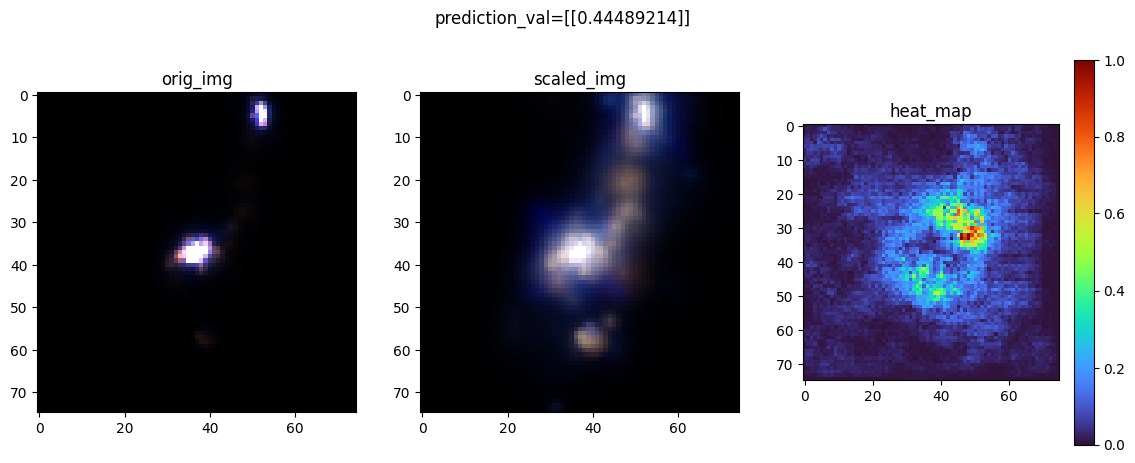

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

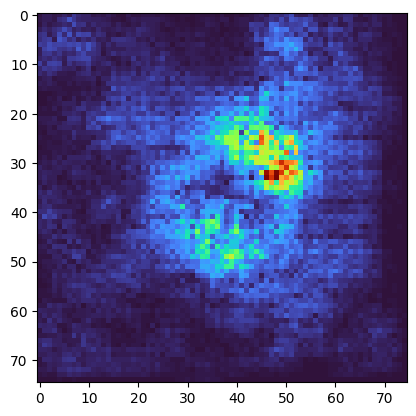

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

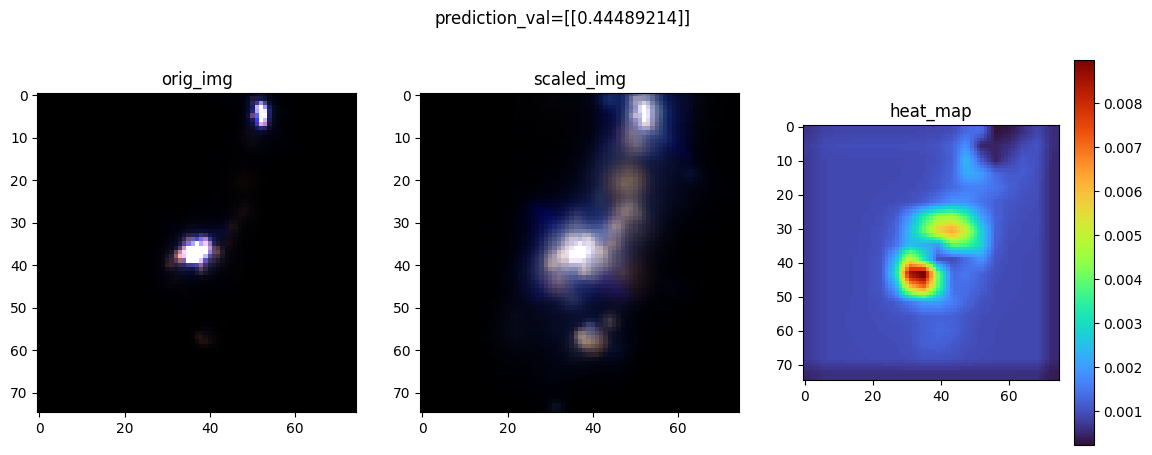

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 5/32 [===>..........................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

20/32 [=================>............] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 1s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

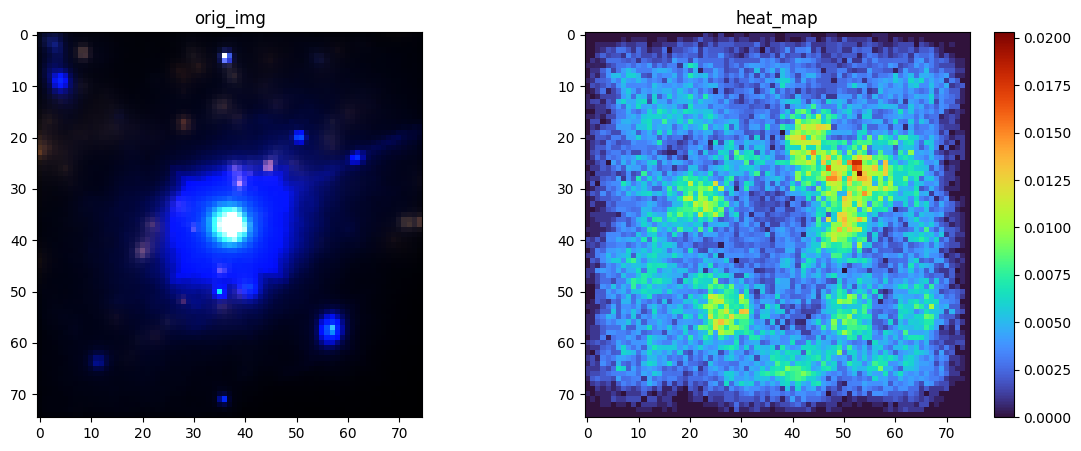

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


2024-06-04 17:40:08.586796: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 728865000 exceeds 10% of free system memory.


  1/338 [..............................] - ETA: 6:19 - loss: 0.7102 - accuracy: 0.2500

  2/338 [..............................] - ETA: 20s - loss: 0.7097 - accuracy: 0.4062 

  3/338 [..............................] - ETA: 21s - loss: 0.7093 - accuracy: 0.4688

  4/338 [..............................] - ETA: 20s - loss: 0.7091 - accuracy: 0.4688

  5/338 [..............................] - ETA: 19s - loss: 0.7091 - accuracy: 0.4375

  6/338 [..............................] - ETA: 19s - loss: 0.7085 - accuracy: 0.4844

  7/338 [..............................] - ETA: 19s - loss: 0.7082 - accuracy: 0.4911

  8/338 [..............................] - ETA: 18s - loss: 0.7079 - accuracy: 0.4961

  9/338 [..............................] - ETA: 18s - loss: 0.7077 - accuracy: 0.4931

 10/338 [..............................] - ETA: 18s - loss: 0.7075 - accuracy: 0.4906

 11/338 [..............................] - ETA: 18s - loss: 0.7073 - accuracy: 0.4858

 12/338 [>.............................] - ETA: 18s - loss: 0.7068 - accuracy: 0.5104

 13/338 [>.............................] - ETA: 18s - loss: 0.7065 - accuracy: 0.5144

 14/338 [>.............................] - ETA: 18s - loss: 0.7062 - accuracy: 0.5179

 15/338 [>.............................] - ETA: 18s - loss: 0.7061 - accuracy: 0.5104

 16/338 [>.............................] - ETA: 18s - loss: 0.7059 - accuracy: 0.5098

 17/338 [>.............................] - ETA: 18s - loss: 0.7056 - accuracy: 0.5092

 18/338 [>.............................] - ETA: 18s - loss: 0.7056 - accuracy: 0.5000

 19/338 [>.............................] - ETA: 18s - loss: 0.7052 - accuracy: 0.5099

 20/338 [>.............................] - ETA: 18s - loss: 0.7050 - accuracy: 0.5141

 21/338 [>.............................] - ETA: 18s - loss: 0.7048 - accuracy: 0.5104

 22/338 [>.............................] - ETA: 17s - loss: 0.7046 - accuracy: 0.5142

 23/338 [=>............................] - ETA: 17s - loss: 0.7043 - accuracy: 0.5204

 24/338 [=>............................] - ETA: 17s - loss: 0.7040 - accuracy: 0.5208

 25/338 [=>............................] - ETA: 17s - loss: 0.7039 - accuracy: 0.5200

 26/338 [=>............................] - ETA: 17s - loss: 0.7036 - accuracy: 0.5228

 27/338 [=>............................] - ETA: 17s - loss: 0.7035 - accuracy: 0.5208

 28/338 [=>............................] - ETA: 17s - loss: 0.7032 - accuracy: 0.5257

 29/338 [=>............................] - ETA: 17s - loss: 0.7029 - accuracy: 0.5312

 30/338 [=>............................] - ETA: 17s - loss: 0.7028 - accuracy: 0.5312

 31/338 [=>............................] - ETA: 17s - loss: 0.7025 - accuracy: 0.5343

 32/338 [=>............................] - ETA: 17s - loss: 0.7024 - accuracy: 0.5352

 33/338 [=>............................] - ETA: 17s - loss: 0.7022 - accuracy: 0.5360

 34/338 [==>...........................] - ETA: 17s - loss: 0.7021 - accuracy: 0.5349

 35/338 [==>...........................] - ETA: 17s - loss: 0.7019 - accuracy: 0.5357

 36/338 [==>...........................] - ETA: 16s - loss: 0.7017 - accuracy: 0.5373

 37/338 [==>...........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5346

 38/338 [==>...........................] - ETA: 16s - loss: 0.7015 - accuracy: 0.5354

 39/338 [==>...........................] - ETA: 16s - loss: 0.7015 - accuracy: 0.5312

 40/338 [==>...........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5250

 41/338 [==>...........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5236

 42/338 [==>...........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.5238

 43/338 [==>...........................] - ETA: 16s - loss: 0.7013 - accuracy: 0.5247

 44/338 [==>...........................] - ETA: 16s - loss: 0.7012 - accuracy: 0.5249

 45/338 [==>...........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5250

 46/338 [===>..........................] - ETA: 16s - loss: 0.7009 - accuracy: 0.5265

 47/338 [===>..........................] - ETA: 16s - loss: 0.7006 - accuracy: 0.5293

 48/338 [===>..........................] - ETA: 16s - loss: 0.7004 - accuracy: 0.5319

 49/338 [===>..........................] - ETA: 16s - loss: 0.7002 - accuracy: 0.5351

 50/338 [===>..........................] - ETA: 16s - loss: 0.7001 - accuracy: 0.5350

 51/338 [===>..........................] - ETA: 16s - loss: 0.7000 - accuracy: 0.5343

 52/338 [===>..........................] - ETA: 15s - loss: 0.6999 - accuracy: 0.5349

 53/338 [===>..........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.5342

 54/338 [===>..........................] - ETA: 15s - loss: 0.6996 - accuracy: 0.5370

 55/338 [===>..........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5381

 56/338 [===>..........................] - ETA: 15s - loss: 0.6994 - accuracy: 0.5385

 57/338 [====>.........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5389

 58/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5383

 59/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5376

 60/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5375

 61/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5369

 62/338 [====>.........................] - ETA: 15s - loss: 0.6990 - accuracy: 0.5363

 63/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5342

 64/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5327

 65/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5312

 66/338 [====>.........................] - ETA: 15s - loss: 0.6990 - accuracy: 0.5317

 67/338 [====>.........................] - ETA: 15s - loss: 0.6989 - accuracy: 0.5317

 68/338 [=====>........................] - ETA: 15s - loss: 0.6989 - accuracy: 0.5312

 69/338 [=====>........................] - ETA: 15s - loss: 0.6989 - accuracy: 0.5299

 70/338 [=====>........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5326

 71/338 [=====>........................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5330

 72/338 [=====>........................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5326

 73/338 [=====>........................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5330

 74/338 [=====>........................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5317

 75/338 [=====>........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5321

 76/338 [=====>........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5333

 77/338 [=====>........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5317

 78/338 [=====>........................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5317

 79/338 [======>.......................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5309

 80/338 [======>.......................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5309

 81/338 [======>.......................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5293

 82/338 [======>.......................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5282

 83/338 [======>.......................] - ETA: 14s - loss: 0.6980 - accuracy: 0.5297

 84/338 [======>.......................] - ETA: 14s - loss: 0.6979 - accuracy: 0.5301

 85/338 [======>.......................] - ETA: 14s - loss: 0.6979 - accuracy: 0.5298

 86/338 [======>.......................] - ETA: 14s - loss: 0.6979 - accuracy: 0.5291

 87/338 [======>.......................] - ETA: 14s - loss: 0.6978 - accuracy: 0.5295

 88/338 [======>.......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5288

 89/338 [======>.......................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5295

 90/338 [======>.......................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5295

 91/338 [=======>......................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5288

 92/338 [=======>......................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5289

 93/338 [=======>......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5292

 94/338 [=======>......................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5279

 95/338 [=======>......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5286

 96/338 [=======>......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5270

 97/338 [=======>......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5261

 98/338 [=======>......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5252

 99/338 [=======>......................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5240

100/338 [=======>......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5234

101/338 [=======>......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5232

102/338 [========>.....................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5230

103/338 [========>.....................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5221

104/338 [========>.....................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5213

105/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5208

106/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5203

107/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5190

108/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5197

109/338 [========>.....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5201

110/338 [========>.....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5202

111/338 [========>.....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5206

112/338 [========>.....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5204

113/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5194

114/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5200

115/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5188

116/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5170

117/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5176

118/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5177

119/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5171

120/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5172

121/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5186

122/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5177

123/338 [=========>....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5178

124/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5176

125/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5185

126/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5191

127/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5187

128/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5183

129/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5177

130/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5183

131/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5186

132/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5173

133/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5186

134/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5184

135/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5181

136/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5182

137/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5185

138/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5186

139/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5180

140/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5179

141/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5175

142/338 [===========>..................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5172

143/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5179

144/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5178

145/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5177

146/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5167

147/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5166

148/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5165

149/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5170

150/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5167

151/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5155

152/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5160

153/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5161

154/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5156

155/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5151

156/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5156

157/338 [============>.................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5157

158/338 [=============>................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5162

159/338 [=============>................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5165

160/338 [=============>................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5172

161/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5171 

162/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5168

163/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5165

164/338 [=============>................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5158

165/338 [=============>................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5167

166/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5168

167/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5165

168/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5166

169/338 [==============>...............] - ETA: 9s - loss: 0.6960 - accuracy: 0.5159

170/338 [==============>...............] - ETA: 9s - loss: 0.6960 - accuracy: 0.5154

171/338 [==============>...............] - ETA: 9s - loss: 0.6960 - accuracy: 0.5159

172/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5154

173/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5159

174/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5158

175/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5159

176/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5156

177/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5150

178/338 [==============>...............] - ETA: 9s - loss: 0.6958 - accuracy: 0.5162

179/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5157

180/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5153

181/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5155

182/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5155

183/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5157

184/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5155

185/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5152

186/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5156

187/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5147

188/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5148

189/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5146

190/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5150

191/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5146

192/338 [================>.............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5156

193/338 [================>.............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5154

194/338 [================>.............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5143

195/338 [================>.............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5139

196/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5136

197/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5140

198/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5142

199/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5143

200/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5139

201/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5143

202/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5149

203/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5162

204/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5165

205/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5171

206/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5173

207/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5178

208/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5182

209/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5187

210/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5189

211/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5191

212/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5192

213/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5194

214/338 [=================>............] - ETA: 6s - loss: 0.6951 - accuracy: 0.5199

215/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5208

216/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5207

217/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5212

218/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5214

219/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5217

220/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5222

221/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5221

222/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5224

223/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5228

224/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5227

225/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5228

226/338 [===================>..........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5234

227/338 [===================>..........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5234

228/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5238

229/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5236

230/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5235

231/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5239

232/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5242

233/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5244

234/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5240

235/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5246

236/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5246

237/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5244

238/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5251

239/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5254

240/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5249

241/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5252

242/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5251

243/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5251

244/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5251

245/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5255

246/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5258

247/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5254

248/338 [=====================>........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5251

249/338 [=====================>........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5245

250/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5250

251/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5250

252/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5248

253/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5245

254/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5253

255/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5249

256/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5249

257/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5250

258/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5253

259/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5256

260/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5258

261/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5259

262/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5258

263/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5260

264/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5259

265/338 [======================>.......] - ETA: 4s - loss: 0.6938 - accuracy: 0.5270

266/338 [======================>.......] - ETA: 4s - loss: 0.6938 - accuracy: 0.5271

267/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5270

268/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5264

269/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5267

270/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5267

271/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5269

272/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5269

273/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5270

274/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5269

275/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5272

276/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5274

277/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5273

278/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5277

279/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5282

280/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5281

281/338 [=======================>......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5286

282/338 [========================>.....] - ETA: 3s - loss: 0.6933 - accuracy: 0.5284

283/338 [========================>.....] - ETA: 3s - loss: 0.6933 - accuracy: 0.5285

284/338 [========================>.....] - ETA: 3s - loss: 0.6933 - accuracy: 0.5282

285/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5286

286/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5286

287/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5287

288/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5286

289/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5289

290/338 [========================>.....] - ETA: 2s - loss: 0.6930 - accuracy: 0.5292

291/338 [========================>.....] - ETA: 2s - loss: 0.6930 - accuracy: 0.5293

292/338 [========================>.....] - ETA: 2s - loss: 0.6930 - accuracy: 0.5290

293/338 [=========================>....] - ETA: 2s - loss: 0.6929 - accuracy: 0.5292

294/338 [=========================>....] - ETA: 2s - loss: 0.6929 - accuracy: 0.5293

295/338 [=========================>....] - ETA: 2s - loss: 0.6929 - accuracy: 0.5297

296/338 [=========================>....] - ETA: 2s - loss: 0.6928 - accuracy: 0.5301

297/338 [=========================>....] - ETA: 2s - loss: 0.6927 - accuracy: 0.5302

298/338 [=========================>....] - ETA: 2s - loss: 0.6926 - accuracy: 0.5308

299/338 [=========================>....] - ETA: 2s - loss: 0.6926 - accuracy: 0.5308

300/338 [=========================>....] - ETA: 2s - loss: 0.6926 - accuracy: 0.5305

301/338 [=========================>....] - ETA: 2s - loss: 0.6926 - accuracy: 0.5303

302/338 [=========================>....] - ETA: 2s - loss: 0.6926 - accuracy: 0.5301

303/338 [=========================>....] - ETA: 1s - loss: 0.6926 - accuracy: 0.5296

304/338 [=========================>....] - ETA: 1s - loss: 0.6925 - accuracy: 0.5299

305/338 [==========================>...] - ETA: 1s - loss: 0.6926 - accuracy: 0.5296

306/338 [==========================>...] - ETA: 1s - loss: 0.6925 - accuracy: 0.5297

307/338 [==========================>...] - ETA: 1s - loss: 0.6925 - accuracy: 0.5297

308/338 [==========================>...] - ETA: 1s - loss: 0.6924 - accuracy: 0.5302

309/338 [==========================>...] - ETA: 1s - loss: 0.6924 - accuracy: 0.5303

310/338 [==========================>...] - ETA: 1s - loss: 0.6923 - accuracy: 0.5304

311/338 [==========================>...] - ETA: 1s - loss: 0.6923 - accuracy: 0.5306

312/338 [==========================>...] - ETA: 1s - loss: 0.6922 - accuracy: 0.5308

313/338 [==========================>...] - ETA: 1s - loss: 0.6922 - accuracy: 0.5306

314/338 [==========================>...] - ETA: 1s - loss: 0.6922 - accuracy: 0.5306

315/338 [==========================>...] - ETA: 1s - loss: 0.6922 - accuracy: 0.5307

316/338 [===========================>..] - ETA: 1s - loss: 0.6921 - accuracy: 0.5309

317/338 [===========================>..] - ETA: 1s - loss: 0.6922 - accuracy: 0.5303

318/338 [===========================>..] - ETA: 1s - loss: 0.6921 - accuracy: 0.5306

319/338 [===========================>..] - ETA: 1s - loss: 0.6922 - accuracy: 0.5301

320/338 [===========================>..] - ETA: 1s - loss: 0.6921 - accuracy: 0.5305

321/338 [===========================>..] - ETA: 0s - loss: 0.6921 - accuracy: 0.5307

322/338 [===========================>..] - ETA: 0s - loss: 0.6921 - accuracy: 0.5305

323/338 [===========================>..] - ETA: 0s - loss: 0.6921 - accuracy: 0.5302

324/338 [===========================>..] - ETA: 0s - loss: 0.6921 - accuracy: 0.5301

325/338 [===========================>..] - ETA: 0s - loss: 0.6921 - accuracy: 0.5300

326/338 [===========================>..] - ETA: 0s - loss: 0.6921 - accuracy: 0.5297

327/338 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.5302

328/338 [============================>.] - ETA: 0s - loss: 0.6919 - accuracy: 0.5304

329/338 [============================>.] - ETA: 0s - loss: 0.6919 - accuracy: 0.5303

330/338 [============================>.] - ETA: 0s - loss: 0.6919 - accuracy: 0.5307

331/338 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.5308

332/338 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.5308

333/338 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.5309

334/338 [============================>.] - ETA: 0s - loss: 0.6919 - accuracy: 0.5306

335/338 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.5307

336/338 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.5305

337/338 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.5309

338/338 [==============================] - 22s 61ms/step - loss: 0.6917 - accuracy: 0.5311 - val_loss: 0.6935 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 19s - loss: 0.6757 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.6819 - accuracy: 0.5156

  3/338 [..............................] - ETA: 18s - loss: 0.6772 - accuracy: 0.5312

  4/338 [..............................] - ETA: 18s - loss: 0.6809 - accuracy: 0.5234

  5/338 [..............................] - ETA: 18s - loss: 0.6827 - accuracy: 0.5188

  6/338 [..............................] - ETA: 18s - loss: 0.6872 - accuracy: 0.4948

  7/338 [..............................] - ETA: 18s - loss: 0.6870 - accuracy: 0.5000

  8/338 [..............................] - ETA: 18s - loss: 0.6843 - accuracy: 0.5117

  9/338 [..............................] - ETA: 18s - loss: 0.6851 - accuracy: 0.5069

 10/338 [..............................] - ETA: 18s - loss: 0.6846 - accuracy: 0.5000

 11/338 [..............................] - ETA: 18s - loss: 0.6846 - accuracy: 0.5057

 12/338 [>.............................] - ETA: 18s - loss: 0.6857 - accuracy: 0.4948

 13/338 [>.............................] - ETA: 18s - loss: 0.6869 - accuracy: 0.4904

 14/338 [>.............................] - ETA: 18s - loss: 0.6874 - accuracy: 0.4888

 15/338 [>.............................] - ETA: 17s - loss: 0.6861 - accuracy: 0.4958

 16/338 [>.............................] - ETA: 17s - loss: 0.6867 - accuracy: 0.4961

 17/338 [>.............................] - ETA: 17s - loss: 0.6878 - accuracy: 0.4871

 18/338 [>.............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.4896

 19/338 [>.............................] - ETA: 17s - loss: 0.6861 - accuracy: 0.4951

 20/338 [>.............................] - ETA: 17s - loss: 0.6863 - accuracy: 0.5031

 21/338 [>.............................] - ETA: 17s - loss: 0.6864 - accuracy: 0.5000

 22/338 [>.............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5057

 23/338 [=>............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5054

 24/338 [=>............................] - ETA: 17s - loss: 0.6846 - accuracy: 0.5156

 25/338 [=>............................] - ETA: 17s - loss: 0.6846 - accuracy: 0.5188

 26/338 [=>............................] - ETA: 17s - loss: 0.6840 - accuracy: 0.5240

 27/338 [=>............................] - ETA: 17s - loss: 0.6847 - accuracy: 0.5208

 28/338 [=>............................] - ETA: 17s - loss: 0.6854 - accuracy: 0.5145

 29/338 [=>............................] - ETA: 17s - loss: 0.6856 - accuracy: 0.5162

 30/338 [=>............................] - ETA: 17s - loss: 0.6858 - accuracy: 0.5167

 31/338 [=>............................] - ETA: 17s - loss: 0.6858 - accuracy: 0.5171

 32/338 [=>............................] - ETA: 16s - loss: 0.6856 - accuracy: 0.5186

 33/338 [=>............................] - ETA: 16s - loss: 0.6856 - accuracy: 0.5170

 34/338 [==>...........................] - ETA: 16s - loss: 0.6858 - accuracy: 0.5147

 35/338 [==>...........................] - ETA: 16s - loss: 0.6854 - accuracy: 0.5170

 36/338 [==>...........................] - ETA: 16s - loss: 0.6856 - accuracy: 0.5148

 37/338 [==>...........................] - ETA: 16s - loss: 0.6853 - accuracy: 0.5169

 38/338 [==>...........................] - ETA: 16s - loss: 0.6854 - accuracy: 0.5189

 39/338 [==>...........................] - ETA: 16s - loss: 0.6855 - accuracy: 0.5160

 40/338 [==>...........................] - ETA: 16s - loss: 0.6856 - accuracy: 0.5164

 41/338 [==>...........................] - ETA: 16s - loss: 0.6851 - accuracy: 0.5183

 42/338 [==>...........................] - ETA: 16s - loss: 0.6844 - accuracy: 0.5216

 43/338 [==>...........................] - ETA: 16s - loss: 0.6847 - accuracy: 0.5203

 44/338 [==>...........................] - ETA: 16s - loss: 0.6846 - accuracy: 0.5199

 45/338 [==>...........................] - ETA: 16s - loss: 0.6846 - accuracy: 0.5201

 46/338 [===>..........................] - ETA: 16s - loss: 0.6847 - accuracy: 0.5197

 47/338 [===>..........................] - ETA: 16s - loss: 0.6858 - accuracy: 0.5140

 48/338 [===>..........................] - ETA: 16s - loss: 0.6857 - accuracy: 0.5150

 49/338 [===>..........................] - ETA: 16s - loss: 0.6860 - accuracy: 0.5140

 50/338 [===>..........................] - ETA: 16s - loss: 0.6862 - accuracy: 0.5125

 51/338 [===>..........................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5110

 52/338 [===>..........................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5144

 53/338 [===>..........................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5171

 54/338 [===>..........................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5197

 55/338 [===>..........................] - ETA: 15s - loss: 0.6855 - accuracy: 0.5222

 56/338 [===>..........................] - ETA: 15s - loss: 0.6851 - accuracy: 0.5273

 57/338 [====>.........................] - ETA: 15s - loss: 0.6850 - accuracy: 0.5302

 58/338 [====>.........................] - ETA: 15s - loss: 0.6850 - accuracy: 0.5312

 59/338 [====>.........................] - ETA: 15s - loss: 0.6851 - accuracy: 0.5318

 60/338 [====>.........................] - ETA: 15s - loss: 0.6850 - accuracy: 0.5344

 61/338 [====>.........................] - ETA: 15s - loss: 0.6849 - accuracy: 0.5364

 62/338 [====>.........................] - ETA: 15s - loss: 0.6848 - accuracy: 0.5388

 63/338 [====>.........................] - ETA: 15s - loss: 0.6848 - accuracy: 0.5397

 64/338 [====>.........................] - ETA: 15s - loss: 0.6846 - accuracy: 0.5415

 65/338 [====>.........................] - ETA: 15s - loss: 0.6845 - accuracy: 0.5437

 66/338 [====>.........................] - ETA: 15s - loss: 0.6847 - accuracy: 0.5436

 67/338 [====>.........................] - ETA: 15s - loss: 0.6845 - accuracy: 0.5434

 68/338 [=====>........................] - ETA: 15s - loss: 0.6844 - accuracy: 0.5455

 69/338 [=====>........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5485

 70/338 [=====>........................] - ETA: 14s - loss: 0.6843 - accuracy: 0.5482

 71/338 [=====>........................] - ETA: 14s - loss: 0.6843 - accuracy: 0.5489

 72/338 [=====>........................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5482

 73/338 [=====>........................] - ETA: 14s - loss: 0.6843 - accuracy: 0.5497

 74/338 [=====>........................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5498

 75/338 [=====>........................] - ETA: 14s - loss: 0.6843 - accuracy: 0.5504

 76/338 [=====>........................] - ETA: 14s - loss: 0.6842 - accuracy: 0.5518

 77/338 [=====>........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5536

 78/338 [=====>........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5549

 79/338 [======>.......................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5562

 80/338 [======>.......................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5570

 81/338 [======>.......................] - ETA: 14s - loss: 0.6838 - accuracy: 0.5590

 82/338 [======>.......................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5606

 83/338 [======>.......................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5614

 84/338 [======>.......................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5621

 85/338 [======>.......................] - ETA: 14s - loss: 0.6836 - accuracy: 0.5643

 86/338 [======>.......................] - ETA: 13s - loss: 0.6838 - accuracy: 0.5640

 87/338 [======>.......................] - ETA: 13s - loss: 0.6837 - accuracy: 0.5650

 88/338 [======>.......................] - ETA: 13s - loss: 0.6837 - accuracy: 0.5657

 89/338 [======>.......................] - ETA: 13s - loss: 0.6837 - accuracy: 0.5660

 90/338 [======>.......................] - ETA: 13s - loss: 0.6840 - accuracy: 0.5649

 91/338 [=======>......................] - ETA: 13s - loss: 0.6840 - accuracy: 0.5649

 92/338 [=======>......................] - ETA: 13s - loss: 0.6838 - accuracy: 0.5666

 93/338 [=======>......................] - ETA: 13s - loss: 0.6834 - accuracy: 0.5689

 94/338 [=======>......................] - ETA: 13s - loss: 0.6834 - accuracy: 0.5688

 95/338 [=======>......................] - ETA: 13s - loss: 0.6835 - accuracy: 0.5684

 96/338 [=======>......................] - ETA: 13s - loss: 0.6835 - accuracy: 0.5693

 97/338 [=======>......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5706

 98/338 [=======>......................] - ETA: 13s - loss: 0.6832 - accuracy: 0.5721

 99/338 [=======>......................] - ETA: 13s - loss: 0.6830 - accuracy: 0.5732

100/338 [=======>......................] - ETA: 13s - loss: 0.6830 - accuracy: 0.5741

101/338 [=======>......................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5749

102/338 [========>.....................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5751

103/338 [========>.....................] - ETA: 13s - loss: 0.6827 - accuracy: 0.5768

104/338 [========>.....................] - ETA: 12s - loss: 0.6827 - accuracy: 0.5775

105/338 [========>.....................] - ETA: 12s - loss: 0.6826 - accuracy: 0.5783

106/338 [========>.....................] - ETA: 12s - loss: 0.6826 - accuracy: 0.5781

107/338 [========>.....................] - ETA: 12s - loss: 0.6825 - accuracy: 0.5794

108/338 [========>.....................] - ETA: 12s - loss: 0.6824 - accuracy: 0.5802

109/338 [========>.....................] - ETA: 12s - loss: 0.6823 - accuracy: 0.5820

110/338 [========>.....................] - ETA: 12s - loss: 0.6820 - accuracy: 0.5844

111/338 [========>.....................] - ETA: 12s - loss: 0.6818 - accuracy: 0.5856

112/338 [========>.....................] - ETA: 12s - loss: 0.6819 - accuracy: 0.5862

113/338 [=========>....................] - ETA: 12s - loss: 0.6821 - accuracy: 0.5860

114/338 [=========>....................] - ETA: 12s - loss: 0.6822 - accuracy: 0.5855

115/338 [=========>....................] - ETA: 12s - loss: 0.6823 - accuracy: 0.5853

116/338 [=========>....................] - ETA: 12s - loss: 0.6822 - accuracy: 0.5862

117/338 [=========>....................] - ETA: 12s - loss: 0.6822 - accuracy: 0.5868

118/338 [=========>....................] - ETA: 12s - loss: 0.6822 - accuracy: 0.5869

119/338 [=========>....................] - ETA: 12s - loss: 0.6821 - accuracy: 0.5872

120/338 [=========>....................] - ETA: 12s - loss: 0.6820 - accuracy: 0.5883

121/338 [=========>....................] - ETA: 12s - loss: 0.6820 - accuracy: 0.5881

122/338 [=========>....................] - ETA: 11s - loss: 0.6820 - accuracy: 0.5879

123/338 [=========>....................] - ETA: 11s - loss: 0.6822 - accuracy: 0.5877

124/338 [==========>...................] - ETA: 11s - loss: 0.6823 - accuracy: 0.5872

125/338 [==========>...................] - ETA: 11s - loss: 0.6822 - accuracy: 0.5880

126/338 [==========>...................] - ETA: 11s - loss: 0.6821 - accuracy: 0.5890

127/338 [==========>...................] - ETA: 11s - loss: 0.6820 - accuracy: 0.5896

128/338 [==========>...................] - ETA: 11s - loss: 0.6820 - accuracy: 0.5896

129/338 [==========>...................] - ETA: 11s - loss: 0.6823 - accuracy: 0.5882

130/338 [==========>...................] - ETA: 11s - loss: 0.6824 - accuracy: 0.5882

131/338 [==========>...................] - ETA: 11s - loss: 0.6826 - accuracy: 0.5873

132/338 [==========>...................] - ETA: 11s - loss: 0.6825 - accuracy: 0.5881

133/338 [==========>...................] - ETA: 11s - loss: 0.6824 - accuracy: 0.5891

134/338 [==========>...................] - ETA: 11s - loss: 0.6825 - accuracy: 0.5886

135/338 [==========>...................] - ETA: 11s - loss: 0.6826 - accuracy: 0.5882

136/338 [===========>..................] - ETA: 11s - loss: 0.6826 - accuracy: 0.5880

137/338 [===========>..................] - ETA: 11s - loss: 0.6824 - accuracy: 0.5892

138/338 [===========>..................] - ETA: 11s - loss: 0.6825 - accuracy: 0.5885

139/338 [===========>..................] - ETA: 11s - loss: 0.6825 - accuracy: 0.5888

140/338 [===========>..................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5897

141/338 [===========>..................] - ETA: 10s - loss: 0.6823 - accuracy: 0.5904

142/338 [===========>..................] - ETA: 10s - loss: 0.6822 - accuracy: 0.5918

143/338 [===========>..................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5924

144/338 [===========>..................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5918

145/338 [===========>..................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5918

146/338 [===========>..................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5920

147/338 [============>.................] - ETA: 10s - loss: 0.6822 - accuracy: 0.5914

148/338 [============>.................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5927

149/338 [============>.................] - ETA: 10s - loss: 0.6820 - accuracy: 0.5929

150/338 [============>.................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5929

151/338 [============>.................] - ETA: 10s - loss: 0.6822 - accuracy: 0.5925

152/338 [============>.................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5929

153/338 [============>.................] - ETA: 10s - loss: 0.6820 - accuracy: 0.5933

154/338 [============>.................] - ETA: 10s - loss: 0.6818 - accuracy: 0.5938

155/338 [============>.................] - ETA: 10s - loss: 0.6818 - accuracy: 0.5944

156/338 [============>.................] - ETA: 10s - loss: 0.6817 - accuracy: 0.5946

157/338 [============>.................] - ETA: 10s - loss: 0.6816 - accuracy: 0.5955

158/338 [=============>................] - ETA: 9s - loss: 0.6815 - accuracy: 0.5963 

159/338 [=============>................] - ETA: 9s - loss: 0.6816 - accuracy: 0.5963

160/338 [=============>................] - ETA: 9s - loss: 0.6815 - accuracy: 0.5969

161/338 [=============>................] - ETA: 9s - loss: 0.6815 - accuracy: 0.5967

162/338 [=============>................] - ETA: 9s - loss: 0.6814 - accuracy: 0.5970

163/338 [=============>................] - ETA: 9s - loss: 0.6816 - accuracy: 0.5962

164/338 [=============>................] - ETA: 9s - loss: 0.6816 - accuracy: 0.5966

165/338 [=============>................] - ETA: 9s - loss: 0.6816 - accuracy: 0.5970

166/338 [=============>................] - ETA: 9s - loss: 0.6815 - accuracy: 0.5971

167/338 [=============>................] - ETA: 9s - loss: 0.6814 - accuracy: 0.5982

168/338 [=============>................] - ETA: 9s - loss: 0.6814 - accuracy: 0.5988

169/338 [==============>...............] - ETA: 9s - loss: 0.6814 - accuracy: 0.5993

170/338 [==============>...............] - ETA: 9s - loss: 0.6814 - accuracy: 0.5996

171/338 [==============>...............] - ETA: 9s - loss: 0.6815 - accuracy: 0.5990

172/338 [==============>...............] - ETA: 9s - loss: 0.6814 - accuracy: 0.5996

173/338 [==============>...............] - ETA: 9s - loss: 0.6814 - accuracy: 0.6001

174/338 [==============>...............] - ETA: 9s - loss: 0.6813 - accuracy: 0.6006

175/338 [==============>...............] - ETA: 9s - loss: 0.6811 - accuracy: 0.6014

176/338 [==============>...............] - ETA: 8s - loss: 0.6810 - accuracy: 0.6021

177/338 [==============>...............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6028

178/338 [==============>...............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6027

179/338 [==============>...............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6027

180/338 [==============>...............] - ETA: 8s - loss: 0.6810 - accuracy: 0.6023

181/338 [===============>..............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6029

182/338 [===============>..............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6025

183/338 [===============>..............] - ETA: 8s - loss: 0.6808 - accuracy: 0.6023

184/338 [===============>..............] - ETA: 8s - loss: 0.6808 - accuracy: 0.6029

185/338 [===============>..............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6027

186/338 [===============>..............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6025

187/338 [===============>..............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6031

188/338 [===============>..............] - ETA: 8s - loss: 0.6808 - accuracy: 0.6032

189/338 [===============>..............] - ETA: 8s - loss: 0.6807 - accuracy: 0.6038

190/338 [===============>..............] - ETA: 8s - loss: 0.6806 - accuracy: 0.6043

191/338 [===============>..............] - ETA: 8s - loss: 0.6806 - accuracy: 0.6045

192/338 [================>.............] - ETA: 8s - loss: 0.6806 - accuracy: 0.6042

193/338 [================>.............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6031

194/338 [================>.............] - ETA: 7s - loss: 0.6807 - accuracy: 0.6039

195/338 [================>.............] - ETA: 7s - loss: 0.6808 - accuracy: 0.6038

196/338 [================>.............] - ETA: 7s - loss: 0.6807 - accuracy: 0.6041

197/338 [================>.............] - ETA: 7s - loss: 0.6806 - accuracy: 0.6044

198/338 [================>.............] - ETA: 7s - loss: 0.6806 - accuracy: 0.6046

199/338 [================>.............] - ETA: 7s - loss: 0.6807 - accuracy: 0.6047

200/338 [================>.............] - ETA: 7s - loss: 0.6808 - accuracy: 0.6041

201/338 [================>.............] - ETA: 7s - loss: 0.6807 - accuracy: 0.6045

202/338 [================>.............] - ETA: 7s - loss: 0.6807 - accuracy: 0.6046

203/338 [=================>............] - ETA: 7s - loss: 0.6806 - accuracy: 0.6053

204/338 [=================>............] - ETA: 7s - loss: 0.6805 - accuracy: 0.6062

205/338 [=================>............] - ETA: 7s - loss: 0.6805 - accuracy: 0.6059

206/338 [=================>............] - ETA: 7s - loss: 0.6805 - accuracy: 0.6062

207/338 [=================>............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6066

208/338 [=================>............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6067

209/338 [=================>............] - ETA: 7s - loss: 0.6805 - accuracy: 0.6062

210/338 [=================>............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6065

211/338 [=================>............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6069

212/338 [=================>............] - ETA: 6s - loss: 0.6805 - accuracy: 0.6066

213/338 [=================>............] - ETA: 6s - loss: 0.6805 - accuracy: 0.6064

214/338 [=================>............] - ETA: 6s - loss: 0.6804 - accuracy: 0.6067

215/338 [==================>...........] - ETA: 6s - loss: 0.6804 - accuracy: 0.6070

216/338 [==================>...........] - ETA: 6s - loss: 0.6803 - accuracy: 0.6072

217/338 [==================>...........] - ETA: 6s - loss: 0.6803 - accuracy: 0.6071

218/338 [==================>...........] - ETA: 6s - loss: 0.6802 - accuracy: 0.6074

219/338 [==================>...........] - ETA: 6s - loss: 0.6801 - accuracy: 0.6079

220/338 [==================>...........] - ETA: 6s - loss: 0.6801 - accuracy: 0.6081

221/338 [==================>...........] - ETA: 6s - loss: 0.6801 - accuracy: 0.6079

222/338 [==================>...........] - ETA: 6s - loss: 0.6802 - accuracy: 0.6071

223/338 [==================>...........] - ETA: 6s - loss: 0.6803 - accuracy: 0.6071

224/338 [==================>...........] - ETA: 6s - loss: 0.6802 - accuracy: 0.6076

225/338 [==================>...........] - ETA: 6s - loss: 0.6803 - accuracy: 0.6072

226/338 [===================>..........] - ETA: 6s - loss: 0.6804 - accuracy: 0.6065

227/338 [===================>..........] - ETA: 6s - loss: 0.6805 - accuracy: 0.6063

228/338 [===================>..........] - ETA: 6s - loss: 0.6804 - accuracy: 0.6069

229/338 [===================>..........] - ETA: 6s - loss: 0.6804 - accuracy: 0.6067

230/338 [===================>..........] - ETA: 5s - loss: 0.6805 - accuracy: 0.6064

231/338 [===================>..........] - ETA: 5s - loss: 0.6806 - accuracy: 0.6055

232/338 [===================>..........] - ETA: 5s - loss: 0.6804 - accuracy: 0.6059

233/338 [===================>..........] - ETA: 5s - loss: 0.6806 - accuracy: 0.6053

234/338 [===================>..........] - ETA: 5s - loss: 0.6805 - accuracy: 0.6060

235/338 [===================>..........] - ETA: 5s - loss: 0.6805 - accuracy: 0.6060

236/338 [===================>..........] - ETA: 5s - loss: 0.6804 - accuracy: 0.6061

237/338 [====================>.........] - ETA: 5s - loss: 0.6804 - accuracy: 0.6060

238/338 [====================>.........] - ETA: 5s - loss: 0.6804 - accuracy: 0.6065

239/338 [====================>.........] - ETA: 5s - loss: 0.6803 - accuracy: 0.6071

240/338 [====================>.........] - ETA: 5s - loss: 0.6804 - accuracy: 0.6068

241/338 [====================>.........] - ETA: 5s - loss: 0.6804 - accuracy: 0.6062

242/338 [====================>.........] - ETA: 5s - loss: 0.6803 - accuracy: 0.6067

243/338 [====================>.........] - ETA: 5s - loss: 0.6803 - accuracy: 0.6071

244/338 [====================>.........] - ETA: 5s - loss: 0.6804 - accuracy: 0.6069

245/338 [====================>.........] - ETA: 5s - loss: 0.6803 - accuracy: 0.6075

246/338 [====================>.........] - ETA: 5s - loss: 0.6802 - accuracy: 0.6081

247/338 [====================>.........] - ETA: 5s - loss: 0.6801 - accuracy: 0.6084

248/338 [=====================>........] - ETA: 4s - loss: 0.6800 - accuracy: 0.6092

249/338 [=====================>........] - ETA: 4s - loss: 0.6798 - accuracy: 0.6099

250/338 [=====================>........] - ETA: 4s - loss: 0.6797 - accuracy: 0.6105

251/338 [=====================>........] - ETA: 4s - loss: 0.6797 - accuracy: 0.6104

252/338 [=====================>........] - ETA: 4s - loss: 0.6796 - accuracy: 0.6105

253/338 [=====================>........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6113

254/338 [=====================>........] - ETA: 4s - loss: 0.6795 - accuracy: 0.6116

255/338 [=====================>........] - ETA: 4s - loss: 0.6794 - accuracy: 0.6120

256/338 [=====================>........] - ETA: 4s - loss: 0.6794 - accuracy: 0.6119

257/338 [=====================>........] - ETA: 4s - loss: 0.6794 - accuracy: 0.6122

258/338 [=====================>........] - ETA: 4s - loss: 0.6794 - accuracy: 0.6119

259/338 [=====================>........] - ETA: 4s - loss: 0.6794 - accuracy: 0.6122

260/338 [======================>.......] - ETA: 4s - loss: 0.6793 - accuracy: 0.6125

261/338 [======================>.......] - ETA: 4s - loss: 0.6793 - accuracy: 0.6128

262/338 [======================>.......] - ETA: 4s - loss: 0.6793 - accuracy: 0.6128

263/338 [======================>.......] - ETA: 4s - loss: 0.6792 - accuracy: 0.6131

264/338 [======================>.......] - ETA: 4s - loss: 0.6793 - accuracy: 0.6126

265/338 [======================>.......] - ETA: 4s - loss: 0.6792 - accuracy: 0.6132

266/338 [======================>.......] - ETA: 3s - loss: 0.6791 - accuracy: 0.6134

267/338 [======================>.......] - ETA: 3s - loss: 0.6792 - accuracy: 0.6133

268/338 [======================>.......] - ETA: 3s - loss: 0.6791 - accuracy: 0.6137

269/338 [======================>.......] - ETA: 3s - loss: 0.6791 - accuracy: 0.6137

270/338 [======================>.......] - ETA: 3s - loss: 0.6790 - accuracy: 0.6140

271/338 [=======================>......] - ETA: 3s - loss: 0.6790 - accuracy: 0.6136

272/338 [=======================>......] - ETA: 3s - loss: 0.6790 - accuracy: 0.6139

273/338 [=======================>......] - ETA: 3s - loss: 0.6790 - accuracy: 0.6138

274/338 [=======================>......] - ETA: 3s - loss: 0.6790 - accuracy: 0.6139

275/338 [=======================>......] - ETA: 3s - loss: 0.6790 - accuracy: 0.6142

276/338 [=======================>......] - ETA: 3s - loss: 0.6789 - accuracy: 0.6144

277/338 [=======================>......] - ETA: 3s - loss: 0.6789 - accuracy: 0.6142

278/338 [=======================>......] - ETA: 3s - loss: 0.6789 - accuracy: 0.6142

279/338 [=======================>......] - ETA: 3s - loss: 0.6789 - accuracy: 0.6145

280/338 [=======================>......] - ETA: 3s - loss: 0.6789 - accuracy: 0.6145

281/338 [=======================>......] - ETA: 3s - loss: 0.6789 - accuracy: 0.6145

282/338 [========================>.....] - ETA: 3s - loss: 0.6789 - accuracy: 0.6145

283/338 [========================>.....] - ETA: 3s - loss: 0.6789 - accuracy: 0.6143

284/338 [========================>.....] - ETA: 2s - loss: 0.6788 - accuracy: 0.6148

285/338 [========================>.....] - ETA: 2s - loss: 0.6789 - accuracy: 0.6143

286/338 [========================>.....] - ETA: 2s - loss: 0.6789 - accuracy: 0.6144

287/338 [========================>.....] - ETA: 2s - loss: 0.6788 - accuracy: 0.6147

288/338 [========================>.....] - ETA: 2s - loss: 0.6788 - accuracy: 0.6148

289/338 [========================>.....] - ETA: 2s - loss: 0.6787 - accuracy: 0.6152

290/338 [========================>.....] - ETA: 2s - loss: 0.6786 - accuracy: 0.6155

291/338 [========================>.....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6158

292/338 [========================>.....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6159

293/338 [=========================>....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6163

294/338 [=========================>....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6164

295/338 [=========================>....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6161

296/338 [=========================>....] - ETA: 2s - loss: 0.6785 - accuracy: 0.6159

297/338 [=========================>....] - ETA: 2s - loss: 0.6786 - accuracy: 0.6154

298/338 [=========================>....] - ETA: 2s - loss: 0.6786 - accuracy: 0.6156

299/338 [=========================>....] - ETA: 2s - loss: 0.6786 - accuracy: 0.6155

300/338 [=========================>....] - ETA: 2s - loss: 0.6786 - accuracy: 0.6156

301/338 [=========================>....] - ETA: 2s - loss: 0.6786 - accuracy: 0.6156

302/338 [=========================>....] - ETA: 1s - loss: 0.6785 - accuracy: 0.6158

303/338 [=========================>....] - ETA: 1s - loss: 0.6785 - accuracy: 0.6156

304/338 [=========================>....] - ETA: 1s - loss: 0.6785 - accuracy: 0.6157

305/338 [==========================>...] - ETA: 1s - loss: 0.6785 - accuracy: 0.6158

306/338 [==========================>...] - ETA: 1s - loss: 0.6785 - accuracy: 0.6156

307/338 [==========================>...] - ETA: 1s - loss: 0.6784 - accuracy: 0.6159

308/338 [==========================>...] - ETA: 1s - loss: 0.6783 - accuracy: 0.6164

309/338 [==========================>...] - ETA: 1s - loss: 0.6784 - accuracy: 0.6159

310/338 [==========================>...] - ETA: 1s - loss: 0.6783 - accuracy: 0.6164

311/338 [==========================>...] - ETA: 1s - loss: 0.6783 - accuracy: 0.6164

312/338 [==========================>...] - ETA: 1s - loss: 0.6784 - accuracy: 0.6161

313/338 [==========================>...] - ETA: 1s - loss: 0.6783 - accuracy: 0.6163

314/338 [==========================>...] - ETA: 1s - loss: 0.6783 - accuracy: 0.6163

315/338 [==========================>...] - ETA: 1s - loss: 0.6782 - accuracy: 0.6166

316/338 [===========================>..] - ETA: 1s - loss: 0.6782 - accuracy: 0.6164

317/338 [===========================>..] - ETA: 1s - loss: 0.6782 - accuracy: 0.6163

318/338 [===========================>..] - ETA: 1s - loss: 0.6782 - accuracy: 0.6162

319/338 [===========================>..] - ETA: 1s - loss: 0.6782 - accuracy: 0.6164

320/338 [===========================>..] - ETA: 0s - loss: 0.6782 - accuracy: 0.6166

321/338 [===========================>..] - ETA: 0s - loss: 0.6781 - accuracy: 0.6166

322/338 [===========================>..] - ETA: 0s - loss: 0.6780 - accuracy: 0.6169

323/338 [===========================>..] - ETA: 0s - loss: 0.6780 - accuracy: 0.6173

324/338 [===========================>..] - ETA: 0s - loss: 0.6780 - accuracy: 0.6173

325/338 [===========================>..] - ETA: 0s - loss: 0.6780 - accuracy: 0.6176

326/338 [===========================>..] - ETA: 0s - loss: 0.6780 - accuracy: 0.6170

327/338 [============================>.] - ETA: 0s - loss: 0.6780 - accuracy: 0.6170

328/338 [============================>.] - ETA: 0s - loss: 0.6780 - accuracy: 0.6171

329/338 [============================>.] - ETA: 0s - loss: 0.6780 - accuracy: 0.6170

330/338 [============================>.] - ETA: 0s - loss: 0.6780 - accuracy: 0.6170

331/338 [============================>.] - ETA: 0s - loss: 0.6779 - accuracy: 0.6174

332/338 [============================>.] - ETA: 0s - loss: 0.6779 - accuracy: 0.6173

333/338 [============================>.] - ETA: 0s - loss: 0.6779 - accuracy: 0.6174

334/338 [============================>.] - ETA: 0s - loss: 0.6778 - accuracy: 0.6176

335/338 [============================>.] - ETA: 0s - loss: 0.6779 - accuracy: 0.6176

336/338 [============================>.] - ETA: 0s - loss: 0.6779 - accuracy: 0.6176

337/338 [============================>.] - ETA: 0s - loss: 0.6778 - accuracy: 0.6179

338/338 [==============================] - 20s 60ms/step - loss: 0.6778 - accuracy: 0.6178 - val_loss: 0.6953 - val_accuracy: 0.5135


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6356 - accuracy: 0.7812

  2/338 [..............................] - ETA: 18s - loss: 0.6423 - accuracy: 0.7969

  3/338 [..............................] - ETA: 18s - loss: 0.6508 - accuracy: 0.7500

  4/338 [..............................] - ETA: 18s - loss: 0.6572 - accuracy: 0.7344

  5/338 [..............................] - ETA: 18s - loss: 0.6610 - accuracy: 0.7063

  6/338 [..............................] - ETA: 18s - loss: 0.6605 - accuracy: 0.7083

  7/338 [..............................] - ETA: 18s - loss: 0.6629 - accuracy: 0.6964

  8/338 [..............................] - ETA: 18s - loss: 0.6667 - accuracy: 0.6797

  9/338 [..............................] - ETA: 18s - loss: 0.6695 - accuracy: 0.6632

 10/338 [..............................] - ETA: 18s - loss: 0.6662 - accuracy: 0.6750

 11/338 [..............................] - ETA: 18s - loss: 0.6676 - accuracy: 0.6648

 12/338 [>.............................] - ETA: 18s - loss: 0.6687 - accuracy: 0.6562

 13/338 [>.............................] - ETA: 18s - loss: 0.6695 - accuracy: 0.6490

 14/338 [>.............................] - ETA: 18s - loss: 0.6705 - accuracy: 0.6473

 15/338 [>.............................] - ETA: 17s - loss: 0.6720 - accuracy: 0.6417

 16/338 [>.............................] - ETA: 17s - loss: 0.6701 - accuracy: 0.6484

 17/338 [>.............................] - ETA: 17s - loss: 0.6687 - accuracy: 0.6526

 18/338 [>.............................] - ETA: 17s - loss: 0.6700 - accuracy: 0.6458

 19/338 [>.............................] - ETA: 17s - loss: 0.6698 - accuracy: 0.6464

 20/338 [>.............................] - ETA: 17s - loss: 0.6701 - accuracy: 0.6469

 21/338 [>.............................] - ETA: 17s - loss: 0.6700 - accuracy: 0.6488

 22/338 [>.............................] - ETA: 17s - loss: 0.6709 - accuracy: 0.6435

 23/338 [=>............................] - ETA: 17s - loss: 0.6728 - accuracy: 0.6345

 24/338 [=>............................] - ETA: 17s - loss: 0.6727 - accuracy: 0.6354

 25/338 [=>............................] - ETA: 17s - loss: 0.6722 - accuracy: 0.6363

 26/338 [=>............................] - ETA: 17s - loss: 0.6725 - accuracy: 0.6346

 27/338 [=>............................] - ETA: 17s - loss: 0.6723 - accuracy: 0.6343

 28/338 [=>............................] - ETA: 17s - loss: 0.6717 - accuracy: 0.6362

 29/338 [=>............................] - ETA: 17s - loss: 0.6728 - accuracy: 0.6315

 30/338 [=>............................] - ETA: 17s - loss: 0.6726 - accuracy: 0.6333

 31/338 [=>............................] - ETA: 17s - loss: 0.6723 - accuracy: 0.6341

 32/338 [=>............................] - ETA: 16s - loss: 0.6717 - accuracy: 0.6377

 33/338 [=>............................] - ETA: 16s - loss: 0.6716 - accuracy: 0.6373

 34/338 [==>...........................] - ETA: 16s - loss: 0.6712 - accuracy: 0.6397

 35/338 [==>...........................] - ETA: 16s - loss: 0.6707 - accuracy: 0.6420

 36/338 [==>...........................] - ETA: 16s - loss: 0.6703 - accuracy: 0.6432

 37/338 [==>...........................] - ETA: 16s - loss: 0.6695 - accuracy: 0.6470

 38/338 [==>...........................] - ETA: 16s - loss: 0.6695 - accuracy: 0.6456

 39/338 [==>...........................] - ETA: 16s - loss: 0.6698 - accuracy: 0.6450

 40/338 [==>...........................] - ETA: 16s - loss: 0.6705 - accuracy: 0.6422

 41/338 [==>...........................] - ETA: 16s - loss: 0.6703 - accuracy: 0.6425

 42/338 [==>...........................] - ETA: 16s - loss: 0.6697 - accuracy: 0.6436

 43/338 [==>...........................] - ETA: 16s - loss: 0.6699 - accuracy: 0.6432

 44/338 [==>...........................] - ETA: 16s - loss: 0.6697 - accuracy: 0.6428

 45/338 [==>...........................] - ETA: 16s - loss: 0.6694 - accuracy: 0.6438

 46/338 [===>..........................] - ETA: 16s - loss: 0.6693 - accuracy: 0.6447

 47/338 [===>..........................] - ETA: 16s - loss: 0.6691 - accuracy: 0.6449

 48/338 [===>..........................] - ETA: 16s - loss: 0.6690 - accuracy: 0.6452

 49/338 [===>..........................] - ETA: 16s - loss: 0.6682 - accuracy: 0.6486

 50/338 [===>..........................] - ETA: 16s - loss: 0.6684 - accuracy: 0.6463

 51/338 [===>..........................] - ETA: 15s - loss: 0.6687 - accuracy: 0.6440

 52/338 [===>..........................] - ETA: 15s - loss: 0.6687 - accuracy: 0.6442

 53/338 [===>..........................] - ETA: 15s - loss: 0.6691 - accuracy: 0.6427

 54/338 [===>..........................] - ETA: 15s - loss: 0.6689 - accuracy: 0.6447

 55/338 [===>..........................] - ETA: 15s - loss: 0.6689 - accuracy: 0.6455

 56/338 [===>..........................] - ETA: 15s - loss: 0.6681 - accuracy: 0.6484

 57/338 [====>.........................] - ETA: 15s - loss: 0.6682 - accuracy: 0.6480

 58/338 [====>.........................] - ETA: 15s - loss: 0.6680 - accuracy: 0.6487

 59/338 [====>.........................] - ETA: 15s - loss: 0.6687 - accuracy: 0.6451

 60/338 [====>.........................] - ETA: 15s - loss: 0.6685 - accuracy: 0.6458

 61/338 [====>.........................] - ETA: 15s - loss: 0.6683 - accuracy: 0.6465

 62/338 [====>.........................] - ETA: 15s - loss: 0.6687 - accuracy: 0.6447

 63/338 [====>.........................] - ETA: 15s - loss: 0.6686 - accuracy: 0.6448

 64/338 [====>.........................] - ETA: 15s - loss: 0.6682 - accuracy: 0.6465

 65/338 [====>.........................] - ETA: 15s - loss: 0.6679 - accuracy: 0.6481

 66/338 [====>.........................] - ETA: 15s - loss: 0.6678 - accuracy: 0.6482

 67/338 [====>.........................] - ETA: 15s - loss: 0.6681 - accuracy: 0.6465

 68/338 [=====>........................] - ETA: 15s - loss: 0.6685 - accuracy: 0.6448

 69/338 [=====>........................] - ETA: 14s - loss: 0.6683 - accuracy: 0.6458

 70/338 [=====>........................] - ETA: 14s - loss: 0.6684 - accuracy: 0.6451

 71/338 [=====>........................] - ETA: 14s - loss: 0.6677 - accuracy: 0.6474

 72/338 [=====>........................] - ETA: 14s - loss: 0.6680 - accuracy: 0.6458

 73/338 [=====>........................] - ETA: 14s - loss: 0.6679 - accuracy: 0.6464

 74/338 [=====>........................] - ETA: 14s - loss: 0.6678 - accuracy: 0.6465

 75/338 [=====>........................] - ETA: 14s - loss: 0.6681 - accuracy: 0.6454

 76/338 [=====>........................] - ETA: 14s - loss: 0.6683 - accuracy: 0.6443

 77/338 [=====>........................] - ETA: 14s - loss: 0.6683 - accuracy: 0.6445

 78/338 [=====>........................] - ETA: 14s - loss: 0.6678 - accuracy: 0.6462

 79/338 [======>.......................] - ETA: 14s - loss: 0.6680 - accuracy: 0.6452

 80/338 [======>.......................] - ETA: 14s - loss: 0.6682 - accuracy: 0.6449

 81/338 [======>.......................] - ETA: 14s - loss: 0.6676 - accuracy: 0.6470

 82/338 [======>.......................] - ETA: 14s - loss: 0.6674 - accuracy: 0.6479

 83/338 [======>.......................] - ETA: 14s - loss: 0.6674 - accuracy: 0.6476

 84/338 [======>.......................] - ETA: 14s - loss: 0.6675 - accuracy: 0.6473

 85/338 [======>.......................] - ETA: 14s - loss: 0.6673 - accuracy: 0.6478

 86/338 [======>.......................] - ETA: 13s - loss: 0.6679 - accuracy: 0.6457

 87/338 [======>.......................] - ETA: 13s - loss: 0.6681 - accuracy: 0.6448

 88/338 [======>.......................] - ETA: 13s - loss: 0.6688 - accuracy: 0.6424

 89/338 [======>.......................] - ETA: 13s - loss: 0.6690 - accuracy: 0.6422

 90/338 [======>.......................] - ETA: 13s - loss: 0.6692 - accuracy: 0.6413

 91/338 [=======>......................] - ETA: 13s - loss: 0.6694 - accuracy: 0.6405

 92/338 [=======>......................] - ETA: 13s - loss: 0.6687 - accuracy: 0.6427

 93/338 [=======>......................] - ETA: 13s - loss: 0.6685 - accuracy: 0.6435

 94/338 [=======>......................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6443

 95/338 [=======>......................] - ETA: 13s - loss: 0.6678 - accuracy: 0.6457

 96/338 [=======>......................] - ETA: 13s - loss: 0.6677 - accuracy: 0.6462

 97/338 [=======>......................] - ETA: 13s - loss: 0.6675 - accuracy: 0.6466

 98/338 [=======>......................] - ETA: 13s - loss: 0.6677 - accuracy: 0.6460

 99/338 [=======>......................] - ETA: 13s - loss: 0.6677 - accuracy: 0.6458

100/338 [=======>......................] - ETA: 13s - loss: 0.6678 - accuracy: 0.6456

101/338 [=======>......................] - ETA: 13s - loss: 0.6671 - accuracy: 0.6482

102/338 [========>.....................] - ETA: 13s - loss: 0.6670 - accuracy: 0.6483

103/338 [========>.....................] - ETA: 13s - loss: 0.6668 - accuracy: 0.6487

104/338 [========>.....................] - ETA: 13s - loss: 0.6668 - accuracy: 0.6484

105/338 [========>.....................] - ETA: 12s - loss: 0.6668 - accuracy: 0.6485

106/338 [========>.....................] - ETA: 12s - loss: 0.6668 - accuracy: 0.6483

107/338 [========>.....................] - ETA: 12s - loss: 0.6668 - accuracy: 0.6484

108/338 [========>.....................] - ETA: 12s - loss: 0.6665 - accuracy: 0.6496

109/338 [========>.....................] - ETA: 12s - loss: 0.6666 - accuracy: 0.6494

110/338 [========>.....................] - ETA: 12s - loss: 0.6669 - accuracy: 0.6486

111/338 [========>.....................] - ETA: 12s - loss: 0.6671 - accuracy: 0.6478

112/338 [========>.....................] - ETA: 12s - loss: 0.6669 - accuracy: 0.6482

113/338 [=========>....................] - ETA: 12s - loss: 0.6671 - accuracy: 0.6474

114/338 [=========>....................] - ETA: 12s - loss: 0.6671 - accuracy: 0.6472

115/338 [=========>....................] - ETA: 12s - loss: 0.6673 - accuracy: 0.6462

116/338 [=========>....................] - ETA: 12s - loss: 0.6669 - accuracy: 0.6474

117/338 [=========>....................] - ETA: 12s - loss: 0.6669 - accuracy: 0.6474

118/338 [=========>....................] - ETA: 12s - loss: 0.6666 - accuracy: 0.6486

119/338 [=========>....................] - ETA: 12s - loss: 0.6667 - accuracy: 0.6481

120/338 [=========>....................] - ETA: 12s - loss: 0.6666 - accuracy: 0.6487

121/338 [=========>....................] - ETA: 12s - loss: 0.6663 - accuracy: 0.6493

122/338 [=========>....................] - ETA: 11s - loss: 0.6667 - accuracy: 0.6483

123/338 [=========>....................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6474

124/338 [==========>...................] - ETA: 11s - loss: 0.6671 - accuracy: 0.6467

125/338 [==========>...................] - ETA: 11s - loss: 0.6671 - accuracy: 0.6465

126/338 [==========>...................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6468

127/338 [==========>...................] - ETA: 11s - loss: 0.6667 - accuracy: 0.6479

128/338 [==========>...................] - ETA: 11s - loss: 0.6665 - accuracy: 0.6487

129/338 [==========>...................] - ETA: 11s - loss: 0.6664 - accuracy: 0.6487

130/338 [==========>...................] - ETA: 11s - loss: 0.6663 - accuracy: 0.6493

131/338 [==========>...................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6498

132/338 [==========>...................] - ETA: 11s - loss: 0.6663 - accuracy: 0.6494

133/338 [==========>...................] - ETA: 11s - loss: 0.6660 - accuracy: 0.6501

134/338 [==========>...................] - ETA: 11s - loss: 0.6665 - accuracy: 0.6486

135/338 [==========>...................] - ETA: 11s - loss: 0.6665 - accuracy: 0.6486

136/338 [===========>..................] - ETA: 11s - loss: 0.6666 - accuracy: 0.6482

137/338 [===========>..................] - ETA: 11s - loss: 0.6665 - accuracy: 0.6485

138/338 [===========>..................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6497

139/338 [===========>..................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6500

140/338 [===========>..................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6502

141/338 [===========>..................] - ETA: 10s - loss: 0.6661 - accuracy: 0.6498

142/338 [===========>..................] - ETA: 10s - loss: 0.6659 - accuracy: 0.6507

143/338 [===========>..................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6506

144/338 [===========>..................] - ETA: 10s - loss: 0.6657 - accuracy: 0.6508

145/338 [===========>..................] - ETA: 10s - loss: 0.6657 - accuracy: 0.6509

146/338 [===========>..................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6505

147/338 [============>.................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6503

148/338 [============>.................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6503

149/338 [============>.................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6497

150/338 [============>.................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6502

151/338 [============>.................] - ETA: 10s - loss: 0.6656 - accuracy: 0.6507

152/338 [============>.................] - ETA: 10s - loss: 0.6659 - accuracy: 0.6499

153/338 [============>.................] - ETA: 10s - loss: 0.6659 - accuracy: 0.6497

154/338 [============>.................] - ETA: 10s - loss: 0.6661 - accuracy: 0.6489

155/338 [============>.................] - ETA: 10s - loss: 0.6663 - accuracy: 0.6482

156/338 [============>.................] - ETA: 10s - loss: 0.6664 - accuracy: 0.6474

157/338 [============>.................] - ETA: 10s - loss: 0.6661 - accuracy: 0.6483

158/338 [=============>................] - ETA: 9s - loss: 0.6661 - accuracy: 0.6483 

159/338 [=============>................] - ETA: 9s - loss: 0.6661 - accuracy: 0.6482

160/338 [=============>................] - ETA: 9s - loss: 0.6663 - accuracy: 0.6475

161/338 [=============>................] - ETA: 9s - loss: 0.6662 - accuracy: 0.6477

162/338 [=============>................] - ETA: 9s - loss: 0.6662 - accuracy: 0.6478

163/338 [=============>................] - ETA: 9s - loss: 0.6662 - accuracy: 0.6478

164/338 [=============>................] - ETA: 9s - loss: 0.6662 - accuracy: 0.6479

165/338 [=============>................] - ETA: 9s - loss: 0.6661 - accuracy: 0.6481

166/338 [=============>................] - ETA: 9s - loss: 0.6665 - accuracy: 0.6466

167/338 [=============>................] - ETA: 9s - loss: 0.6664 - accuracy: 0.6471

168/338 [=============>................] - ETA: 9s - loss: 0.6663 - accuracy: 0.6471

169/338 [==============>...............] - ETA: 9s - loss: 0.6662 - accuracy: 0.6474

170/338 [==============>...............] - ETA: 9s - loss: 0.6664 - accuracy: 0.6465

171/338 [==============>...............] - ETA: 9s - loss: 0.6664 - accuracy: 0.6466

172/338 [==============>...............] - ETA: 9s - loss: 0.6667 - accuracy: 0.6455

173/338 [==============>...............] - ETA: 9s - loss: 0.6668 - accuracy: 0.6452

174/338 [==============>...............] - ETA: 9s - loss: 0.6668 - accuracy: 0.6451

175/338 [==============>...............] - ETA: 8s - loss: 0.6668 - accuracy: 0.6452

176/338 [==============>...............] - ETA: 8s - loss: 0.6668 - accuracy: 0.6452

177/338 [==============>...............] - ETA: 8s - loss: 0.6665 - accuracy: 0.6462

178/338 [==============>...............] - ETA: 8s - loss: 0.6663 - accuracy: 0.6466

179/338 [==============>...............] - ETA: 8s - loss: 0.6666 - accuracy: 0.6456

180/338 [==============>...............] - ETA: 8s - loss: 0.6665 - accuracy: 0.6460

181/338 [===============>..............] - ETA: 8s - loss: 0.6664 - accuracy: 0.6462

182/338 [===============>..............] - ETA: 8s - loss: 0.6663 - accuracy: 0.6465

183/338 [===============>..............] - ETA: 8s - loss: 0.6663 - accuracy: 0.6465

184/338 [===============>..............] - ETA: 8s - loss: 0.6662 - accuracy: 0.6464

185/338 [===============>..............] - ETA: 8s - loss: 0.6659 - accuracy: 0.6471

186/338 [===============>..............] - ETA: 8s - loss: 0.6662 - accuracy: 0.6463

187/338 [===============>..............] - ETA: 8s - loss: 0.6664 - accuracy: 0.6454

188/338 [===============>..............] - ETA: 8s - loss: 0.6664 - accuracy: 0.6451

189/338 [===============>..............] - ETA: 8s - loss: 0.6665 - accuracy: 0.6448

190/338 [===============>..............] - ETA: 8s - loss: 0.6666 - accuracy: 0.6444

191/338 [===============>..............] - ETA: 8s - loss: 0.6668 - accuracy: 0.6437

192/338 [================>.............] - ETA: 8s - loss: 0.6668 - accuracy: 0.6436

193/338 [================>.............] - ETA: 8s - loss: 0.6670 - accuracy: 0.6430

194/338 [================>.............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6432

195/338 [================>.............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6431

196/338 [================>.............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6430

197/338 [================>.............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6429

198/338 [================>.............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6430

199/338 [================>.............] - ETA: 7s - loss: 0.6668 - accuracy: 0.6431

200/338 [================>.............] - ETA: 7s - loss: 0.6670 - accuracy: 0.6425

201/338 [================>.............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6426

202/338 [================>.............] - ETA: 7s - loss: 0.6668 - accuracy: 0.6428

203/338 [=================>............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6433

204/338 [=================>............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6434

205/338 [=================>............] - ETA: 7s - loss: 0.6667 - accuracy: 0.6428

206/338 [=================>............] - ETA: 7s - loss: 0.6667 - accuracy: 0.6431

207/338 [=================>............] - ETA: 7s - loss: 0.6667 - accuracy: 0.6430

208/338 [=================>............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6432

209/338 [=================>............] - ETA: 7s - loss: 0.6665 - accuracy: 0.6434

210/338 [=================>............] - ETA: 7s - loss: 0.6665 - accuracy: 0.6433

211/338 [=================>............] - ETA: 7s - loss: 0.6663 - accuracy: 0.6438

212/338 [=================>............] - ETA: 6s - loss: 0.6661 - accuracy: 0.6442

213/338 [=================>............] - ETA: 6s - loss: 0.6661 - accuracy: 0.6444

214/338 [=================>............] - ETA: 6s - loss: 0.6661 - accuracy: 0.6443

215/338 [==================>...........] - ETA: 6s - loss: 0.6660 - accuracy: 0.6443

216/338 [==================>...........] - ETA: 6s - loss: 0.6659 - accuracy: 0.6448

217/338 [==================>...........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6449

218/338 [==================>...........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6448

219/338 [==================>...........] - ETA: 6s - loss: 0.6659 - accuracy: 0.6444

220/338 [==================>...........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6447

221/338 [==================>...........] - ETA: 6s - loss: 0.6657 - accuracy: 0.6447

222/338 [==================>...........] - ETA: 6s - loss: 0.6656 - accuracy: 0.6448

223/338 [==================>...........] - ETA: 6s - loss: 0.6657 - accuracy: 0.6448

224/338 [==================>...........] - ETA: 6s - loss: 0.6656 - accuracy: 0.6449

225/338 [==================>...........] - ETA: 6s - loss: 0.6657 - accuracy: 0.6446

226/338 [===================>..........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6441

227/338 [===================>..........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6440

228/338 [===================>..........] - ETA: 6s - loss: 0.6659 - accuracy: 0.6436

229/338 [===================>..........] - ETA: 6s - loss: 0.6660 - accuracy: 0.6433

230/338 [===================>..........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6439

231/338 [===================>..........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6441

232/338 [===================>..........] - ETA: 5s - loss: 0.6659 - accuracy: 0.6433

233/338 [===================>..........] - ETA: 5s - loss: 0.6659 - accuracy: 0.6432

234/338 [===================>..........] - ETA: 5s - loss: 0.6660 - accuracy: 0.6430

235/338 [===================>..........] - ETA: 5s - loss: 0.6659 - accuracy: 0.6435

236/338 [===================>..........] - ETA: 5s - loss: 0.6660 - accuracy: 0.6430

237/338 [====================>.........] - ETA: 5s - loss: 0.6660 - accuracy: 0.6431

238/338 [====================>.........] - ETA: 5s - loss: 0.6661 - accuracy: 0.6429

239/338 [====================>.........] - ETA: 5s - loss: 0.6661 - accuracy: 0.6425

240/338 [====================>.........] - ETA: 5s - loss: 0.6660 - accuracy: 0.6427

241/338 [====================>.........] - ETA: 5s - loss: 0.6661 - accuracy: 0.6425

242/338 [====================>.........] - ETA: 5s - loss: 0.6660 - accuracy: 0.6427

243/338 [====================>.........] - ETA: 5s - loss: 0.6660 - accuracy: 0.6426

244/338 [====================>.........] - ETA: 5s - loss: 0.6660 - accuracy: 0.6424

245/338 [====================>.........] - ETA: 5s - loss: 0.6659 - accuracy: 0.6427

246/338 [====================>.........] - ETA: 5s - loss: 0.6659 - accuracy: 0.6425

247/338 [====================>.........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6427

248/338 [=====================>........] - ETA: 4s - loss: 0.6660 - accuracy: 0.6423

249/338 [=====================>........] - ETA: 4s - loss: 0.6659 - accuracy: 0.6423

250/338 [=====================>........] - ETA: 4s - loss: 0.6660 - accuracy: 0.6420

251/338 [=====================>........] - ETA: 4s - loss: 0.6661 - accuracy: 0.6419

252/338 [=====================>........] - ETA: 4s - loss: 0.6659 - accuracy: 0.6424

253/338 [=====================>........] - ETA: 4s - loss: 0.6660 - accuracy: 0.6420

254/338 [=====================>........] - ETA: 4s - loss: 0.6661 - accuracy: 0.6419

255/338 [=====================>........] - ETA: 4s - loss: 0.6660 - accuracy: 0.6419

256/338 [=====================>........] - ETA: 4s - loss: 0.6661 - accuracy: 0.6415

257/338 [=====================>........] - ETA: 4s - loss: 0.6661 - accuracy: 0.6417

258/338 [=====================>........] - ETA: 4s - loss: 0.6662 - accuracy: 0.6414

259/338 [=====================>........] - ETA: 4s - loss: 0.6661 - accuracy: 0.6413

260/338 [======================>.......] - ETA: 4s - loss: 0.6662 - accuracy: 0.6411

261/338 [======================>.......] - ETA: 4s - loss: 0.6661 - accuracy: 0.6413

262/338 [======================>.......] - ETA: 4s - loss: 0.6663 - accuracy: 0.6407

263/338 [======================>.......] - ETA: 4s - loss: 0.6664 - accuracy: 0.6403

264/338 [======================>.......] - ETA: 4s - loss: 0.6662 - accuracy: 0.6409

265/338 [======================>.......] - ETA: 4s - loss: 0.6663 - accuracy: 0.6407

266/338 [======================>.......] - ETA: 3s - loss: 0.6662 - accuracy: 0.6410

267/338 [======================>.......] - ETA: 3s - loss: 0.6661 - accuracy: 0.6413

268/338 [======================>.......] - ETA: 3s - loss: 0.6660 - accuracy: 0.6417

269/338 [======================>.......] - ETA: 3s - loss: 0.6658 - accuracy: 0.6422

270/338 [======================>.......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6426

271/338 [=======================>......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6424

272/338 [=======================>......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6423

273/338 [=======================>......] - ETA: 3s - loss: 0.6655 - accuracy: 0.6425

274/338 [=======================>......] - ETA: 3s - loss: 0.6655 - accuracy: 0.6424

275/338 [=======================>......] - ETA: 3s - loss: 0.6655 - accuracy: 0.6425

276/338 [=======================>......] - ETA: 3s - loss: 0.6655 - accuracy: 0.6424

277/338 [=======================>......] - ETA: 3s - loss: 0.6653 - accuracy: 0.6431

278/338 [=======================>......] - ETA: 3s - loss: 0.6654 - accuracy: 0.6425

279/338 [=======================>......] - ETA: 3s - loss: 0.6653 - accuracy: 0.6428

280/338 [=======================>......] - ETA: 3s - loss: 0.6654 - accuracy: 0.6426

281/338 [=======================>......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6421

282/338 [========================>.....] - ETA: 3s - loss: 0.6656 - accuracy: 0.6420

283/338 [========================>.....] - ETA: 3s - loss: 0.6657 - accuracy: 0.6416

284/338 [========================>.....] - ETA: 2s - loss: 0.6658 - accuracy: 0.6412

285/338 [========================>.....] - ETA: 2s - loss: 0.6657 - accuracy: 0.6414

286/338 [========================>.....] - ETA: 2s - loss: 0.6658 - accuracy: 0.6413

287/338 [========================>.....] - ETA: 2s - loss: 0.6659 - accuracy: 0.6409

288/338 [========================>.....] - ETA: 2s - loss: 0.6658 - accuracy: 0.6410

289/338 [========================>.....] - ETA: 2s - loss: 0.6657 - accuracy: 0.6413

290/338 [========================>.....] - ETA: 2s - loss: 0.6655 - accuracy: 0.6417

291/338 [========================>.....] - ETA: 2s - loss: 0.6654 - accuracy: 0.6422

292/338 [========================>.....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6429

293/338 [=========================>....] - ETA: 2s - loss: 0.6652 - accuracy: 0.6427

294/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6428

295/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6429

296/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6426

297/338 [=========================>....] - ETA: 2s - loss: 0.6652 - accuracy: 0.6425

298/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6428

299/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6427

300/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6427

301/338 [=========================>....] - ETA: 2s - loss: 0.6652 - accuracy: 0.6425

302/338 [=========================>....] - ETA: 1s - loss: 0.6653 - accuracy: 0.6422

303/338 [=========================>....] - ETA: 1s - loss: 0.6652 - accuracy: 0.6423

304/338 [=========================>....] - ETA: 1s - loss: 0.6651 - accuracy: 0.6426

305/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6423

306/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6423

307/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6421

308/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6419

309/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6419

310/338 [==========================>...] - ETA: 1s - loss: 0.6651 - accuracy: 0.6421

311/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6421

312/338 [==========================>...] - ETA: 1s - loss: 0.6651 - accuracy: 0.6422

313/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6418

314/338 [==========================>...] - ETA: 1s - loss: 0.6651 - accuracy: 0.6418

315/338 [==========================>...] - ETA: 1s - loss: 0.6651 - accuracy: 0.6421

316/338 [===========================>..] - ETA: 1s - loss: 0.6650 - accuracy: 0.6422

317/338 [===========================>..] - ETA: 1s - loss: 0.6650 - accuracy: 0.6423

318/338 [===========================>..] - ETA: 1s - loss: 0.6650 - accuracy: 0.6421

319/338 [===========================>..] - ETA: 1s - loss: 0.6649 - accuracy: 0.6424

320/338 [===========================>..] - ETA: 0s - loss: 0.6647 - accuracy: 0.6430

321/338 [===========================>..] - ETA: 0s - loss: 0.6647 - accuracy: 0.6428

322/338 [===========================>..] - ETA: 0s - loss: 0.6646 - accuracy: 0.6431

323/338 [===========================>..] - ETA: 0s - loss: 0.6645 - accuracy: 0.6433

324/338 [===========================>..] - ETA: 0s - loss: 0.6645 - accuracy: 0.6433

325/338 [===========================>..] - ETA: 0s - loss: 0.6643 - accuracy: 0.6437

326/338 [===========================>..] - ETA: 0s - loss: 0.6644 - accuracy: 0.6435

327/338 [============================>.] - ETA: 0s - loss: 0.6643 - accuracy: 0.6436

328/338 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.6433

329/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6436

330/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6436

331/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6436

332/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6435

333/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6435

334/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6434

335/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6435

336/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6435

337/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6434

338/338 [==============================] - 20s 60ms/step - loss: 0.6645 - accuracy: 0.6433 - val_loss: 0.6822 - val_accuracy: 0.5774


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6555 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.6554 - accuracy: 0.6406

  3/338 [..............................] - ETA: 18s - loss: 0.6540 - accuracy: 0.6562

  4/338 [..............................] - ETA: 18s - loss: 0.6511 - accuracy: 0.6562

  5/338 [..............................] - ETA: 18s - loss: 0.6516 - accuracy: 0.6562

  6/338 [..............................] - ETA: 18s - loss: 0.6559 - accuracy: 0.6406

  7/338 [..............................] - ETA: 17s - loss: 0.6517 - accuracy: 0.6562

  8/338 [..............................] - ETA: 17s - loss: 0.6521 - accuracy: 0.6562

  9/338 [..............................] - ETA: 17s - loss: 0.6490 - accuracy: 0.6667

 10/338 [..............................] - ETA: 17s - loss: 0.6571 - accuracy: 0.6469

 11/338 [..............................] - ETA: 17s - loss: 0.6593 - accuracy: 0.6420

 12/338 [>.............................] - ETA: 17s - loss: 0.6572 - accuracy: 0.6484

 13/338 [>.............................] - ETA: 17s - loss: 0.6544 - accuracy: 0.6562

 14/338 [>.............................] - ETA: 17s - loss: 0.6531 - accuracy: 0.6607

 15/338 [>.............................] - ETA: 17s - loss: 0.6543 - accuracy: 0.6583

 16/338 [>.............................] - ETA: 17s - loss: 0.6563 - accuracy: 0.6523

 17/338 [>.............................] - ETA: 17s - loss: 0.6568 - accuracy: 0.6507

 18/338 [>.............................] - ETA: 17s - loss: 0.6577 - accuracy: 0.6493

 19/338 [>.............................] - ETA: 17s - loss: 0.6611 - accuracy: 0.6398

 20/338 [>.............................] - ETA: 17s - loss: 0.6601 - accuracy: 0.6406

 21/338 [>.............................] - ETA: 17s - loss: 0.6591 - accuracy: 0.6429

 22/338 [>.............................] - ETA: 17s - loss: 0.6597 - accuracy: 0.6406

 23/338 [=>............................] - ETA: 17s - loss: 0.6601 - accuracy: 0.6399

 24/338 [=>............................] - ETA: 17s - loss: 0.6596 - accuracy: 0.6393

 25/338 [=>............................] - ETA: 17s - loss: 0.6590 - accuracy: 0.6400

 26/338 [=>............................] - ETA: 17s - loss: 0.6602 - accuracy: 0.6382

 27/338 [=>............................] - ETA: 17s - loss: 0.6616 - accuracy: 0.6343

 28/338 [=>............................] - ETA: 16s - loss: 0.6619 - accuracy: 0.6339

 29/338 [=>............................] - ETA: 16s - loss: 0.6624 - accuracy: 0.6325

 30/338 [=>............................] - ETA: 16s - loss: 0.6623 - accuracy: 0.6333

 31/338 [=>............................] - ETA: 16s - loss: 0.6615 - accuracy: 0.6351

 32/338 [=>............................] - ETA: 16s - loss: 0.6617 - accuracy: 0.6348

 33/338 [=>............................] - ETA: 16s - loss: 0.6628 - accuracy: 0.6326

 34/338 [==>...........................] - ETA: 16s - loss: 0.6632 - accuracy: 0.6314

 35/338 [==>...........................] - ETA: 16s - loss: 0.6621 - accuracy: 0.6339

 36/338 [==>...........................] - ETA: 16s - loss: 0.6626 - accuracy: 0.6328

 37/338 [==>...........................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6292

 38/338 [==>...........................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6291

 39/338 [==>...........................] - ETA: 16s - loss: 0.6637 - accuracy: 0.6306

 40/338 [==>...........................] - ETA: 16s - loss: 0.6627 - accuracy: 0.6328

 41/338 [==>...........................] - ETA: 16s - loss: 0.6616 - accuracy: 0.6364

 42/338 [==>...........................] - ETA: 16s - loss: 0.6608 - accuracy: 0.6384

 43/338 [==>...........................] - ETA: 16s - loss: 0.6610 - accuracy: 0.6381

 44/338 [==>...........................] - ETA: 16s - loss: 0.6608 - accuracy: 0.6392

 45/338 [==>...........................] - ETA: 16s - loss: 0.6615 - accuracy: 0.6375

 46/338 [===>..........................] - ETA: 15s - loss: 0.6602 - accuracy: 0.6399

 47/338 [===>..........................] - ETA: 15s - loss: 0.6597 - accuracy: 0.6416

 48/338 [===>..........................] - ETA: 15s - loss: 0.6596 - accuracy: 0.6413

 49/338 [===>..........................] - ETA: 15s - loss: 0.6595 - accuracy: 0.6422

 50/338 [===>..........................] - ETA: 15s - loss: 0.6594 - accuracy: 0.6431

 51/338 [===>..........................] - ETA: 15s - loss: 0.6602 - accuracy: 0.6409

 52/338 [===>..........................] - ETA: 15s - loss: 0.6606 - accuracy: 0.6400

 53/338 [===>..........................] - ETA: 15s - loss: 0.6602 - accuracy: 0.6409

 54/338 [===>..........................] - ETA: 15s - loss: 0.6593 - accuracy: 0.6429

 55/338 [===>..........................] - ETA: 15s - loss: 0.6586 - accuracy: 0.6443

 56/338 [===>..........................] - ETA: 15s - loss: 0.6585 - accuracy: 0.6445

 57/338 [====>.........................] - ETA: 15s - loss: 0.6579 - accuracy: 0.6458

 58/338 [====>.........................] - ETA: 15s - loss: 0.6585 - accuracy: 0.6439

 59/338 [====>.........................] - ETA: 15s - loss: 0.6590 - accuracy: 0.6425

 60/338 [====>.........................] - ETA: 15s - loss: 0.6586 - accuracy: 0.6427

 61/338 [====>.........................] - ETA: 15s - loss: 0.6593 - accuracy: 0.6409

 62/338 [====>.........................] - ETA: 15s - loss: 0.6594 - accuracy: 0.6401

 63/338 [====>.........................] - ETA: 15s - loss: 0.6595 - accuracy: 0.6394

 64/338 [====>.........................] - ETA: 15s - loss: 0.6591 - accuracy: 0.6401

 65/338 [====>.........................] - ETA: 15s - loss: 0.6591 - accuracy: 0.6399

 66/338 [====>.........................] - ETA: 15s - loss: 0.6588 - accuracy: 0.6402

 67/338 [====>.........................] - ETA: 14s - loss: 0.6584 - accuracy: 0.6413

 68/338 [=====>........................] - ETA: 14s - loss: 0.6585 - accuracy: 0.6415

 69/338 [=====>........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6399

 70/338 [=====>........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6402

 71/338 [=====>........................] - ETA: 14s - loss: 0.6586 - accuracy: 0.6408

 72/338 [=====>........................] - ETA: 14s - loss: 0.6584 - accuracy: 0.6415

 73/338 [=====>........................] - ETA: 14s - loss: 0.6578 - accuracy: 0.6430

 74/338 [=====>........................] - ETA: 14s - loss: 0.6586 - accuracy: 0.6410

 75/338 [=====>........................] - ETA: 14s - loss: 0.6590 - accuracy: 0.6400

 76/338 [=====>........................] - ETA: 14s - loss: 0.6584 - accuracy: 0.6419

 77/338 [=====>........................] - ETA: 14s - loss: 0.6577 - accuracy: 0.6437

 78/338 [=====>........................] - ETA: 14s - loss: 0.6578 - accuracy: 0.6438

 79/338 [======>.......................] - ETA: 14s - loss: 0.6585 - accuracy: 0.6420

 80/338 [======>.......................] - ETA: 14s - loss: 0.6585 - accuracy: 0.6426

 81/338 [======>.......................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6416

 82/338 [======>.......................] - ETA: 14s - loss: 0.6595 - accuracy: 0.6402

 83/338 [======>.......................] - ETA: 14s - loss: 0.6593 - accuracy: 0.6408

 84/338 [======>.......................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6414

 85/338 [======>.......................] - ETA: 13s - loss: 0.6584 - accuracy: 0.6426

 86/338 [======>.......................] - ETA: 13s - loss: 0.6577 - accuracy: 0.6443

 87/338 [======>.......................] - ETA: 13s - loss: 0.6582 - accuracy: 0.6437

 88/338 [======>.......................] - ETA: 13s - loss: 0.6586 - accuracy: 0.6428

 89/338 [======>.......................] - ETA: 13s - loss: 0.6588 - accuracy: 0.6422

 90/338 [======>.......................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6420

 91/338 [=======>......................] - ETA: 13s - loss: 0.6594 - accuracy: 0.6408

 92/338 [=======>......................] - ETA: 13s - loss: 0.6595 - accuracy: 0.6406

 93/338 [=======>......................] - ETA: 13s - loss: 0.6593 - accuracy: 0.6411

 94/338 [=======>......................] - ETA: 13s - loss: 0.6590 - accuracy: 0.6420

 95/338 [=======>......................] - ETA: 13s - loss: 0.6588 - accuracy: 0.6421

 96/338 [=======>......................] - ETA: 13s - loss: 0.6585 - accuracy: 0.6429

 97/338 [=======>......................] - ETA: 13s - loss: 0.6584 - accuracy: 0.6430

 98/338 [=======>......................] - ETA: 13s - loss: 0.6585 - accuracy: 0.6429

 99/338 [=======>......................] - ETA: 13s - loss: 0.6582 - accuracy: 0.6436

100/338 [=======>......................] - ETA: 13s - loss: 0.6585 - accuracy: 0.6428

101/338 [=======>......................] - ETA: 13s - loss: 0.6586 - accuracy: 0.6426

102/338 [========>.....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6437

103/338 [========>.....................] - ETA: 12s - loss: 0.6583 - accuracy: 0.6435

104/338 [========>.....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6436

105/338 [========>.....................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6438

106/338 [========>.....................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6439

107/338 [========>.....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6437

108/338 [========>.....................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6438

109/338 [========>.....................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6436

110/338 [========>.....................] - ETA: 12s - loss: 0.6577 - accuracy: 0.6446

111/338 [========>.....................] - ETA: 12s - loss: 0.6577 - accuracy: 0.6444

112/338 [========>.....................] - ETA: 12s - loss: 0.6576 - accuracy: 0.6448

113/338 [=========>....................] - ETA: 12s - loss: 0.6575 - accuracy: 0.6452

114/338 [=========>....................] - ETA: 12s - loss: 0.6570 - accuracy: 0.6461

115/338 [=========>....................] - ETA: 12s - loss: 0.6571 - accuracy: 0.6457

116/338 [=========>....................] - ETA: 12s - loss: 0.6578 - accuracy: 0.6444

117/338 [=========>....................] - ETA: 12s - loss: 0.6576 - accuracy: 0.6448

118/338 [=========>....................] - ETA: 12s - loss: 0.6578 - accuracy: 0.6443

119/338 [=========>....................] - ETA: 12s - loss: 0.6579 - accuracy: 0.6442

120/338 [=========>....................] - ETA: 11s - loss: 0.6582 - accuracy: 0.6432

121/338 [=========>....................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6433

122/338 [=========>....................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6432

123/338 [=========>....................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6438

124/338 [==========>...................] - ETA: 11s - loss: 0.6578 - accuracy: 0.6442

125/338 [==========>...................] - ETA: 11s - loss: 0.6576 - accuracy: 0.6447

126/338 [==========>...................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6436

127/338 [==========>...................] - ETA: 11s - loss: 0.6576 - accuracy: 0.6437

128/338 [==========>...................] - ETA: 11s - loss: 0.6575 - accuracy: 0.6443

129/338 [==========>...................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6456

130/338 [==========>...................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6459

131/338 [==========>...................] - ETA: 11s - loss: 0.6571 - accuracy: 0.6460

132/338 [==========>...................] - ETA: 11s - loss: 0.6567 - accuracy: 0.6463

133/338 [==========>...................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6461

134/338 [==========>...................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6462

135/338 [==========>...................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6463

136/338 [===========>..................] - ETA: 11s - loss: 0.6572 - accuracy: 0.6455

137/338 [===========>..................] - ETA: 11s - loss: 0.6573 - accuracy: 0.6451

138/338 [===========>..................] - ETA: 11s - loss: 0.6575 - accuracy: 0.6445

139/338 [===========>..................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6437

140/338 [===========>..................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6433

141/338 [===========>..................] - ETA: 10s - loss: 0.6579 - accuracy: 0.6421

142/338 [===========>..................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6426

143/338 [===========>..................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6425

144/338 [===========>..................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6417

145/338 [===========>..................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6414

146/338 [===========>..................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6417

147/338 [============>.................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6429

148/338 [============>.................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6429

149/338 [============>.................] - ETA: 10s - loss: 0.6575 - accuracy: 0.6428

150/338 [============>.................] - ETA: 10s - loss: 0.6574 - accuracy: 0.6431

151/338 [============>.................] - ETA: 10s - loss: 0.6574 - accuracy: 0.6426

152/338 [============>.................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6421

153/338 [============>.................] - ETA: 10s - loss: 0.6575 - accuracy: 0.6422

154/338 [============>.................] - ETA: 10s - loss: 0.6570 - accuracy: 0.6431

155/338 [============>.................] - ETA: 10s - loss: 0.6570 - accuracy: 0.6435

156/338 [============>.................] - ETA: 10s - loss: 0.6568 - accuracy: 0.6438

157/338 [============>.................] - ETA: 9s - loss: 0.6568 - accuracy: 0.6439 

158/338 [=============>................] - ETA: 9s - loss: 0.6574 - accuracy: 0.6426

159/338 [=============>................] - ETA: 9s - loss: 0.6576 - accuracy: 0.6421

160/338 [=============>................] - ETA: 9s - loss: 0.6575 - accuracy: 0.6422

161/338 [=============>................] - ETA: 9s - loss: 0.6570 - accuracy: 0.6434

162/338 [=============>................] - ETA: 9s - loss: 0.6567 - accuracy: 0.6439

163/338 [=============>................] - ETA: 9s - loss: 0.6565 - accuracy: 0.6444

164/338 [=============>................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6448

165/338 [=============>................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6449

166/338 [=============>................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6448

167/338 [=============>................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6448

168/338 [=============>................] - ETA: 9s - loss: 0.6562 - accuracy: 0.6445

169/338 [==============>...............] - ETA: 9s - loss: 0.6562 - accuracy: 0.6444

170/338 [==============>...............] - ETA: 9s - loss: 0.6562 - accuracy: 0.6445

171/338 [==============>...............] - ETA: 9s - loss: 0.6563 - accuracy: 0.6440

172/338 [==============>...............] - ETA: 9s - loss: 0.6563 - accuracy: 0.6441

173/338 [==============>...............] - ETA: 9s - loss: 0.6564 - accuracy: 0.6440

174/338 [==============>...............] - ETA: 9s - loss: 0.6564 - accuracy: 0.6439

175/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6436

176/338 [==============>...............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6436

177/338 [==============>...............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6439

178/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6434

179/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6435

180/338 [==============>...............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6432

181/338 [===============>..............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6433

182/338 [===============>..............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6434

183/338 [===============>..............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6438

184/338 [===============>..............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6432

185/338 [===============>..............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6431

186/338 [===============>..............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6431

187/338 [===============>..............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6434

188/338 [===============>..............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6431

189/338 [===============>..............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6434

190/338 [===============>..............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6433

191/338 [===============>..............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6435

192/338 [================>.............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6436

193/338 [================>.............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6436

194/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6430

195/338 [================>.............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6434

196/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6429

197/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6431

198/338 [================>.............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6436

199/338 [================>.............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6437

200/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6430

201/338 [================>.............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6435

202/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6431

203/338 [=================>............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6432

204/338 [=================>............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6432

205/338 [=================>............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6433

206/338 [=================>............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6437

207/338 [=================>............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6431

208/338 [=================>............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6435

209/338 [=================>............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6437

210/338 [=================>............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6435

211/338 [=================>............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6437

212/338 [=================>............] - ETA: 6s - loss: 0.6559 - accuracy: 0.6445

213/338 [=================>............] - ETA: 6s - loss: 0.6556 - accuracy: 0.6450

214/338 [=================>............] - ETA: 6s - loss: 0.6556 - accuracy: 0.6449

215/338 [==================>...........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6452

216/338 [==================>...........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6450

217/338 [==================>...........] - ETA: 6s - loss: 0.6552 - accuracy: 0.6456

218/338 [==================>...........] - ETA: 6s - loss: 0.6554 - accuracy: 0.6451

219/338 [==================>...........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6450

220/338 [==================>...........] - ETA: 6s - loss: 0.6553 - accuracy: 0.6455

221/338 [==================>...........] - ETA: 6s - loss: 0.6553 - accuracy: 0.6456

222/338 [==================>...........] - ETA: 6s - loss: 0.6552 - accuracy: 0.6457

223/338 [==================>...........] - ETA: 6s - loss: 0.6554 - accuracy: 0.6453

224/338 [==================>...........] - ETA: 6s - loss: 0.6554 - accuracy: 0.6452

225/338 [==================>...........] - ETA: 6s - loss: 0.6551 - accuracy: 0.6460

226/338 [===================>..........] - ETA: 6s - loss: 0.6552 - accuracy: 0.6457

227/338 [===================>..........] - ETA: 6s - loss: 0.6551 - accuracy: 0.6459

228/338 [===================>..........] - ETA: 6s - loss: 0.6551 - accuracy: 0.6460

229/338 [===================>..........] - ETA: 6s - loss: 0.6550 - accuracy: 0.6464

230/338 [===================>..........] - ETA: 5s - loss: 0.6551 - accuracy: 0.6462

231/338 [===================>..........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6464

232/338 [===================>..........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6460

233/338 [===================>..........] - ETA: 5s - loss: 0.6554 - accuracy: 0.6455

234/338 [===================>..........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6465

235/338 [===================>..........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6464

236/338 [===================>..........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6467

237/338 [====================>.........] - ETA: 5s - loss: 0.6551 - accuracy: 0.6460

238/338 [====================>.........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6457

239/338 [====================>.........] - ETA: 5s - loss: 0.6551 - accuracy: 0.6461

240/338 [====================>.........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6465

241/338 [====================>.........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6467

242/338 [====================>.........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6466

243/338 [====================>.........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6463

244/338 [====================>.........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6466

245/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6471

246/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6471

247/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6471

248/338 [=====================>........] - ETA: 4s - loss: 0.6548 - accuracy: 0.6471

249/338 [=====================>........] - ETA: 4s - loss: 0.6548 - accuracy: 0.6472

250/338 [=====================>........] - ETA: 4s - loss: 0.6548 - accuracy: 0.6472

251/338 [=====================>........] - ETA: 4s - loss: 0.6547 - accuracy: 0.6474

252/338 [=====================>........] - ETA: 4s - loss: 0.6547 - accuracy: 0.6473

253/338 [=====================>........] - ETA: 4s - loss: 0.6546 - accuracy: 0.6476

254/338 [=====================>........] - ETA: 4s - loss: 0.6545 - accuracy: 0.6480

255/338 [=====================>........] - ETA: 4s - loss: 0.6546 - accuracy: 0.6477

256/338 [=====================>........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6479

257/338 [=====================>........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6480

258/338 [=====================>........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6479

259/338 [=====================>........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6478

260/338 [======================>.......] - ETA: 4s - loss: 0.6544 - accuracy: 0.6478

261/338 [======================>.......] - ETA: 4s - loss: 0.6544 - accuracy: 0.6476

262/338 [======================>.......] - ETA: 4s - loss: 0.6546 - accuracy: 0.6471

263/338 [======================>.......] - ETA: 4s - loss: 0.6545 - accuracy: 0.6473

264/338 [======================>.......] - ETA: 4s - loss: 0.6545 - accuracy: 0.6471

265/338 [======================>.......] - ETA: 4s - loss: 0.6546 - accuracy: 0.6468

266/338 [======================>.......] - ETA: 3s - loss: 0.6547 - accuracy: 0.6470

267/338 [======================>.......] - ETA: 3s - loss: 0.6548 - accuracy: 0.6467

268/338 [======================>.......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6472

269/338 [======================>.......] - ETA: 3s - loss: 0.6545 - accuracy: 0.6475

270/338 [======================>.......] - ETA: 3s - loss: 0.6545 - accuracy: 0.6475

271/338 [=======================>......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6473

272/338 [=======================>......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6469

273/338 [=======================>......] - ETA: 3s - loss: 0.6547 - accuracy: 0.6467

274/338 [=======================>......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6471

275/338 [=======================>......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6472

276/338 [=======================>......] - ETA: 3s - loss: 0.6545 - accuracy: 0.6473

277/338 [=======================>......] - ETA: 3s - loss: 0.6545 - accuracy: 0.6473

278/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6475

279/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6474

280/338 [=======================>......] - ETA: 3s - loss: 0.6542 - accuracy: 0.6477

281/338 [=======================>......] - ETA: 3s - loss: 0.6541 - accuracy: 0.6479

282/338 [========================>.....] - ETA: 3s - loss: 0.6539 - accuracy: 0.6484

283/338 [========================>.....] - ETA: 3s - loss: 0.6539 - accuracy: 0.6484

284/338 [========================>.....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6485

285/338 [========================>.....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6485

286/338 [========================>.....] - ETA: 2s - loss: 0.6543 - accuracy: 0.6475

287/338 [========================>.....] - ETA: 2s - loss: 0.6544 - accuracy: 0.6472

288/338 [========================>.....] - ETA: 2s - loss: 0.6544 - accuracy: 0.6472

289/338 [========================>.....] - ETA: 2s - loss: 0.6545 - accuracy: 0.6473

290/338 [========================>.....] - ETA: 2s - loss: 0.6544 - accuracy: 0.6473

291/338 [========================>.....] - ETA: 2s - loss: 0.6546 - accuracy: 0.6470

292/338 [========================>.....] - ETA: 2s - loss: 0.6545 - accuracy: 0.6474

293/338 [=========================>....] - ETA: 2s - loss: 0.6545 - accuracy: 0.6473

294/338 [=========================>....] - ETA: 2s - loss: 0.6543 - accuracy: 0.6476

295/338 [=========================>....] - ETA: 2s - loss: 0.6544 - accuracy: 0.6475

296/338 [=========================>....] - ETA: 2s - loss: 0.6543 - accuracy: 0.6478

297/338 [=========================>....] - ETA: 2s - loss: 0.6543 - accuracy: 0.6476

298/338 [=========================>....] - ETA: 2s - loss: 0.6543 - accuracy: 0.6475

299/338 [=========================>....] - ETA: 2s - loss: 0.6543 - accuracy: 0.6475

300/338 [=========================>....] - ETA: 2s - loss: 0.6543 - accuracy: 0.6477

301/338 [=========================>....] - ETA: 2s - loss: 0.6543 - accuracy: 0.6474

302/338 [=========================>....] - ETA: 1s - loss: 0.6543 - accuracy: 0.6472

303/338 [=========================>....] - ETA: 1s - loss: 0.6543 - accuracy: 0.6474

304/338 [=========================>....] - ETA: 1s - loss: 0.6543 - accuracy: 0.6473

305/338 [==========================>...] - ETA: 1s - loss: 0.6543 - accuracy: 0.6470

306/338 [==========================>...] - ETA: 1s - loss: 0.6545 - accuracy: 0.6468

307/338 [==========================>...] - ETA: 1s - loss: 0.6546 - accuracy: 0.6463

308/338 [==========================>...] - ETA: 1s - loss: 0.6545 - accuracy: 0.6467

309/338 [==========================>...] - ETA: 1s - loss: 0.6545 - accuracy: 0.6466

310/338 [==========================>...] - ETA: 1s - loss: 0.6545 - accuracy: 0.6467

311/338 [==========================>...] - ETA: 1s - loss: 0.6544 - accuracy: 0.6468

312/338 [==========================>...] - ETA: 1s - loss: 0.6545 - accuracy: 0.6465

313/338 [==========================>...] - ETA: 1s - loss: 0.6546 - accuracy: 0.6465

314/338 [==========================>...] - ETA: 1s - loss: 0.6547 - accuracy: 0.6464

315/338 [==========================>...] - ETA: 1s - loss: 0.6547 - accuracy: 0.6464

316/338 [===========================>..] - ETA: 1s - loss: 0.6548 - accuracy: 0.6462

317/338 [===========================>..] - ETA: 1s - loss: 0.6549 - accuracy: 0.6460

318/338 [===========================>..] - ETA: 1s - loss: 0.6550 - accuracy: 0.6458

319/338 [===========================>..] - ETA: 1s - loss: 0.6548 - accuracy: 0.6461

320/338 [===========================>..] - ETA: 0s - loss: 0.6549 - accuracy: 0.6458

321/338 [===========================>..] - ETA: 0s - loss: 0.6547 - accuracy: 0.6462

322/338 [===========================>..] - ETA: 0s - loss: 0.6549 - accuracy: 0.6459

323/338 [===========================>..] - ETA: 0s - loss: 0.6549 - accuracy: 0.6458

324/338 [===========================>..] - ETA: 0s - loss: 0.6549 - accuracy: 0.6459

325/338 [===========================>..] - ETA: 0s - loss: 0.6548 - accuracy: 0.6464

326/338 [===========================>..] - ETA: 0s - loss: 0.6547 - accuracy: 0.6463

327/338 [============================>.] - ETA: 0s - loss: 0.6547 - accuracy: 0.6464

328/338 [============================>.] - ETA: 0s - loss: 0.6550 - accuracy: 0.6460

329/338 [============================>.] - ETA: 0s - loss: 0.6550 - accuracy: 0.6459

330/338 [============================>.] - ETA: 0s - loss: 0.6551 - accuracy: 0.6456

331/338 [============================>.] - ETA: 0s - loss: 0.6550 - accuracy: 0.6460

332/338 [============================>.] - ETA: 0s - loss: 0.6548 - accuracy: 0.6464

333/338 [============================>.] - ETA: 0s - loss: 0.6545 - accuracy: 0.6471

334/338 [============================>.] - ETA: 0s - loss: 0.6544 - accuracy: 0.6471

335/338 [============================>.] - ETA: 0s - loss: 0.6544 - accuracy: 0.6470

336/338 [============================>.] - ETA: 0s - loss: 0.6545 - accuracy: 0.6468

337/338 [============================>.] - ETA: 0s - loss: 0.6545 - accuracy: 0.6468

338/338 [==============================] - 20s 59ms/step - loss: 0.6546 - accuracy: 0.6465 - val_loss: 0.6755 - val_accuracy: 0.5881


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6381 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.6495 - accuracy: 0.6250

  3/338 [..............................] - ETA: 18s - loss: 0.6589 - accuracy: 0.6354

  4/338 [..............................] - ETA: 18s - loss: 0.6448 - accuracy: 0.6562

  5/338 [..............................] - ETA: 18s - loss: 0.6379 - accuracy: 0.6562

  6/338 [..............................] - ETA: 18s - loss: 0.6466 - accuracy: 0.6406

  7/338 [..............................] - ETA: 18s - loss: 0.6521 - accuracy: 0.6339

  8/338 [..............................] - ETA: 18s - loss: 0.6526 - accuracy: 0.6328

  9/338 [..............................] - ETA: 18s - loss: 0.6548 - accuracy: 0.6285

 10/338 [..............................] - ETA: 18s - loss: 0.6558 - accuracy: 0.6281

 11/338 [..............................] - ETA: 18s - loss: 0.6554 - accuracy: 0.6335

 12/338 [>.............................] - ETA: 18s - loss: 0.6521 - accuracy: 0.6406

 13/338 [>.............................] - ETA: 17s - loss: 0.6528 - accuracy: 0.6418

 14/338 [>.............................] - ETA: 17s - loss: 0.6486 - accuracy: 0.6562

 15/338 [>.............................] - ETA: 17s - loss: 0.6473 - accuracy: 0.6583

 16/338 [>.............................] - ETA: 17s - loss: 0.6487 - accuracy: 0.6543

 17/338 [>.............................] - ETA: 17s - loss: 0.6492 - accuracy: 0.6507

 18/338 [>.............................] - ETA: 17s - loss: 0.6494 - accuracy: 0.6545

 19/338 [>.............................] - ETA: 17s - loss: 0.6476 - accuracy: 0.6579

 20/338 [>.............................] - ETA: 17s - loss: 0.6489 - accuracy: 0.6547

 21/338 [>.............................] - ETA: 17s - loss: 0.6474 - accuracy: 0.6592

 22/338 [>.............................] - ETA: 17s - loss: 0.6468 - accuracy: 0.6591

 23/338 [=>............................] - ETA: 17s - loss: 0.6456 - accuracy: 0.6603

 24/338 [=>............................] - ETA: 17s - loss: 0.6449 - accuracy: 0.6615

 25/338 [=>............................] - ETA: 17s - loss: 0.6439 - accuracy: 0.6650

 26/338 [=>............................] - ETA: 17s - loss: 0.6437 - accuracy: 0.6647

 27/338 [=>............................] - ETA: 17s - loss: 0.6434 - accuracy: 0.6678

 28/338 [=>............................] - ETA: 17s - loss: 0.6436 - accuracy: 0.6685

 29/338 [=>............................] - ETA: 17s - loss: 0.6427 - accuracy: 0.6713

 30/338 [=>............................] - ETA: 16s - loss: 0.6424 - accuracy: 0.6708

 31/338 [=>............................] - ETA: 16s - loss: 0.6428 - accuracy: 0.6694

 32/338 [=>............................] - ETA: 16s - loss: 0.6414 - accuracy: 0.6729

 33/338 [=>............................] - ETA: 16s - loss: 0.6434 - accuracy: 0.6676

 34/338 [==>...........................] - ETA: 16s - loss: 0.6443 - accuracy: 0.6664

 35/338 [==>...........................] - ETA: 16s - loss: 0.6426 - accuracy: 0.6687

 36/338 [==>...........................] - ETA: 16s - loss: 0.6431 - accuracy: 0.6675

 37/338 [==>...........................] - ETA: 16s - loss: 0.6445 - accuracy: 0.6647

 38/338 [==>...........................] - ETA: 16s - loss: 0.6446 - accuracy: 0.6653

 39/338 [==>...........................] - ETA: 16s - loss: 0.6445 - accuracy: 0.6659

 40/338 [==>...........................] - ETA: 16s - loss: 0.6433 - accuracy: 0.6680

 41/338 [==>...........................] - ETA: 16s - loss: 0.6416 - accuracy: 0.6707

 42/338 [==>...........................] - ETA: 16s - loss: 0.6410 - accuracy: 0.6711

 43/338 [==>...........................] - ETA: 16s - loss: 0.6413 - accuracy: 0.6715

 44/338 [==>...........................] - ETA: 16s - loss: 0.6407 - accuracy: 0.6726

 45/338 [==>...........................] - ETA: 16s - loss: 0.6399 - accuracy: 0.6736

 46/338 [===>..........................] - ETA: 16s - loss: 0.6406 - accuracy: 0.6726

 47/338 [===>..........................] - ETA: 15s - loss: 0.6411 - accuracy: 0.6722

 48/338 [===>..........................] - ETA: 15s - loss: 0.6413 - accuracy: 0.6719

 49/338 [===>..........................] - ETA: 15s - loss: 0.6403 - accuracy: 0.6741

 50/338 [===>..........................] - ETA: 15s - loss: 0.6411 - accuracy: 0.6731

 51/338 [===>..........................] - ETA: 15s - loss: 0.6422 - accuracy: 0.6710

 52/338 [===>..........................] - ETA: 15s - loss: 0.6424 - accuracy: 0.6701

 53/338 [===>..........................] - ETA: 15s - loss: 0.6415 - accuracy: 0.6716

 54/338 [===>..........................] - ETA: 15s - loss: 0.6413 - accuracy: 0.6725

 55/338 [===>..........................] - ETA: 15s - loss: 0.6403 - accuracy: 0.6744

 56/338 [===>..........................] - ETA: 15s - loss: 0.6391 - accuracy: 0.6769

 57/338 [====>.........................] - ETA: 15s - loss: 0.6396 - accuracy: 0.6754

 58/338 [====>.........................] - ETA: 15s - loss: 0.6402 - accuracy: 0.6735

 59/338 [====>.........................] - ETA: 15s - loss: 0.6400 - accuracy: 0.6737

 60/338 [====>.........................] - ETA: 15s - loss: 0.6414 - accuracy: 0.6714

 61/338 [====>.........................] - ETA: 15s - loss: 0.6422 - accuracy: 0.6696

 62/338 [====>.........................] - ETA: 15s - loss: 0.6416 - accuracy: 0.6709

 63/338 [====>.........................] - ETA: 15s - loss: 0.6414 - accuracy: 0.6711

 64/338 [====>.........................] - ETA: 14s - loss: 0.6408 - accuracy: 0.6724

 65/338 [====>.........................] - ETA: 14s - loss: 0.6403 - accuracy: 0.6721

 66/338 [====>.........................] - ETA: 14s - loss: 0.6412 - accuracy: 0.6705

 67/338 [====>.........................] - ETA: 14s - loss: 0.6418 - accuracy: 0.6698

 68/338 [=====>........................] - ETA: 14s - loss: 0.6420 - accuracy: 0.6691

 69/338 [=====>........................] - ETA: 14s - loss: 0.6422 - accuracy: 0.6689

 70/338 [=====>........................] - ETA: 14s - loss: 0.6423 - accuracy: 0.6679

 71/338 [=====>........................] - ETA: 14s - loss: 0.6418 - accuracy: 0.6686

 72/338 [=====>........................] - ETA: 14s - loss: 0.6418 - accuracy: 0.6688

 73/338 [=====>........................] - ETA: 14s - loss: 0.6420 - accuracy: 0.6682

 74/338 [=====>........................] - ETA: 14s - loss: 0.6424 - accuracy: 0.6672

 75/338 [=====>........................] - ETA: 14s - loss: 0.6438 - accuracy: 0.6642

 76/338 [=====>........................] - ETA: 14s - loss: 0.6441 - accuracy: 0.6637

 77/338 [=====>........................] - ETA: 14s - loss: 0.6444 - accuracy: 0.6627

 78/338 [=====>........................] - ETA: 14s - loss: 0.6445 - accuracy: 0.6619

 79/338 [======>.......................] - ETA: 14s - loss: 0.6447 - accuracy: 0.6610

 80/338 [======>.......................] - ETA: 14s - loss: 0.6446 - accuracy: 0.6609

 81/338 [======>.......................] - ETA: 14s - loss: 0.6444 - accuracy: 0.6613

 82/338 [======>.......................] - ETA: 14s - loss: 0.6449 - accuracy: 0.6597

 83/338 [======>.......................] - ETA: 13s - loss: 0.6439 - accuracy: 0.6627

 84/338 [======>.......................] - ETA: 13s - loss: 0.6437 - accuracy: 0.6629

 85/338 [======>.......................] - ETA: 13s - loss: 0.6435 - accuracy: 0.6625

 86/338 [======>.......................] - ETA: 13s - loss: 0.6439 - accuracy: 0.6621

 87/338 [======>.......................] - ETA: 13s - loss: 0.6443 - accuracy: 0.6613

 88/338 [======>.......................] - ETA: 13s - loss: 0.6445 - accuracy: 0.6609

 89/338 [======>.......................] - ETA: 13s - loss: 0.6449 - accuracy: 0.6605

 90/338 [======>.......................] - ETA: 13s - loss: 0.6454 - accuracy: 0.6601

 91/338 [=======>......................] - ETA: 13s - loss: 0.6449 - accuracy: 0.6611

 92/338 [=======>......................] - ETA: 13s - loss: 0.6454 - accuracy: 0.6603

 93/338 [=======>......................] - ETA: 13s - loss: 0.6451 - accuracy: 0.6593

 94/338 [=======>......................] - ETA: 13s - loss: 0.6449 - accuracy: 0.6592

 95/338 [=======>......................] - ETA: 13s - loss: 0.6449 - accuracy: 0.6589

 96/338 [=======>......................] - ETA: 13s - loss: 0.6445 - accuracy: 0.6595

 97/338 [=======>......................] - ETA: 13s - loss: 0.6440 - accuracy: 0.6608

 98/338 [=======>......................] - ETA: 13s - loss: 0.6439 - accuracy: 0.6617

 99/338 [=======>......................] - ETA: 13s - loss: 0.6441 - accuracy: 0.6613

100/338 [=======>......................] - ETA: 13s - loss: 0.6447 - accuracy: 0.6606

101/338 [=======>......................] - ETA: 12s - loss: 0.6449 - accuracy: 0.6600

102/338 [========>.....................] - ETA: 12s - loss: 0.6448 - accuracy: 0.6602

103/338 [========>.....................] - ETA: 12s - loss: 0.6448 - accuracy: 0.6596

104/338 [========>.....................] - ETA: 12s - loss: 0.6443 - accuracy: 0.6605

105/338 [========>.....................] - ETA: 12s - loss: 0.6442 - accuracy: 0.6610

106/338 [========>.....................] - ETA: 12s - loss: 0.6443 - accuracy: 0.6613

107/338 [========>.....................] - ETA: 12s - loss: 0.6442 - accuracy: 0.6609

108/338 [========>.....................] - ETA: 12s - loss: 0.6447 - accuracy: 0.6594

109/338 [========>.....................] - ETA: 12s - loss: 0.6444 - accuracy: 0.6600

110/338 [========>.....................] - ETA: 12s - loss: 0.6442 - accuracy: 0.6605

111/338 [========>.....................] - ETA: 12s - loss: 0.6445 - accuracy: 0.6599

112/338 [========>.....................] - ETA: 12s - loss: 0.6448 - accuracy: 0.6590

113/338 [=========>....................] - ETA: 12s - loss: 0.6443 - accuracy: 0.6598

114/338 [=========>....................] - ETA: 12s - loss: 0.6439 - accuracy: 0.6604

115/338 [=========>....................] - ETA: 12s - loss: 0.6439 - accuracy: 0.6603

116/338 [=========>....................] - ETA: 12s - loss: 0.6436 - accuracy: 0.6611

117/338 [=========>....................] - ETA: 12s - loss: 0.6432 - accuracy: 0.6619

118/338 [=========>....................] - ETA: 12s - loss: 0.6428 - accuracy: 0.6623

119/338 [=========>....................] - ETA: 11s - loss: 0.6426 - accuracy: 0.6623

120/338 [=========>....................] - ETA: 11s - loss: 0.6429 - accuracy: 0.6615

121/338 [=========>....................] - ETA: 11s - loss: 0.6425 - accuracy: 0.6624

122/338 [=========>....................] - ETA: 11s - loss: 0.6423 - accuracy: 0.6632

123/338 [=========>....................] - ETA: 11s - loss: 0.6423 - accuracy: 0.6626

124/338 [==========>...................] - ETA: 11s - loss: 0.6422 - accuracy: 0.6626

125/338 [==========>...................] - ETA: 11s - loss: 0.6424 - accuracy: 0.6620

126/338 [==========>...................] - ETA: 11s - loss: 0.6420 - accuracy: 0.6629

127/338 [==========>...................] - ETA: 11s - loss: 0.6426 - accuracy: 0.6619

128/338 [==========>...................] - ETA: 11s - loss: 0.6429 - accuracy: 0.6614

129/338 [==========>...................] - ETA: 11s - loss: 0.6423 - accuracy: 0.6625

130/338 [==========>...................] - ETA: 11s - loss: 0.6425 - accuracy: 0.6620

131/338 [==========>...................] - ETA: 11s - loss: 0.6422 - accuracy: 0.6625

132/338 [==========>...................] - ETA: 11s - loss: 0.6419 - accuracy: 0.6629

133/338 [==========>...................] - ETA: 11s - loss: 0.6417 - accuracy: 0.6633

134/338 [==========>...................] - ETA: 11s - loss: 0.6419 - accuracy: 0.6630

135/338 [==========>...................] - ETA: 11s - loss: 0.6420 - accuracy: 0.6627

136/338 [===========>..................] - ETA: 11s - loss: 0.6415 - accuracy: 0.6636

137/338 [===========>..................] - ETA: 11s - loss: 0.6416 - accuracy: 0.6631

138/338 [===========>..................] - ETA: 10s - loss: 0.6418 - accuracy: 0.6626

139/338 [===========>..................] - ETA: 10s - loss: 0.6421 - accuracy: 0.6623

140/338 [===========>..................] - ETA: 10s - loss: 0.6422 - accuracy: 0.6621

141/338 [===========>..................] - ETA: 10s - loss: 0.6421 - accuracy: 0.6620

142/338 [===========>..................] - ETA: 10s - loss: 0.6421 - accuracy: 0.6622

143/338 [===========>..................] - ETA: 10s - loss: 0.6421 - accuracy: 0.6624

144/338 [===========>..................] - ETA: 10s - loss: 0.6422 - accuracy: 0.6621

145/338 [===========>..................] - ETA: 10s - loss: 0.6427 - accuracy: 0.6614

146/338 [===========>..................] - ETA: 10s - loss: 0.6425 - accuracy: 0.6618

147/338 [============>.................] - ETA: 10s - loss: 0.6425 - accuracy: 0.6620

148/338 [============>.................] - ETA: 10s - loss: 0.6423 - accuracy: 0.6622

149/338 [============>.................] - ETA: 10s - loss: 0.6422 - accuracy: 0.6621

150/338 [============>.................] - ETA: 10s - loss: 0.6416 - accuracy: 0.6631

151/338 [============>.................] - ETA: 10s - loss: 0.6417 - accuracy: 0.6629

152/338 [============>.................] - ETA: 10s - loss: 0.6418 - accuracy: 0.6628

153/338 [============>.................] - ETA: 10s - loss: 0.6419 - accuracy: 0.6622

154/338 [============>.................] - ETA: 10s - loss: 0.6418 - accuracy: 0.6625

155/338 [============>.................] - ETA: 10s - loss: 0.6418 - accuracy: 0.6625

156/338 [============>.................] - ETA: 9s - loss: 0.6416 - accuracy: 0.6633 

157/338 [============>.................] - ETA: 9s - loss: 0.6412 - accuracy: 0.6638

158/338 [=============>................] - ETA: 9s - loss: 0.6413 - accuracy: 0.6636

159/338 [=============>................] - ETA: 9s - loss: 0.6414 - accuracy: 0.6633

160/338 [=============>................] - ETA: 9s - loss: 0.6414 - accuracy: 0.6631

161/338 [=============>................] - ETA: 9s - loss: 0.6415 - accuracy: 0.6630

162/338 [=============>................] - ETA: 9s - loss: 0.6416 - accuracy: 0.6632

163/338 [=============>................] - ETA: 9s - loss: 0.6417 - accuracy: 0.6630

164/338 [=============>................] - ETA: 9s - loss: 0.6418 - accuracy: 0.6629

165/338 [=============>................] - ETA: 9s - loss: 0.6421 - accuracy: 0.6623

166/338 [=============>................] - ETA: 9s - loss: 0.6421 - accuracy: 0.6623

167/338 [=============>................] - ETA: 9s - loss: 0.6417 - accuracy: 0.6628

168/338 [=============>................] - ETA: 9s - loss: 0.6421 - accuracy: 0.6622

169/338 [==============>...............] - ETA: 9s - loss: 0.6420 - accuracy: 0.6622

170/338 [==============>...............] - ETA: 9s - loss: 0.6418 - accuracy: 0.6627

171/338 [==============>...............] - ETA: 9s - loss: 0.6421 - accuracy: 0.6623

172/338 [==============>...............] - ETA: 9s - loss: 0.6421 - accuracy: 0.6621

173/338 [==============>...............] - ETA: 9s - loss: 0.6419 - accuracy: 0.6622

174/338 [==============>...............] - ETA: 9s - loss: 0.6415 - accuracy: 0.6625

175/338 [==============>...............] - ETA: 8s - loss: 0.6414 - accuracy: 0.6629

176/338 [==============>...............] - ETA: 8s - loss: 0.6416 - accuracy: 0.6625

177/338 [==============>...............] - ETA: 8s - loss: 0.6419 - accuracy: 0.6623

178/338 [==============>...............] - ETA: 8s - loss: 0.6418 - accuracy: 0.6624

179/338 [==============>...............] - ETA: 8s - loss: 0.6414 - accuracy: 0.6632

180/338 [==============>...............] - ETA: 8s - loss: 0.6414 - accuracy: 0.6632

181/338 [===============>..............] - ETA: 8s - loss: 0.6417 - accuracy: 0.6626

182/338 [===============>..............] - ETA: 8s - loss: 0.6417 - accuracy: 0.6628

183/338 [===============>..............] - ETA: 8s - loss: 0.6415 - accuracy: 0.6633

184/338 [===============>..............] - ETA: 8s - loss: 0.6413 - accuracy: 0.6637

185/338 [===============>..............] - ETA: 8s - loss: 0.6412 - accuracy: 0.6640

186/338 [===============>..............] - ETA: 8s - loss: 0.6414 - accuracy: 0.6636

187/338 [===============>..............] - ETA: 8s - loss: 0.6412 - accuracy: 0.6641

188/338 [===============>..............] - ETA: 8s - loss: 0.6415 - accuracy: 0.6634

189/338 [===============>..............] - ETA: 8s - loss: 0.6414 - accuracy: 0.6637

190/338 [===============>..............] - ETA: 8s - loss: 0.6419 - accuracy: 0.6628

191/338 [===============>..............] - ETA: 8s - loss: 0.6416 - accuracy: 0.6633

192/338 [================>.............] - ETA: 8s - loss: 0.6417 - accuracy: 0.6631

193/338 [================>.............] - ETA: 7s - loss: 0.6414 - accuracy: 0.6635

194/338 [================>.............] - ETA: 7s - loss: 0.6412 - accuracy: 0.6638

195/338 [================>.............] - ETA: 7s - loss: 0.6413 - accuracy: 0.6638

196/338 [================>.............] - ETA: 7s - loss: 0.6412 - accuracy: 0.6637

197/338 [================>.............] - ETA: 7s - loss: 0.6412 - accuracy: 0.6640

198/338 [================>.............] - ETA: 7s - loss: 0.6409 - accuracy: 0.6645

199/338 [================>.............] - ETA: 7s - loss: 0.6410 - accuracy: 0.6643

200/338 [================>.............] - ETA: 7s - loss: 0.6408 - accuracy: 0.6645

201/338 [================>.............] - ETA: 7s - loss: 0.6409 - accuracy: 0.6643

202/338 [================>.............] - ETA: 7s - loss: 0.6410 - accuracy: 0.6643

203/338 [=================>............] - ETA: 7s - loss: 0.6407 - accuracy: 0.6649

204/338 [=================>............] - ETA: 7s - loss: 0.6404 - accuracy: 0.6651

205/338 [=================>............] - ETA: 7s - loss: 0.6405 - accuracy: 0.6651

206/338 [=================>............] - ETA: 7s - loss: 0.6407 - accuracy: 0.6647

207/338 [=================>............] - ETA: 7s - loss: 0.6409 - accuracy: 0.6644

208/338 [=================>............] - ETA: 7s - loss: 0.6410 - accuracy: 0.6641

209/338 [=================>............] - ETA: 7s - loss: 0.6412 - accuracy: 0.6639

210/338 [=================>............] - ETA: 7s - loss: 0.6412 - accuracy: 0.6641

211/338 [=================>............] - ETA: 6s - loss: 0.6411 - accuracy: 0.6641

212/338 [=================>............] - ETA: 6s - loss: 0.6410 - accuracy: 0.6642

213/338 [=================>............] - ETA: 6s - loss: 0.6406 - accuracy: 0.6651

214/338 [=================>............] - ETA: 6s - loss: 0.6407 - accuracy: 0.6652

215/338 [==================>...........] - ETA: 6s - loss: 0.6406 - accuracy: 0.6654

216/338 [==================>...........] - ETA: 6s - loss: 0.6408 - accuracy: 0.6648

217/338 [==================>...........] - ETA: 6s - loss: 0.6408 - accuracy: 0.6646

218/338 [==================>...........] - ETA: 6s - loss: 0.6409 - accuracy: 0.6640

219/338 [==================>...........] - ETA: 6s - loss: 0.6411 - accuracy: 0.6638

220/338 [==================>...........] - ETA: 6s - loss: 0.6408 - accuracy: 0.6643

221/338 [==================>...........] - ETA: 6s - loss: 0.6406 - accuracy: 0.6645

222/338 [==================>...........] - ETA: 6s - loss: 0.6409 - accuracy: 0.6640

223/338 [==================>...........] - ETA: 6s - loss: 0.6410 - accuracy: 0.6638

224/338 [==================>...........] - ETA: 6s - loss: 0.6413 - accuracy: 0.6636

225/338 [==================>...........] - ETA: 6s - loss: 0.6415 - accuracy: 0.6635

226/338 [===================>..........] - ETA: 6s - loss: 0.6413 - accuracy: 0.6641

227/338 [===================>..........] - ETA: 6s - loss: 0.6412 - accuracy: 0.6644

228/338 [===================>..........] - ETA: 6s - loss: 0.6412 - accuracy: 0.6643

229/338 [===================>..........] - ETA: 5s - loss: 0.6413 - accuracy: 0.6638

230/338 [===================>..........] - ETA: 5s - loss: 0.6411 - accuracy: 0.6640

231/338 [===================>..........] - ETA: 5s - loss: 0.6409 - accuracy: 0.6642

232/338 [===================>..........] - ETA: 5s - loss: 0.6407 - accuracy: 0.6646

233/338 [===================>..........] - ETA: 5s - loss: 0.6414 - accuracy: 0.6634

234/338 [===================>..........] - ETA: 5s - loss: 0.6415 - accuracy: 0.6633

235/338 [===================>..........] - ETA: 5s - loss: 0.6415 - accuracy: 0.6636

236/338 [===================>..........] - ETA: 5s - loss: 0.6415 - accuracy: 0.6635

237/338 [====================>.........] - ETA: 5s - loss: 0.6417 - accuracy: 0.6632

238/338 [====================>.........] - ETA: 5s - loss: 0.6421 - accuracy: 0.6627

239/338 [====================>.........] - ETA: 5s - loss: 0.6417 - accuracy: 0.6632

240/338 [====================>.........] - ETA: 5s - loss: 0.6418 - accuracy: 0.6630

241/338 [====================>.........] - ETA: 5s - loss: 0.6415 - accuracy: 0.6635

242/338 [====================>.........] - ETA: 5s - loss: 0.6413 - accuracy: 0.6637

243/338 [====================>.........] - ETA: 5s - loss: 0.6414 - accuracy: 0.6636

244/338 [====================>.........] - ETA: 5s - loss: 0.6415 - accuracy: 0.6633

245/338 [====================>.........] - ETA: 5s - loss: 0.6415 - accuracy: 0.6635

246/338 [====================>.........] - ETA: 5s - loss: 0.6417 - accuracy: 0.6631

247/338 [====================>.........] - ETA: 4s - loss: 0.6414 - accuracy: 0.6636

248/338 [=====================>........] - ETA: 4s - loss: 0.6413 - accuracy: 0.6638

249/338 [=====================>........] - ETA: 4s - loss: 0.6415 - accuracy: 0.6633

250/338 [=====================>........] - ETA: 4s - loss: 0.6415 - accuracy: 0.6633

251/338 [=====================>........] - ETA: 4s - loss: 0.6415 - accuracy: 0.6632

252/338 [=====================>........] - ETA: 4s - loss: 0.6413 - accuracy: 0.6634

253/338 [=====================>........] - ETA: 4s - loss: 0.6414 - accuracy: 0.6630

254/338 [=====================>........] - ETA: 4s - loss: 0.6413 - accuracy: 0.6629

255/338 [=====================>........] - ETA: 4s - loss: 0.6412 - accuracy: 0.6630

256/338 [=====================>........] - ETA: 4s - loss: 0.6411 - accuracy: 0.6630

257/338 [=====================>........] - ETA: 4s - loss: 0.6411 - accuracy: 0.6629

258/338 [=====================>........] - ETA: 4s - loss: 0.6411 - accuracy: 0.6627

259/338 [=====================>........] - ETA: 4s - loss: 0.6414 - accuracy: 0.6625

260/338 [======================>.......] - ETA: 4s - loss: 0.6414 - accuracy: 0.6624

261/338 [======================>.......] - ETA: 4s - loss: 0.6414 - accuracy: 0.6626

262/338 [======================>.......] - ETA: 4s - loss: 0.6414 - accuracy: 0.6627

263/338 [======================>.......] - ETA: 4s - loss: 0.6415 - accuracy: 0.6623

264/338 [======================>.......] - ETA: 4s - loss: 0.6419 - accuracy: 0.6615

265/338 [======================>.......] - ETA: 4s - loss: 0.6420 - accuracy: 0.6613

266/338 [======================>.......] - ETA: 3s - loss: 0.6423 - accuracy: 0.6607

267/338 [======================>.......] - ETA: 3s - loss: 0.6421 - accuracy: 0.6612

268/338 [======================>.......] - ETA: 3s - loss: 0.6423 - accuracy: 0.6607

269/338 [======================>.......] - ETA: 3s - loss: 0.6423 - accuracy: 0.6605

270/338 [======================>.......] - ETA: 3s - loss: 0.6424 - accuracy: 0.6603

271/338 [=======================>......] - ETA: 3s - loss: 0.6424 - accuracy: 0.6604

272/338 [=======================>......] - ETA: 3s - loss: 0.6422 - accuracy: 0.6608

273/338 [=======================>......] - ETA: 3s - loss: 0.6423 - accuracy: 0.6606

274/338 [=======================>......] - ETA: 3s - loss: 0.6423 - accuracy: 0.6606

275/338 [=======================>......] - ETA: 3s - loss: 0.6420 - accuracy: 0.6614

276/338 [=======================>......] - ETA: 3s - loss: 0.6420 - accuracy: 0.6615

277/338 [=======================>......] - ETA: 3s - loss: 0.6423 - accuracy: 0.6610

278/338 [=======================>......] - ETA: 3s - loss: 0.6422 - accuracy: 0.6609

279/338 [=======================>......] - ETA: 3s - loss: 0.6424 - accuracy: 0.6607

280/338 [=======================>......] - ETA: 3s - loss: 0.6425 - accuracy: 0.6605

281/338 [=======================>......] - ETA: 3s - loss: 0.6425 - accuracy: 0.6606

282/338 [========================>.....] - ETA: 3s - loss: 0.6425 - accuracy: 0.6605

283/338 [========================>.....] - ETA: 3s - loss: 0.6425 - accuracy: 0.6607

284/338 [========================>.....] - ETA: 2s - loss: 0.6425 - accuracy: 0.6603

285/338 [========================>.....] - ETA: 2s - loss: 0.6426 - accuracy: 0.6603

286/338 [========================>.....] - ETA: 2s - loss: 0.6429 - accuracy: 0.6600

287/338 [========================>.....] - ETA: 2s - loss: 0.6429 - accuracy: 0.6601

288/338 [========================>.....] - ETA: 2s - loss: 0.6427 - accuracy: 0.6603

289/338 [========================>.....] - ETA: 2s - loss: 0.6424 - accuracy: 0.6607

290/338 [========================>.....] - ETA: 2s - loss: 0.6424 - accuracy: 0.6608

291/338 [========================>.....] - ETA: 2s - loss: 0.6421 - accuracy: 0.6613

292/338 [========================>.....] - ETA: 2s - loss: 0.6421 - accuracy: 0.6614

293/338 [=========================>....] - ETA: 2s - loss: 0.6420 - accuracy: 0.6614

294/338 [=========================>....] - ETA: 2s - loss: 0.6419 - accuracy: 0.6616

295/338 [=========================>....] - ETA: 2s - loss: 0.6419 - accuracy: 0.6617

296/338 [=========================>....] - ETA: 2s - loss: 0.6419 - accuracy: 0.6617

297/338 [=========================>....] - ETA: 2s - loss: 0.6417 - accuracy: 0.6618

298/338 [=========================>....] - ETA: 2s - loss: 0.6417 - accuracy: 0.6617

299/338 [=========================>....] - ETA: 2s - loss: 0.6414 - accuracy: 0.6621

300/338 [=========================>....] - ETA: 2s - loss: 0.6416 - accuracy: 0.6617

301/338 [=========================>....] - ETA: 2s - loss: 0.6415 - accuracy: 0.6618

302/338 [=========================>....] - ETA: 1s - loss: 0.6415 - accuracy: 0.6615

303/338 [=========================>....] - ETA: 1s - loss: 0.6416 - accuracy: 0.6615

304/338 [=========================>....] - ETA: 1s - loss: 0.6415 - accuracy: 0.6617

305/338 [==========================>...] - ETA: 1s - loss: 0.6414 - accuracy: 0.6620

306/338 [==========================>...] - ETA: 1s - loss: 0.6415 - accuracy: 0.6618

307/338 [==========================>...] - ETA: 1s - loss: 0.6414 - accuracy: 0.6617

308/338 [==========================>...] - ETA: 1s - loss: 0.6417 - accuracy: 0.6613

309/338 [==========================>...] - ETA: 1s - loss: 0.6416 - accuracy: 0.6615

310/338 [==========================>...] - ETA: 1s - loss: 0.6416 - accuracy: 0.6612

311/338 [==========================>...] - ETA: 1s - loss: 0.6416 - accuracy: 0.6614

312/338 [==========================>...] - ETA: 1s - loss: 0.6416 - accuracy: 0.6613

313/338 [==========================>...] - ETA: 1s - loss: 0.6416 - accuracy: 0.6611

314/338 [==========================>...] - ETA: 1s - loss: 0.6416 - accuracy: 0.6613

315/338 [==========================>...] - ETA: 1s - loss: 0.6414 - accuracy: 0.6613

316/338 [===========================>..] - ETA: 1s - loss: 0.6416 - accuracy: 0.6611

317/338 [===========================>..] - ETA: 1s - loss: 0.6417 - accuracy: 0.6608

318/338 [===========================>..] - ETA: 1s - loss: 0.6419 - accuracy: 0.6603

319/338 [===========================>..] - ETA: 1s - loss: 0.6418 - accuracy: 0.6607

320/338 [===========================>..] - ETA: 0s - loss: 0.6419 - accuracy: 0.6604

321/338 [===========================>..] - ETA: 0s - loss: 0.6421 - accuracy: 0.6602

322/338 [===========================>..] - ETA: 0s - loss: 0.6420 - accuracy: 0.6604

323/338 [===========================>..] - ETA: 0s - loss: 0.6419 - accuracy: 0.6604

324/338 [===========================>..] - ETA: 0s - loss: 0.6420 - accuracy: 0.6604

325/338 [===========================>..] - ETA: 0s - loss: 0.6418 - accuracy: 0.6608

326/338 [===========================>..] - ETA: 0s - loss: 0.6419 - accuracy: 0.6608

327/338 [============================>.] - ETA: 0s - loss: 0.6419 - accuracy: 0.6609

328/338 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.6609

329/338 [============================>.] - ETA: 0s - loss: 0.6420 - accuracy: 0.6608

330/338 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.6612

331/338 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.6613

332/338 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.6612

333/338 [============================>.] - ETA: 0s - loss: 0.6421 - accuracy: 0.6608

334/338 [============================>.] - ETA: 0s - loss: 0.6421 - accuracy: 0.6609

335/338 [============================>.] - ETA: 0s - loss: 0.6419 - accuracy: 0.6612

336/338 [============================>.] - ETA: 0s - loss: 0.6420 - accuracy: 0.6612

337/338 [============================>.] - ETA: 0s - loss: 0.6420 - accuracy: 0.6610

338/338 [==============================] - 20s 59ms/step - loss: 0.6421 - accuracy: 0.6607 - val_loss: 0.6564 - val_accuracy: 0.6429


 1/97 [..............................] - ETA: 2s - loss: 0.6222 - accuracy: 0.6875

 5/97 [>.............................] - ETA: 1s - loss: 0.6673 - accuracy: 0.6062

 9/97 [=>............................] - ETA: 1s - loss: 0.6800 - accuracy: 0.5938

13/97 [===>..........................] - ETA: 1s - loss: 0.6656 - accuracy: 0.6226

17/97 [====>.........................] - ETA: 1s - loss: 0.6661 - accuracy: 0.6250

21/97 [=====>........................] - ETA: 1s - loss: 0.6644 - accuracy: 0.6235

25/97 [======>.......................] - ETA: 1s - loss: 0.6616 - accuracy: 0.6263

29/97 [=======>......................] - ETA: 1s - loss: 0.6644 - accuracy: 0.6239

33/97 [=========>....................] - ETA: 0s - loss: 0.6625 - accuracy: 0.6316

37/97 [==========>...................] - ETA: 0s - loss: 0.6599 - accuracy: 0.6343

41/97 [===========>..................] - ETA: 0s - loss: 0.6621 - accuracy: 0.6288

45/97 [============>.................] - ETA: 0s - loss: 0.6630 - accuracy: 0.6292

49/97 [==============>...............] - ETA: 0s - loss: 0.6617 - accuracy: 0.6327

53/97 [===============>..............] - ETA: 0s - loss: 0.6599 - accuracy: 0.6350

57/97 [================>.............] - ETA: 0s - loss: 0.6594 - accuracy: 0.6349

61/97 [=================>............] - ETA: 0s - loss: 0.6600 - accuracy: 0.6337

65/97 [===================>..........] - ETA: 0s - loss: 0.6593 - accuracy: 0.6346

69/97 [====================>.........] - ETA: 0s - loss: 0.6597 - accuracy: 0.6341

73/97 [=====================>........] - ETA: 0s - loss: 0.6599 - accuracy: 0.6361

77/97 [======================>.......] - ETA: 0s - loss: 0.6600 - accuracy: 0.6368

81/97 [========================>.....] - ETA: 0s - loss: 0.6579 - accuracy: 0.6389

85/97 [=========================>....] - ETA: 0s - loss: 0.6582 - accuracy: 0.6371

89/97 [==========================>...] - ETA: 0s - loss: 0.6585 - accuracy: 0.6373

93/97 [===========================>..] - ETA: 0s - loss: 0.6578 - accuracy: 0.6401

97/97 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.6429

97/97 [==============================] - 2s 16ms/step - loss: 0.6564 - accuracy: 0.6429


Epoch 1/5


2024-06-04 17:41:52.632537: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 728865000 exceeds 10% of free system memory.


  1/338 [..............................] - ETA: 5:34 - loss: 0.7081 - accuracy: 0.6562

  3/338 [..............................] - ETA: 11s - loss: 0.7093 - accuracy: 0.5208 

  5/338 [..............................] - ETA: 11s - loss: 0.7092 - accuracy: 0.4875

  7/338 [..............................] - ETA: 11s - loss: 0.7084 - accuracy: 0.5045

  9/338 [..............................] - ETA: 11s - loss: 0.7078 - accuracy: 0.5104

 11/338 [..............................] - ETA: 11s - loss: 0.7073 - accuracy: 0.5028

 13/338 [>.............................] - ETA: 11s - loss: 0.7064 - accuracy: 0.5288

 15/338 [>.............................] - ETA: 10s - loss: 0.7060 - accuracy: 0.5229

 17/338 [>.............................] - ETA: 10s - loss: 0.7059 - accuracy: 0.5074

 19/338 [>.............................] - ETA: 10s - loss: 0.7055 - accuracy: 0.5049

 21/338 [>.............................] - ETA: 10s - loss: 0.7051 - accuracy: 0.5015

 23/338 [=>............................] - ETA: 10s - loss: 0.7046 - accuracy: 0.5095

 25/338 [=>............................] - ETA: 10s - loss: 0.7043 - accuracy: 0.5088

 27/338 [=>............................] - ETA: 10s - loss: 0.7039 - accuracy: 0.5116

 29/338 [=>............................] - ETA: 10s - loss: 0.7034 - accuracy: 0.5194

 31/338 [=>............................] - ETA: 10s - loss: 0.7030 - accuracy: 0.5232

 33/338 [=>............................] - ETA: 10s - loss: 0.7026 - accuracy: 0.5256

 35/338 [==>...........................] - ETA: 10s - loss: 0.7023 - accuracy: 0.5268

 37/338 [==>...........................] - ETA: 10s - loss: 0.7022 - accuracy: 0.5211

 39/338 [==>...........................] - ETA: 10s - loss: 0.7021 - accuracy: 0.5160

 41/338 [==>...........................] - ETA: 9s - loss: 0.7018 - accuracy: 0.5152 

 43/338 [==>...........................] - ETA: 9s - loss: 0.7016 - accuracy: 0.5153

 45/338 [==>...........................] - ETA: 9s - loss: 0.7013 - accuracy: 0.5181

 47/338 [===>..........................] - ETA: 9s - loss: 0.7011 - accuracy: 0.5206

 49/338 [===>..........................] - ETA: 9s - loss: 0.7010 - accuracy: 0.5166

 51/338 [===>..........................] - ETA: 9s - loss: 0.7007 - accuracy: 0.5202

 53/338 [===>..........................] - ETA: 9s - loss: 0.7005 - accuracy: 0.5195

 55/338 [===>..........................] - ETA: 9s - loss: 0.7003 - accuracy: 0.5199

 57/338 [====>.........................] - ETA: 9s - loss: 0.7002 - accuracy: 0.5175

 59/338 [====>.........................] - ETA: 9s - loss: 0.7002 - accuracy: 0.5143

 61/338 [====>.........................] - ETA: 9s - loss: 0.7000 - accuracy: 0.5159

 63/338 [====>.........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5159

 65/338 [====>.........................] - ETA: 9s - loss: 0.6998 - accuracy: 0.5135

 67/338 [====>.........................] - ETA: 9s - loss: 0.6997 - accuracy: 0.5131

 69/338 [=====>........................] - ETA: 9s - loss: 0.6996 - accuracy: 0.5131

 71/338 [=====>........................] - ETA: 8s - loss: 0.6995 - accuracy: 0.5123

 73/338 [=====>........................] - ETA: 8s - loss: 0.6993 - accuracy: 0.5124

 75/338 [=====>........................] - ETA: 8s - loss: 0.6992 - accuracy: 0.5129

 77/338 [=====>........................] - ETA: 8s - loss: 0.6992 - accuracy: 0.5114

 79/338 [======>.......................] - ETA: 8s - loss: 0.6990 - accuracy: 0.5127

 81/338 [======>.......................] - ETA: 8s - loss: 0.6989 - accuracy: 0.5143

 83/338 [======>.......................] - ETA: 8s - loss: 0.6988 - accuracy: 0.5139

 85/338 [======>.......................] - ETA: 8s - loss: 0.6987 - accuracy: 0.5140

 87/338 [======>.......................] - ETA: 8s - loss: 0.6986 - accuracy: 0.5162

 89/338 [======>.......................] - ETA: 8s - loss: 0.6985 - accuracy: 0.5158

 91/338 [=======>......................] - ETA: 8s - loss: 0.6985 - accuracy: 0.5144

 93/338 [=======>......................] - ETA: 8s - loss: 0.6984 - accuracy: 0.5144

 95/338 [=======>......................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5145

 97/338 [=======>......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5151

 99/338 [=======>......................] - ETA: 7s - loss: 0.6981 - accuracy: 0.5148

101/338 [=======>......................] - ETA: 7s - loss: 0.6980 - accuracy: 0.5152

103/338 [========>.....................] - ETA: 7s - loss: 0.6979 - accuracy: 0.5170

105/338 [========>.....................] - ETA: 7s - loss: 0.6978 - accuracy: 0.5182

107/338 [========>.....................] - ETA: 7s - loss: 0.6976 - accuracy: 0.5196

109/338 [========>.....................] - ETA: 7s - loss: 0.6976 - accuracy: 0.5189

111/338 [========>.....................] - ETA: 7s - loss: 0.6975 - accuracy: 0.5191

113/338 [=========>....................] - ETA: 7s - loss: 0.6974 - accuracy: 0.5194

115/338 [=========>....................] - ETA: 7s - loss: 0.6974 - accuracy: 0.5185

117/338 [=========>....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5200

119/338 [=========>....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5194

121/338 [=========>....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5204

123/338 [=========>....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5206

125/338 [==========>...................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5192

127/338 [==========>...................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5180

129/338 [==========>...................] - ETA: 6s - loss: 0.6970 - accuracy: 0.5191

131/338 [==========>...................] - ETA: 6s - loss: 0.6971 - accuracy: 0.5174

133/338 [==========>...................] - ETA: 6s - loss: 0.6969 - accuracy: 0.5197

135/338 [==========>...................] - ETA: 6s - loss: 0.6968 - accuracy: 0.5206

137/338 [===========>..................] - ETA: 6s - loss: 0.6967 - accuracy: 0.5219

139/338 [===========>..................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5234

141/338 [===========>..................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5239

143/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5251

145/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5254

147/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5264

149/338 [============>.................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5254

151/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5267

153/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5259

155/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5256

157/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5259

159/338 [=============>................] - ETA: 5s - loss: 0.6961 - accuracy: 0.5242

161/338 [=============>................] - ETA: 5s - loss: 0.6959 - accuracy: 0.5252

163/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5261

165/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5258

167/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5254

169/338 [==============>...............] - ETA: 5s - loss: 0.6958 - accuracy: 0.5253

171/338 [==============>...............] - ETA: 5s - loss: 0.6956 - accuracy: 0.5263

173/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5269

175/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5277

177/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5282

179/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5285

181/338 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5292

183/338 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5294

185/338 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5294

187/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5299

189/338 [===============>..............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5289

191/338 [===============>..............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5290

193/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5300

195/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5304

197/338 [================>.............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5316

199/338 [================>.............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5316

201/338 [================>.............] - ETA: 4s - loss: 0.6945 - accuracy: 0.5320

203/338 [=================>............] - ETA: 4s - loss: 0.6943 - accuracy: 0.5333

205/338 [=================>............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5328

207/338 [=================>............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5319

209/338 [=================>............] - ETA: 4s - loss: 0.6945 - accuracy: 0.5312

211/338 [=================>............] - ETA: 4s - loss: 0.6945 - accuracy: 0.5307

213/338 [=================>............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5314

215/338 [==================>...........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5305

217/338 [==================>...........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5301

219/338 [==================>...........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5300

221/338 [==================>...........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5300

223/338 [==================>...........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5304

225/338 [==================>...........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5307

227/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5310

229/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5306

231/338 [===================>..........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5311

233/338 [===================>..........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5307

235/338 [===================>..........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5316

237/338 [====================>.........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5326

239/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5327

241/338 [====================>.........] - ETA: 3s - loss: 0.6938 - accuracy: 0.5332

243/338 [====================>.........] - ETA: 3s - loss: 0.6938 - accuracy: 0.5329

245/338 [====================>.........] - ETA: 3s - loss: 0.6937 - accuracy: 0.5335

247/338 [====================>.........] - ETA: 3s - loss: 0.6937 - accuracy: 0.5331

249/338 [=====================>........] - ETA: 2s - loss: 0.6937 - accuracy: 0.5334

251/338 [=====================>........] - ETA: 2s - loss: 0.6936 - accuracy: 0.5335

253/338 [=====================>........] - ETA: 2s - loss: 0.6937 - accuracy: 0.5331

255/338 [=====================>........] - ETA: 2s - loss: 0.6937 - accuracy: 0.5325

257/338 [=====================>........] - ETA: 2s - loss: 0.6938 - accuracy: 0.5319

259/338 [=====================>........] - ETA: 2s - loss: 0.6937 - accuracy: 0.5320

261/338 [======================>.......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5314

263/338 [======================>.......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5312

265/338 [======================>.......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5311

267/338 [======================>.......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5309

269/338 [======================>.......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5311

271/338 [=======================>......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5309

273/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5301

275/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5297

277/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5302

279/338 [=======================>......] - ETA: 1s - loss: 0.6938 - accuracy: 0.5302

281/338 [=======================>......] - ETA: 1s - loss: 0.6937 - accuracy: 0.5304

283/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5298

285/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5297

287/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5295

289/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5297

291/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5290

293/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5301

295/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5291

297/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5291

299/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5283

301/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5284

303/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5284

305/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5286

307/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5290

309/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5290

311/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5283

313/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5290

315/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5289

317/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5287

319/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5285

321/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5280

323/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5284

325/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5279

327/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5288

329/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5288

331/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5286

333/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5279

335/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5273

337/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5274

338/338 [==============================] - 13s 36ms/step - loss: 0.6935 - accuracy: 0.5271 - val_loss: 0.6919 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6857 - accuracy: 0.5938

  3/338 [..............................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5729

  5/338 [..............................] - ETA: 10s - loss: 0.6912 - accuracy: 0.5312

  7/338 [..............................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5491

  9/338 [..............................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5521

 11/338 [..............................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5511

 13/338 [>.............................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5529

 15/338 [>.............................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5542

 17/338 [>.............................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5496

 19/338 [>.............................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5493

 21/338 [>.............................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5387

 23/338 [=>............................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5340

 25/338 [=>............................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5387

 27/338 [=>............................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5359

 29/338 [=>............................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5356

 31/338 [=>............................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5363

 33/338 [=>............................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5303

 35/338 [==>...........................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5259

 37/338 [==>...........................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5262 

 39/338 [==>...........................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5248

 41/338 [==>...........................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5252

 43/338 [==>...........................] - ETA: 9s - loss: 0.6905 - accuracy: 0.5218

 45/338 [==>...........................] - ETA: 9s - loss: 0.6905 - accuracy: 0.5236

 47/338 [===>..........................] - ETA: 9s - loss: 0.6904 - accuracy: 0.5266

 49/338 [===>..........................] - ETA: 9s - loss: 0.6904 - accuracy: 0.5261

 51/338 [===>..........................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5288

 53/338 [===>..........................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5312

 55/338 [===>..........................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5307

 57/338 [====>.........................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5323

 59/338 [====>.........................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5312

 61/338 [====>.........................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5318

 63/338 [====>.........................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5332

 65/338 [====>.........................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5317

 67/338 [====>.........................] - ETA: 8s - loss: 0.6902 - accuracy: 0.5303

 69/338 [=====>........................] - ETA: 8s - loss: 0.6902 - accuracy: 0.5294

 71/338 [=====>........................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5299

 73/338 [=====>........................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5317

 75/338 [=====>........................] - ETA: 8s - loss: 0.6892 - accuracy: 0.5358

 77/338 [=====>........................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5345

 79/338 [======>.......................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5332

 81/338 [======>.......................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5328

 83/338 [======>.......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5316

 85/338 [======>.......................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5327

 87/338 [======>.......................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5320

 89/338 [======>.......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5309

 91/338 [=======>......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5292

 93/338 [=======>......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5292

 95/338 [=======>......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5289

 97/338 [=======>......................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5296

 99/338 [=======>......................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5284

101/338 [=======>......................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5303

103/338 [========>.....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5316

105/338 [========>.....................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5301

107/338 [========>.....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5298

109/338 [========>.....................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5278

111/338 [========>.....................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5279

113/338 [=========>....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5282

115/338 [=========>....................] - ETA: 7s - loss: 0.6900 - accuracy: 0.5266

117/338 [=========>....................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5264

119/338 [=========>....................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5273

121/338 [=========>....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5276

123/338 [=========>....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5285

125/338 [==========>...................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5278

127/338 [==========>...................] - ETA: 6s - loss: 0.6897 - accuracy: 0.5281

129/338 [==========>...................] - ETA: 6s - loss: 0.6896 - accuracy: 0.5283

131/338 [==========>...................] - ETA: 6s - loss: 0.6896 - accuracy: 0.5284

133/338 [==========>...................] - ETA: 6s - loss: 0.6895 - accuracy: 0.5291

135/338 [==========>...................] - ETA: 6s - loss: 0.6893 - accuracy: 0.5310

137/338 [===========>..................] - ETA: 6s - loss: 0.6892 - accuracy: 0.5310

139/338 [===========>..................] - ETA: 6s - loss: 0.6891 - accuracy: 0.5328

141/338 [===========>..................] - ETA: 6s - loss: 0.6891 - accuracy: 0.5332

143/338 [===========>..................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5337

145/338 [===========>..................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5330

147/338 [============>.................] - ETA: 6s - loss: 0.6891 - accuracy: 0.5327

149/338 [============>.................] - ETA: 6s - loss: 0.6889 - accuracy: 0.5340

151/338 [============>.................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5348

153/338 [============>.................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5343

155/338 [============>.................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5323

157/338 [============>.................] - ETA: 6s - loss: 0.6889 - accuracy: 0.5330

159/338 [=============>................] - ETA: 5s - loss: 0.6888 - accuracy: 0.5332

161/338 [=============>................] - ETA: 5s - loss: 0.6889 - accuracy: 0.5326

163/338 [=============>................] - ETA: 5s - loss: 0.6888 - accuracy: 0.5330

165/338 [=============>................] - ETA: 5s - loss: 0.6887 - accuracy: 0.5341

167/338 [=============>................] - ETA: 5s - loss: 0.6887 - accuracy: 0.5342

169/338 [==============>...............] - ETA: 5s - loss: 0.6886 - accuracy: 0.5344

171/338 [==============>...............] - ETA: 5s - loss: 0.6887 - accuracy: 0.5331

173/338 [==============>...............] - ETA: 5s - loss: 0.6886 - accuracy: 0.5327

175/338 [==============>...............] - ETA: 5s - loss: 0.6887 - accuracy: 0.5323

177/338 [==============>...............] - ETA: 5s - loss: 0.6888 - accuracy: 0.5320

179/338 [==============>...............] - ETA: 5s - loss: 0.6888 - accuracy: 0.5312

181/338 [===============>..............] - ETA: 5s - loss: 0.6889 - accuracy: 0.5304

183/338 [===============>..............] - ETA: 5s - loss: 0.6888 - accuracy: 0.5302

185/338 [===============>..............] - ETA: 5s - loss: 0.6888 - accuracy: 0.5306

187/338 [===============>..............] - ETA: 5s - loss: 0.6888 - accuracy: 0.5306

189/338 [===============>..............] - ETA: 4s - loss: 0.6887 - accuracy: 0.5306

191/338 [===============>..............] - ETA: 4s - loss: 0.6887 - accuracy: 0.5308

193/338 [================>.............] - ETA: 4s - loss: 0.6888 - accuracy: 0.5309

195/338 [================>.............] - ETA: 4s - loss: 0.6888 - accuracy: 0.5312

197/338 [================>.............] - ETA: 4s - loss: 0.6888 - accuracy: 0.5308

199/338 [================>.............] - ETA: 4s - loss: 0.6887 - accuracy: 0.5311

201/338 [================>.............] - ETA: 4s - loss: 0.6888 - accuracy: 0.5302

203/338 [=================>............] - ETA: 4s - loss: 0.6889 - accuracy: 0.5296

205/338 [=================>............] - ETA: 4s - loss: 0.6887 - accuracy: 0.5309

207/338 [=================>............] - ETA: 4s - loss: 0.6888 - accuracy: 0.5300

209/338 [=================>............] - ETA: 4s - loss: 0.6887 - accuracy: 0.5299

211/338 [=================>............] - ETA: 4s - loss: 0.6888 - accuracy: 0.5298

213/338 [=================>............] - ETA: 4s - loss: 0.6888 - accuracy: 0.5295

215/338 [==================>...........] - ETA: 4s - loss: 0.6888 - accuracy: 0.5288

217/338 [==================>...........] - ETA: 4s - loss: 0.6889 - accuracy: 0.5287

219/338 [==================>...........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5285

221/338 [==================>...........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5287

223/338 [==================>...........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5284

225/338 [==================>...........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5289

227/338 [===================>..........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5290

229/338 [===================>..........] - ETA: 3s - loss: 0.6886 - accuracy: 0.5296

231/338 [===================>..........] - ETA: 3s - loss: 0.6885 - accuracy: 0.5303

233/338 [===================>..........] - ETA: 3s - loss: 0.6883 - accuracy: 0.5311

235/338 [===================>..........] - ETA: 3s - loss: 0.6883 - accuracy: 0.5309

237/338 [====================>.........] - ETA: 3s - loss: 0.6886 - accuracy: 0.5295

239/338 [====================>.........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5292

241/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5283

243/338 [====================>.........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5285

245/338 [====================>.........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5283

247/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5287

249/338 [=====================>........] - ETA: 2s - loss: 0.6888 - accuracy: 0.5291

251/338 [=====================>........] - ETA: 2s - loss: 0.6888 - accuracy: 0.5289

253/338 [=====================>........] - ETA: 2s - loss: 0.6888 - accuracy: 0.5293

255/338 [=====================>........] - ETA: 2s - loss: 0.6888 - accuracy: 0.5289

257/338 [=====================>........] - ETA: 2s - loss: 0.6889 - accuracy: 0.5283

259/338 [=====================>........] - ETA: 2s - loss: 0.6889 - accuracy: 0.5279

261/338 [======================>.......] - ETA: 2s - loss: 0.6889 - accuracy: 0.5279

263/338 [======================>.......] - ETA: 2s - loss: 0.6889 - accuracy: 0.5283

265/338 [======================>.......] - ETA: 2s - loss: 0.6889 - accuracy: 0.5289

267/338 [======================>.......] - ETA: 2s - loss: 0.6888 - accuracy: 0.5290

269/338 [======================>.......] - ETA: 2s - loss: 0.6888 - accuracy: 0.5285

271/338 [=======================>......] - ETA: 2s - loss: 0.6887 - accuracy: 0.5295

273/338 [=======================>......] - ETA: 2s - loss: 0.6888 - accuracy: 0.5290

275/338 [=======================>......] - ETA: 2s - loss: 0.6888 - accuracy: 0.5284

277/338 [=======================>......] - ETA: 2s - loss: 0.6887 - accuracy: 0.5282

279/338 [=======================>......] - ETA: 1s - loss: 0.6888 - accuracy: 0.5277

281/338 [=======================>......] - ETA: 1s - loss: 0.6887 - accuracy: 0.5278

283/338 [========================>.....] - ETA: 1s - loss: 0.6888 - accuracy: 0.5269

285/338 [========================>.....] - ETA: 1s - loss: 0.6888 - accuracy: 0.5277

287/338 [========================>.....] - ETA: 1s - loss: 0.6887 - accuracy: 0.5275

289/338 [========================>.....] - ETA: 1s - loss: 0.6887 - accuracy: 0.5275

291/338 [========================>.....] - ETA: 1s - loss: 0.6887 - accuracy: 0.5271

293/338 [=========================>....] - ETA: 1s - loss: 0.6887 - accuracy: 0.5266

295/338 [=========================>....] - ETA: 1s - loss: 0.6887 - accuracy: 0.5264

297/338 [=========================>....] - ETA: 1s - loss: 0.6887 - accuracy: 0.5265

299/338 [=========================>....] - ETA: 1s - loss: 0.6886 - accuracy: 0.5268

301/338 [=========================>....] - ETA: 1s - loss: 0.6887 - accuracy: 0.5265

303/338 [=========================>....] - ETA: 1s - loss: 0.6886 - accuracy: 0.5265

305/338 [==========================>...] - ETA: 1s - loss: 0.6886 - accuracy: 0.5272

307/338 [==========================>...] - ETA: 1s - loss: 0.6885 - accuracy: 0.5272

309/338 [==========================>...] - ETA: 0s - loss: 0.6885 - accuracy: 0.5270

311/338 [==========================>...] - ETA: 0s - loss: 0.6884 - accuracy: 0.5272

313/338 [==========================>...] - ETA: 0s - loss: 0.6884 - accuracy: 0.5266

315/338 [==========================>...] - ETA: 0s - loss: 0.6884 - accuracy: 0.5265

317/338 [===========================>..] - ETA: 0s - loss: 0.6884 - accuracy: 0.5266

319/338 [===========================>..] - ETA: 0s - loss: 0.6884 - accuracy: 0.5264

321/338 [===========================>..] - ETA: 0s - loss: 0.6884 - accuracy: 0.5267

323/338 [===========================>..] - ETA: 0s - loss: 0.6884 - accuracy: 0.5269

325/338 [===========================>..] - ETA: 0s - loss: 0.6884 - accuracy: 0.5267

327/338 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.5274

329/338 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.5279

331/338 [============================>.] - ETA: 0s - loss: 0.6884 - accuracy: 0.5279

333/338 [============================>.] - ETA: 0s - loss: 0.6884 - accuracy: 0.5280

335/338 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.5288

337/338 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.5292

338/338 [==============================] - 12s 35ms/step - loss: 0.6883 - accuracy: 0.5292 - val_loss: 0.6859 - val_accuracy: 0.5913


Epoch 3/5


  1/338 [..............................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6562

  3/338 [..............................] - ETA: 13s - loss: 0.6712 - accuracy: 0.6354

  5/338 [..............................] - ETA: 12s - loss: 0.6749 - accuracy: 0.6000

  7/338 [..............................] - ETA: 11s - loss: 0.6817 - accuracy: 0.5580

  9/338 [..............................] - ETA: 11s - loss: 0.6803 - accuracy: 0.5694

 11/338 [..............................] - ETA: 11s - loss: 0.6812 - accuracy: 0.5739

 13/338 [>.............................] - ETA: 11s - loss: 0.6812 - accuracy: 0.5745

 15/338 [>.............................] - ETA: 10s - loss: 0.6813 - accuracy: 0.5750

 17/338 [>.............................] - ETA: 10s - loss: 0.6816 - accuracy: 0.5699

 19/338 [>.............................] - ETA: 10s - loss: 0.6827 - accuracy: 0.5658

 21/338 [>.............................] - ETA: 10s - loss: 0.6818 - accuracy: 0.5670

 23/338 [=>............................] - ETA: 10s - loss: 0.6827 - accuracy: 0.5707

 25/338 [=>............................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5750

 27/338 [=>............................] - ETA: 10s - loss: 0.6828 - accuracy: 0.5810

 29/338 [=>............................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5841

 31/338 [=>............................] - ETA: 10s - loss: 0.6831 - accuracy: 0.5817

 33/338 [=>............................] - ETA: 10s - loss: 0.6840 - accuracy: 0.5777

 35/338 [==>...........................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5795

 37/338 [==>...........................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5802

 39/338 [==>...........................] - ETA: 9s - loss: 0.6839 - accuracy: 0.5849 

 41/338 [==>...........................] - ETA: 9s - loss: 0.6838 - accuracy: 0.5854

 43/338 [==>...........................] - ETA: 9s - loss: 0.6841 - accuracy: 0.5879

 45/338 [==>...........................] - ETA: 9s - loss: 0.6841 - accuracy: 0.5924

 47/338 [===>..........................] - ETA: 9s - loss: 0.6839 - accuracy: 0.5951

 49/338 [===>..........................] - ETA: 9s - loss: 0.6839 - accuracy: 0.5995

 51/338 [===>..........................] - ETA: 9s - loss: 0.6839 - accuracy: 0.6005

 53/338 [===>..........................] - ETA: 9s - loss: 0.6841 - accuracy: 0.5985

 55/338 [===>..........................] - ETA: 9s - loss: 0.6836 - accuracy: 0.6023

 57/338 [====>.........................] - ETA: 9s - loss: 0.6837 - accuracy: 0.6009

 59/338 [====>.........................] - ETA: 9s - loss: 0.6839 - accuracy: 0.5975

 61/338 [====>.........................] - ETA: 9s - loss: 0.6840 - accuracy: 0.5963

 63/338 [====>.........................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5938

 65/338 [====>.........................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5947

 67/338 [====>.........................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5942

 69/338 [=====>........................] - ETA: 8s - loss: 0.6843 - accuracy: 0.5951

 71/338 [=====>........................] - ETA: 8s - loss: 0.6843 - accuracy: 0.5946

 73/338 [=====>........................] - ETA: 8s - loss: 0.6844 - accuracy: 0.5959

 75/338 [=====>........................] - ETA: 8s - loss: 0.6845 - accuracy: 0.5946

 77/338 [=====>........................] - ETA: 8s - loss: 0.6845 - accuracy: 0.5938

 79/338 [======>.......................] - ETA: 8s - loss: 0.6843 - accuracy: 0.5934

 81/338 [======>.......................] - ETA: 8s - loss: 0.6845 - accuracy: 0.5918

 83/338 [======>.......................] - ETA: 8s - loss: 0.6846 - accuracy: 0.5907

 85/338 [======>.......................] - ETA: 8s - loss: 0.6843 - accuracy: 0.5930

 87/338 [======>.......................] - ETA: 8s - loss: 0.6843 - accuracy: 0.5927

 89/338 [======>.......................] - ETA: 8s - loss: 0.6844 - accuracy: 0.5934

 91/338 [=======>......................] - ETA: 8s - loss: 0.6843 - accuracy: 0.5951

 93/338 [=======>......................] - ETA: 8s - loss: 0.6840 - accuracy: 0.5964

 95/338 [=======>......................] - ETA: 8s - loss: 0.6839 - accuracy: 0.5967

 97/338 [=======>......................] - ETA: 8s - loss: 0.6839 - accuracy: 0.5960

 99/338 [=======>......................] - ETA: 7s - loss: 0.6842 - accuracy: 0.5950

101/338 [=======>......................] - ETA: 7s - loss: 0.6839 - accuracy: 0.5965

103/338 [========>.....................] - ETA: 7s - loss: 0.6837 - accuracy: 0.5971

105/338 [========>.....................] - ETA: 7s - loss: 0.6836 - accuracy: 0.5970

107/338 [========>.....................] - ETA: 7s - loss: 0.6835 - accuracy: 0.5964

109/338 [========>.....................] - ETA: 7s - loss: 0.6837 - accuracy: 0.5949

111/338 [========>.....................] - ETA: 7s - loss: 0.6837 - accuracy: 0.5949

113/338 [=========>....................] - ETA: 7s - loss: 0.6831 - accuracy: 0.5979

115/338 [=========>....................] - ETA: 7s - loss: 0.6833 - accuracy: 0.5967

117/338 [=========>....................] - ETA: 7s - loss: 0.6833 - accuracy: 0.5959

119/338 [=========>....................] - ETA: 7s - loss: 0.6835 - accuracy: 0.5951

121/338 [=========>....................] - ETA: 7s - loss: 0.6834 - accuracy: 0.5963

123/338 [=========>....................] - ETA: 7s - loss: 0.6833 - accuracy: 0.5963

125/338 [==========>...................] - ETA: 7s - loss: 0.6832 - accuracy: 0.5972

127/338 [==========>...................] - ETA: 7s - loss: 0.6832 - accuracy: 0.5984

129/338 [==========>...................] - ETA: 6s - loss: 0.6833 - accuracy: 0.5979

131/338 [==========>...................] - ETA: 6s - loss: 0.6830 - accuracy: 0.5997

133/338 [==========>...................] - ETA: 6s - loss: 0.6826 - accuracy: 0.6010

135/338 [==========>...................] - ETA: 6s - loss: 0.6825 - accuracy: 0.6009

137/338 [===========>..................] - ETA: 6s - loss: 0.6825 - accuracy: 0.6015

139/338 [===========>..................] - ETA: 6s - loss: 0.6826 - accuracy: 0.6021

141/338 [===========>..................] - ETA: 6s - loss: 0.6828 - accuracy: 0.6008

143/338 [===========>..................] - ETA: 6s - loss: 0.6826 - accuracy: 0.6012

145/338 [===========>..................] - ETA: 6s - loss: 0.6826 - accuracy: 0.6013

147/338 [============>.................] - ETA: 6s - loss: 0.6828 - accuracy: 0.6010

149/338 [============>.................] - ETA: 6s - loss: 0.6826 - accuracy: 0.6019

151/338 [============>.................] - ETA: 6s - loss: 0.6826 - accuracy: 0.6020

153/338 [============>.................] - ETA: 6s - loss: 0.6825 - accuracy: 0.6025

155/338 [============>.................] - ETA: 6s - loss: 0.6825 - accuracy: 0.6038

157/338 [============>.................] - ETA: 6s - loss: 0.6826 - accuracy: 0.6037

159/338 [=============>................] - ETA: 5s - loss: 0.6824 - accuracy: 0.6053

161/338 [=============>................] - ETA: 5s - loss: 0.6824 - accuracy: 0.6048

163/338 [=============>................] - ETA: 5s - loss: 0.6823 - accuracy: 0.6051

165/338 [=============>................] - ETA: 5s - loss: 0.6823 - accuracy: 0.6053

167/338 [=============>................] - ETA: 5s - loss: 0.6822 - accuracy: 0.6065

169/338 [==============>...............] - ETA: 5s - loss: 0.6824 - accuracy: 0.6060

171/338 [==============>...............] - ETA: 5s - loss: 0.6824 - accuracy: 0.6058

173/338 [==============>...............] - ETA: 5s - loss: 0.6822 - accuracy: 0.6069

175/338 [==============>...............] - ETA: 5s - loss: 0.6822 - accuracy: 0.6070

177/338 [==============>...............] - ETA: 5s - loss: 0.6821 - accuracy: 0.6075

179/338 [==============>...............] - ETA: 5s - loss: 0.6821 - accuracy: 0.6072

181/338 [===============>..............] - ETA: 5s - loss: 0.6822 - accuracy: 0.6067

183/338 [===============>..............] - ETA: 5s - loss: 0.6821 - accuracy: 0.6072

185/338 [===============>..............] - ETA: 5s - loss: 0.6820 - accuracy: 0.6074

187/338 [===============>..............] - ETA: 4s - loss: 0.6819 - accuracy: 0.6085

189/338 [===============>..............] - ETA: 4s - loss: 0.6818 - accuracy: 0.6088

191/338 [===============>..............] - ETA: 4s - loss: 0.6819 - accuracy: 0.6086

193/338 [================>.............] - ETA: 4s - loss: 0.6818 - accuracy: 0.6095

195/338 [================>.............] - ETA: 4s - loss: 0.6815 - accuracy: 0.6109

197/338 [================>.............] - ETA: 4s - loss: 0.6813 - accuracy: 0.6120

199/338 [================>.............] - ETA: 4s - loss: 0.6812 - accuracy: 0.6123

201/338 [================>.............] - ETA: 4s - loss: 0.6813 - accuracy: 0.6116

203/338 [=================>............] - ETA: 4s - loss: 0.6816 - accuracy: 0.6105

205/338 [=================>............] - ETA: 4s - loss: 0.6815 - accuracy: 0.6108

207/338 [=================>............] - ETA: 4s - loss: 0.6815 - accuracy: 0.6108

209/338 [=================>............] - ETA: 4s - loss: 0.6816 - accuracy: 0.6102

211/338 [=================>............] - ETA: 4s - loss: 0.6814 - accuracy: 0.6108

213/338 [=================>............] - ETA: 4s - loss: 0.6815 - accuracy: 0.6109

215/338 [==================>...........] - ETA: 4s - loss: 0.6815 - accuracy: 0.6109

217/338 [==================>...........] - ETA: 4s - loss: 0.6817 - accuracy: 0.6097

219/338 [==================>...........] - ETA: 3s - loss: 0.6816 - accuracy: 0.6104

221/338 [==================>...........] - ETA: 3s - loss: 0.6814 - accuracy: 0.6111

223/338 [==================>...........] - ETA: 3s - loss: 0.6814 - accuracy: 0.6110

225/338 [==================>...........] - ETA: 3s - loss: 0.6816 - accuracy: 0.6101

227/338 [===================>..........] - ETA: 3s - loss: 0.6813 - accuracy: 0.6111

229/338 [===================>..........] - ETA: 3s - loss: 0.6813 - accuracy: 0.6109

231/338 [===================>..........] - ETA: 3s - loss: 0.6816 - accuracy: 0.6097

233/338 [===================>..........] - ETA: 3s - loss: 0.6814 - accuracy: 0.6105

235/338 [===================>..........] - ETA: 3s - loss: 0.6814 - accuracy: 0.6104

237/338 [====================>.........] - ETA: 3s - loss: 0.6811 - accuracy: 0.6118

239/338 [====================>.........] - ETA: 3s - loss: 0.6810 - accuracy: 0.6121

241/338 [====================>.........] - ETA: 3s - loss: 0.6811 - accuracy: 0.6116

243/338 [====================>.........] - ETA: 3s - loss: 0.6811 - accuracy: 0.6118

245/338 [====================>.........] - ETA: 3s - loss: 0.6810 - accuracy: 0.6122

247/338 [====================>.........] - ETA: 3s - loss: 0.6809 - accuracy: 0.6125

249/338 [=====================>........] - ETA: 2s - loss: 0.6805 - accuracy: 0.6140

251/338 [=====================>........] - ETA: 2s - loss: 0.6805 - accuracy: 0.6142

253/338 [=====================>........] - ETA: 2s - loss: 0.6805 - accuracy: 0.6145

255/338 [=====================>........] - ETA: 2s - loss: 0.6804 - accuracy: 0.6145

257/338 [=====================>........] - ETA: 2s - loss: 0.6804 - accuracy: 0.6141

259/338 [=====================>........] - ETA: 2s - loss: 0.6804 - accuracy: 0.6140

261/338 [======================>.......] - ETA: 2s - loss: 0.6804 - accuracy: 0.6139

263/338 [======================>.......] - ETA: 2s - loss: 0.6804 - accuracy: 0.6139

265/338 [======================>.......] - ETA: 2s - loss: 0.6804 - accuracy: 0.6136

267/338 [======================>.......] - ETA: 2s - loss: 0.6805 - accuracy: 0.6129

269/338 [======================>.......] - ETA: 2s - loss: 0.6806 - accuracy: 0.6128

271/338 [=======================>......] - ETA: 2s - loss: 0.6806 - accuracy: 0.6121

273/338 [=======================>......] - ETA: 2s - loss: 0.6806 - accuracy: 0.6124

275/338 [=======================>......] - ETA: 2s - loss: 0.6805 - accuracy: 0.6127

277/338 [=======================>......] - ETA: 2s - loss: 0.6805 - accuracy: 0.6128

279/338 [=======================>......] - ETA: 1s - loss: 0.6804 - accuracy: 0.6131

281/338 [=======================>......] - ETA: 1s - loss: 0.6803 - accuracy: 0.6137

283/338 [========================>.....] - ETA: 1s - loss: 0.6803 - accuracy: 0.6132

285/338 [========================>.....] - ETA: 1s - loss: 0.6803 - accuracy: 0.6133

287/338 [========================>.....] - ETA: 1s - loss: 0.6802 - accuracy: 0.6136

289/338 [========================>.....] - ETA: 1s - loss: 0.6803 - accuracy: 0.6132

291/338 [========================>.....] - ETA: 1s - loss: 0.6803 - accuracy: 0.6124

293/338 [=========================>....] - ETA: 1s - loss: 0.6803 - accuracy: 0.6124

295/338 [=========================>....] - ETA: 1s - loss: 0.6803 - accuracy: 0.6123

297/338 [=========================>....] - ETA: 1s - loss: 0.6802 - accuracy: 0.6129

299/338 [=========================>....] - ETA: 1s - loss: 0.6801 - accuracy: 0.6133

301/338 [=========================>....] - ETA: 1s - loss: 0.6801 - accuracy: 0.6131

303/338 [=========================>....] - ETA: 1s - loss: 0.6801 - accuracy: 0.6133

305/338 [==========================>...] - ETA: 1s - loss: 0.6799 - accuracy: 0.6139

307/338 [==========================>...] - ETA: 1s - loss: 0.6798 - accuracy: 0.6142

309/338 [==========================>...] - ETA: 0s - loss: 0.6799 - accuracy: 0.6142

311/338 [==========================>...] - ETA: 0s - loss: 0.6798 - accuracy: 0.6145

313/338 [==========================>...] - ETA: 0s - loss: 0.6797 - accuracy: 0.6146

315/338 [==========================>...] - ETA: 0s - loss: 0.6796 - accuracy: 0.6153

317/338 [===========================>..] - ETA: 0s - loss: 0.6796 - accuracy: 0.6150

319/338 [===========================>..] - ETA: 0s - loss: 0.6797 - accuracy: 0.6142

321/338 [===========================>..] - ETA: 0s - loss: 0.6798 - accuracy: 0.6138

323/338 [===========================>..] - ETA: 0s - loss: 0.6798 - accuracy: 0.6138

325/338 [===========================>..] - ETA: 0s - loss: 0.6796 - accuracy: 0.6144

327/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.6142

329/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.6143

331/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.6142

333/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.6146

335/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.6145

337/338 [============================>.] - ETA: 0s - loss: 0.6795 - accuracy: 0.6148

338/338 [==============================] - 12s 35ms/step - loss: 0.6795 - accuracy: 0.6148 - val_loss: 0.6732 - val_accuracy: 0.6276


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6431 - accuracy: 0.7500

  3/338 [..............................] - ETA: 11s - loss: 0.6609 - accuracy: 0.7188

  5/338 [..............................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6687

  7/338 [..............................] - ETA: 10s - loss: 0.6684 - accuracy: 0.6741

  9/338 [..............................] - ETA: 11s - loss: 0.6728 - accuracy: 0.6528

 11/338 [..............................] - ETA: 10s - loss: 0.6762 - accuracy: 0.6392

 13/338 [>.............................] - ETA: 10s - loss: 0.6764 - accuracy: 0.6298

 15/338 [>.............................] - ETA: 10s - loss: 0.6775 - accuracy: 0.6271

 17/338 [>.............................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6397

 19/338 [>.............................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6497

 21/338 [>.............................] - ETA: 10s - loss: 0.6725 - accuracy: 0.6443

 23/338 [=>............................] - ETA: 10s - loss: 0.6690 - accuracy: 0.6562

 25/338 [=>............................] - ETA: 10s - loss: 0.6698 - accuracy: 0.6513

 27/338 [=>............................] - ETA: 10s - loss: 0.6696 - accuracy: 0.6493

 29/338 [=>............................] - ETA: 10s - loss: 0.6705 - accuracy: 0.6433

 31/338 [=>............................] - ETA: 10s - loss: 0.6711 - accuracy: 0.6401

 33/338 [=>............................] - ETA: 10s - loss: 0.6706 - accuracy: 0.6430

 35/338 [==>...........................] - ETA: 10s - loss: 0.6713 - accuracy: 0.6411

 37/338 [==>...........................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6419 

 39/338 [==>...........................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6346

 41/338 [==>...........................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6326

 43/338 [==>...........................] - ETA: 9s - loss: 0.6728 - accuracy: 0.6315

 45/338 [==>...........................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6299

 47/338 [===>..........................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6336

 49/338 [===>..........................] - ETA: 9s - loss: 0.6721 - accuracy: 0.6346

 51/338 [===>..........................] - ETA: 9s - loss: 0.6713 - accuracy: 0.6366

 53/338 [===>..........................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6327

 55/338 [===>..........................] - ETA: 9s - loss: 0.6724 - accuracy: 0.6324

 57/338 [====>.........................] - ETA: 9s - loss: 0.6726 - accuracy: 0.6321

 59/338 [====>.........................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6314

 61/338 [====>.........................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6337

 63/338 [====>.........................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6349

 65/338 [====>.........................] - ETA: 9s - loss: 0.6714 - accuracy: 0.6361

 67/338 [====>.........................] - ETA: 8s - loss: 0.6719 - accuracy: 0.6343

 69/338 [=====>........................] - ETA: 8s - loss: 0.6716 - accuracy: 0.6359

 71/338 [=====>........................] - ETA: 8s - loss: 0.6718 - accuracy: 0.6351

 73/338 [=====>........................] - ETA: 8s - loss: 0.6721 - accuracy: 0.6340

 75/338 [=====>........................] - ETA: 8s - loss: 0.6717 - accuracy: 0.6354

 77/338 [=====>........................] - ETA: 8s - loss: 0.6708 - accuracy: 0.6384

 79/338 [======>.......................] - ETA: 8s - loss: 0.6704 - accuracy: 0.6396

 81/338 [======>.......................] - ETA: 8s - loss: 0.6709 - accuracy: 0.6385

 83/338 [======>.......................] - ETA: 8s - loss: 0.6705 - accuracy: 0.6397

 85/338 [======>.......................] - ETA: 8s - loss: 0.6699 - accuracy: 0.6404

 87/338 [======>.......................] - ETA: 8s - loss: 0.6695 - accuracy: 0.6419

 89/338 [======>.......................] - ETA: 8s - loss: 0.6694 - accuracy: 0.6419

 91/338 [=======>......................] - ETA: 8s - loss: 0.6697 - accuracy: 0.6408

 93/338 [=======>......................] - ETA: 8s - loss: 0.6701 - accuracy: 0.6394

 95/338 [=======>......................] - ETA: 8s - loss: 0.6701 - accuracy: 0.6391

 97/338 [=======>......................] - ETA: 7s - loss: 0.6701 - accuracy: 0.6385

 99/338 [=======>......................] - ETA: 7s - loss: 0.6696 - accuracy: 0.6398

101/338 [=======>......................] - ETA: 7s - loss: 0.6698 - accuracy: 0.6392

103/338 [========>.....................] - ETA: 7s - loss: 0.6697 - accuracy: 0.6393

105/338 [========>.....................] - ETA: 7s - loss: 0.6694 - accuracy: 0.6402

107/338 [========>.....................] - ETA: 7s - loss: 0.6693 - accuracy: 0.6405

109/338 [========>.....................] - ETA: 7s - loss: 0.6690 - accuracy: 0.6413

111/338 [========>.....................] - ETA: 7s - loss: 0.6688 - accuracy: 0.6413

113/338 [=========>....................] - ETA: 7s - loss: 0.6684 - accuracy: 0.6421

115/338 [=========>....................] - ETA: 7s - loss: 0.6682 - accuracy: 0.6427

117/338 [=========>....................] - ETA: 7s - loss: 0.6678 - accuracy: 0.6440

119/338 [=========>....................] - ETA: 7s - loss: 0.6678 - accuracy: 0.6436

121/338 [=========>....................] - ETA: 7s - loss: 0.6677 - accuracy: 0.6436

123/338 [=========>....................] - ETA: 7s - loss: 0.6678 - accuracy: 0.6428

125/338 [==========>...................] - ETA: 7s - loss: 0.6678 - accuracy: 0.6428

127/338 [==========>...................] - ETA: 6s - loss: 0.6677 - accuracy: 0.6430

129/338 [==========>...................] - ETA: 6s - loss: 0.6676 - accuracy: 0.6432

131/338 [==========>...................] - ETA: 6s - loss: 0.6677 - accuracy: 0.6424

133/338 [==========>...................] - ETA: 6s - loss: 0.6676 - accuracy: 0.6424

135/338 [==========>...................] - ETA: 6s - loss: 0.6677 - accuracy: 0.6426

137/338 [===========>..................] - ETA: 6s - loss: 0.6675 - accuracy: 0.6435

139/338 [===========>..................] - ETA: 6s - loss: 0.6676 - accuracy: 0.6428

141/338 [===========>..................] - ETA: 6s - loss: 0.6678 - accuracy: 0.6416

143/338 [===========>..................] - ETA: 6s - loss: 0.6675 - accuracy: 0.6425

145/338 [===========>..................] - ETA: 6s - loss: 0.6674 - accuracy: 0.6427

147/338 [============>.................] - ETA: 6s - loss: 0.6672 - accuracy: 0.6426

149/338 [============>.................] - ETA: 6s - loss: 0.6672 - accuracy: 0.6426

151/338 [============>.................] - ETA: 6s - loss: 0.6675 - accuracy: 0.6416

153/338 [============>.................] - ETA: 6s - loss: 0.6677 - accuracy: 0.6403

155/338 [============>.................] - ETA: 6s - loss: 0.6678 - accuracy: 0.6397

157/338 [============>.................] - ETA: 5s - loss: 0.6680 - accuracy: 0.6395

159/338 [=============>................] - ETA: 5s - loss: 0.6678 - accuracy: 0.6403

161/338 [=============>................] - ETA: 5s - loss: 0.6677 - accuracy: 0.6405

163/338 [=============>................] - ETA: 5s - loss: 0.6675 - accuracy: 0.6411

165/338 [=============>................] - ETA: 5s - loss: 0.6674 - accuracy: 0.6413

167/338 [=============>................] - ETA: 5s - loss: 0.6672 - accuracy: 0.6418

169/338 [==============>...............] - ETA: 5s - loss: 0.6674 - accuracy: 0.6409

171/338 [==============>...............] - ETA: 5s - loss: 0.6672 - accuracy: 0.6413

173/338 [==============>...............] - ETA: 5s - loss: 0.6673 - accuracy: 0.6407

175/338 [==============>...............] - ETA: 5s - loss: 0.6671 - accuracy: 0.6411

177/338 [==============>...............] - ETA: 5s - loss: 0.6673 - accuracy: 0.6404

179/338 [==============>...............] - ETA: 5s - loss: 0.6674 - accuracy: 0.6400

181/338 [===============>..............] - ETA: 5s - loss: 0.6675 - accuracy: 0.6395

183/338 [===============>..............] - ETA: 5s - loss: 0.6675 - accuracy: 0.6395

185/338 [===============>..............] - ETA: 5s - loss: 0.6675 - accuracy: 0.6392

187/338 [===============>..............] - ETA: 4s - loss: 0.6674 - accuracy: 0.6395

189/338 [===============>..............] - ETA: 4s - loss: 0.6673 - accuracy: 0.6396

191/338 [===============>..............] - ETA: 4s - loss: 0.6674 - accuracy: 0.6394

193/338 [================>.............] - ETA: 4s - loss: 0.6674 - accuracy: 0.6396

195/338 [================>.............] - ETA: 4s - loss: 0.6677 - accuracy: 0.6386

197/338 [================>.............] - ETA: 4s - loss: 0.6677 - accuracy: 0.6386

199/338 [================>.............] - ETA: 4s - loss: 0.6677 - accuracy: 0.6385

201/338 [================>.............] - ETA: 4s - loss: 0.6677 - accuracy: 0.6387

203/338 [=================>............] - ETA: 4s - loss: 0.6676 - accuracy: 0.6390

205/338 [=================>............] - ETA: 4s - loss: 0.6673 - accuracy: 0.6396

207/338 [=================>............] - ETA: 4s - loss: 0.6672 - accuracy: 0.6402

209/338 [=================>............] - ETA: 4s - loss: 0.6671 - accuracy: 0.6403

211/338 [=================>............] - ETA: 4s - loss: 0.6671 - accuracy: 0.6403

213/338 [=================>............] - ETA: 4s - loss: 0.6672 - accuracy: 0.6401

215/338 [==================>...........] - ETA: 4s - loss: 0.6670 - accuracy: 0.6407

217/338 [==================>...........] - ETA: 3s - loss: 0.6671 - accuracy: 0.6401

219/338 [==================>...........] - ETA: 3s - loss: 0.6673 - accuracy: 0.6397

221/338 [==================>...........] - ETA: 3s - loss: 0.6671 - accuracy: 0.6401

223/338 [==================>...........] - ETA: 3s - loss: 0.6673 - accuracy: 0.6396

225/338 [==================>...........] - ETA: 3s - loss: 0.6670 - accuracy: 0.6403

227/338 [===================>..........] - ETA: 3s - loss: 0.6668 - accuracy: 0.6408

229/338 [===================>..........] - ETA: 3s - loss: 0.6667 - accuracy: 0.6410

231/338 [===================>..........] - ETA: 3s - loss: 0.6666 - accuracy: 0.6412

233/338 [===================>..........] - ETA: 3s - loss: 0.6665 - accuracy: 0.6414

235/338 [===================>..........] - ETA: 3s - loss: 0.6665 - accuracy: 0.6412

237/338 [====================>.........] - ETA: 3s - loss: 0.6665 - accuracy: 0.6414

239/338 [====================>.........] - ETA: 3s - loss: 0.6664 - accuracy: 0.6415

241/338 [====================>.........] - ETA: 3s - loss: 0.6663 - accuracy: 0.6419

243/338 [====================>.........] - ETA: 3s - loss: 0.6665 - accuracy: 0.6412

245/338 [====================>.........] - ETA: 3s - loss: 0.6663 - accuracy: 0.6415

247/338 [====================>.........] - ETA: 3s - loss: 0.6662 - accuracy: 0.6416

249/338 [=====================>........] - ETA: 2s - loss: 0.6662 - accuracy: 0.6416

251/338 [=====================>........] - ETA: 2s - loss: 0.6664 - accuracy: 0.6409

253/338 [=====================>........] - ETA: 2s - loss: 0.6664 - accuracy: 0.6409

255/338 [=====================>........] - ETA: 2s - loss: 0.6666 - accuracy: 0.6402

257/338 [=====================>........] - ETA: 2s - loss: 0.6668 - accuracy: 0.6396

259/338 [=====================>........] - ETA: 2s - loss: 0.6667 - accuracy: 0.6401

261/338 [======================>.......] - ETA: 2s - loss: 0.6669 - accuracy: 0.6392

263/338 [======================>.......] - ETA: 2s - loss: 0.6668 - accuracy: 0.6393

265/338 [======================>.......] - ETA: 2s - loss: 0.6672 - accuracy: 0.6380

267/338 [======================>.......] - ETA: 2s - loss: 0.6671 - accuracy: 0.6382

269/338 [======================>.......] - ETA: 2s - loss: 0.6672 - accuracy: 0.6382

271/338 [=======================>......] - ETA: 2s - loss: 0.6669 - accuracy: 0.6388

273/338 [=======================>......] - ETA: 2s - loss: 0.6670 - accuracy: 0.6387

275/338 [=======================>......] - ETA: 2s - loss: 0.6669 - accuracy: 0.6392

277/338 [=======================>......] - ETA: 2s - loss: 0.6672 - accuracy: 0.6382

279/338 [=======================>......] - ETA: 1s - loss: 0.6673 - accuracy: 0.6377

281/338 [=======================>......] - ETA: 1s - loss: 0.6672 - accuracy: 0.6377

283/338 [========================>.....] - ETA: 1s - loss: 0.6672 - accuracy: 0.6375

285/338 [========================>.....] - ETA: 1s - loss: 0.6673 - accuracy: 0.6372

287/338 [========================>.....] - ETA: 1s - loss: 0.6671 - accuracy: 0.6378

289/338 [========================>.....] - ETA: 1s - loss: 0.6671 - accuracy: 0.6382

291/338 [========================>.....] - ETA: 1s - loss: 0.6670 - accuracy: 0.6384

293/338 [=========================>....] - ETA: 1s - loss: 0.6669 - accuracy: 0.6388

295/338 [=========================>....] - ETA: 1s - loss: 0.6669 - accuracy: 0.6386

297/338 [=========================>....] - ETA: 1s - loss: 0.6667 - accuracy: 0.6391

299/338 [=========================>....] - ETA: 1s - loss: 0.6666 - accuracy: 0.6392

301/338 [=========================>....] - ETA: 1s - loss: 0.6664 - accuracy: 0.6398

303/338 [=========================>....] - ETA: 1s - loss: 0.6665 - accuracy: 0.6393

305/338 [==========================>...] - ETA: 1s - loss: 0.6666 - accuracy: 0.6389

307/338 [==========================>...] - ETA: 1s - loss: 0.6664 - accuracy: 0.6393

309/338 [==========================>...] - ETA: 0s - loss: 0.6664 - accuracy: 0.6392

311/338 [==========================>...] - ETA: 0s - loss: 0.6663 - accuracy: 0.6393

313/338 [==========================>...] - ETA: 0s - loss: 0.6663 - accuracy: 0.6395

315/338 [==========================>...] - ETA: 0s - loss: 0.6661 - accuracy: 0.6399

317/338 [===========================>..] - ETA: 0s - loss: 0.6661 - accuracy: 0.6396

319/338 [===========================>..] - ETA: 0s - loss: 0.6661 - accuracy: 0.6396

321/338 [===========================>..] - ETA: 0s - loss: 0.6661 - accuracy: 0.6394

323/338 [===========================>..] - ETA: 0s - loss: 0.6660 - accuracy: 0.6394

325/338 [===========================>..] - ETA: 0s - loss: 0.6661 - accuracy: 0.6391

327/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6390

329/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6390

331/338 [============================>.] - ETA: 0s - loss: 0.6660 - accuracy: 0.6394

333/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6389

335/338 [============================>.] - ETA: 0s - loss: 0.6664 - accuracy: 0.6384

337/338 [============================>.] - ETA: 0s - loss: 0.6666 - accuracy: 0.6376

338/338 [==============================] - 12s 35ms/step - loss: 0.6666 - accuracy: 0.6374 - val_loss: 0.6612 - val_accuracy: 0.6341


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6941 - accuracy: 0.5312

  3/338 [..............................] - ETA: 10s - loss: 0.6688 - accuracy: 0.6146

  5/338 [..............................] - ETA: 10s - loss: 0.6594 - accuracy: 0.6438

  7/338 [..............................] - ETA: 10s - loss: 0.6623 - accuracy: 0.6339

  9/338 [..............................] - ETA: 10s - loss: 0.6657 - accuracy: 0.6181

 11/338 [..............................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6193

 13/338 [>.............................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6010

 15/338 [>.............................] - ETA: 10s - loss: 0.6701 - accuracy: 0.6083

 17/338 [>.............................] - ETA: 10s - loss: 0.6706 - accuracy: 0.6103

 19/338 [>.............................] - ETA: 10s - loss: 0.6687 - accuracy: 0.6151

 21/338 [>.............................] - ETA: 10s - loss: 0.6665 - accuracy: 0.6205

 23/338 [=>............................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6304

 25/338 [=>............................] - ETA: 10s - loss: 0.6672 - accuracy: 0.6200

 27/338 [=>............................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6157

 29/338 [=>............................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6239

 31/338 [=>............................] - ETA: 10s - loss: 0.6664 - accuracy: 0.6230

 33/338 [=>............................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6241

 35/338 [==>...........................] - ETA: 9s - loss: 0.6656 - accuracy: 0.6268 

 37/338 [==>...........................] - ETA: 9s - loss: 0.6666 - accuracy: 0.6242

 39/338 [==>...........................] - ETA: 9s - loss: 0.6653 - accuracy: 0.6274

 41/338 [==>...........................] - ETA: 9s - loss: 0.6657 - accuracy: 0.6258

 43/338 [==>...........................] - ETA: 9s - loss: 0.6635 - accuracy: 0.6315

 45/338 [==>...........................] - ETA: 9s - loss: 0.6634 - accuracy: 0.6319

 47/338 [===>..........................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6316

 49/338 [===>..........................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6320

 51/338 [===>..........................] - ETA: 9s - loss: 0.6662 - accuracy: 0.6275

 53/338 [===>..........................] - ETA: 9s - loss: 0.6669 - accuracy: 0.6262

 55/338 [===>..........................] - ETA: 9s - loss: 0.6676 - accuracy: 0.6256

 57/338 [====>.........................] - ETA: 9s - loss: 0.6673 - accuracy: 0.6255

 59/338 [====>.........................] - ETA: 9s - loss: 0.6664 - accuracy: 0.6276

 61/338 [====>.........................] - ETA: 9s - loss: 0.6654 - accuracy: 0.6296

 63/338 [====>.........................] - ETA: 9s - loss: 0.6631 - accuracy: 0.6354

 65/338 [====>.........................] - ETA: 9s - loss: 0.6630 - accuracy: 0.6351

 67/338 [====>.........................] - ETA: 8s - loss: 0.6623 - accuracy: 0.6367

 69/338 [=====>........................] - ETA: 8s - loss: 0.6632 - accuracy: 0.6341

 71/338 [=====>........................] - ETA: 8s - loss: 0.6632 - accuracy: 0.6338

 73/338 [=====>........................] - ETA: 8s - loss: 0.6633 - accuracy: 0.6340

 75/338 [=====>........................] - ETA: 8s - loss: 0.6645 - accuracy: 0.6317

 77/338 [=====>........................] - ETA: 8s - loss: 0.6638 - accuracy: 0.6335

 79/338 [======>.......................] - ETA: 8s - loss: 0.6636 - accuracy: 0.6337

 81/338 [======>.......................] - ETA: 8s - loss: 0.6626 - accuracy: 0.6358

 83/338 [======>.......................] - ETA: 8s - loss: 0.6629 - accuracy: 0.6352

 85/338 [======>.......................] - ETA: 8s - loss: 0.6620 - accuracy: 0.6371

 87/338 [======>.......................] - ETA: 8s - loss: 0.6619 - accuracy: 0.6376

 89/338 [======>.......................] - ETA: 8s - loss: 0.6625 - accuracy: 0.6366

 91/338 [=======>......................] - ETA: 8s - loss: 0.6627 - accuracy: 0.6360

 93/338 [=======>......................] - ETA: 8s - loss: 0.6621 - accuracy: 0.6371

 95/338 [=======>......................] - ETA: 8s - loss: 0.6620 - accuracy: 0.6368

 97/338 [=======>......................] - ETA: 7s - loss: 0.6619 - accuracy: 0.6366

 99/338 [=======>......................] - ETA: 7s - loss: 0.6615 - accuracy: 0.6376

101/338 [=======>......................] - ETA: 7s - loss: 0.6612 - accuracy: 0.6380

103/338 [========>.....................] - ETA: 7s - loss: 0.6614 - accuracy: 0.6374

105/338 [========>.....................] - ETA: 7s - loss: 0.6611 - accuracy: 0.6378

107/338 [========>.....................] - ETA: 7s - loss: 0.6611 - accuracy: 0.6384

109/338 [========>.....................] - ETA: 7s - loss: 0.6610 - accuracy: 0.6388

111/338 [========>.....................] - ETA: 7s - loss: 0.6600 - accuracy: 0.6416

113/338 [=========>....................] - ETA: 7s - loss: 0.6602 - accuracy: 0.6413

115/338 [=========>....................] - ETA: 7s - loss: 0.6601 - accuracy: 0.6416

117/338 [=========>....................] - ETA: 7s - loss: 0.6603 - accuracy: 0.6416

119/338 [=========>....................] - ETA: 7s - loss: 0.6595 - accuracy: 0.6434

121/338 [=========>....................] - ETA: 7s - loss: 0.6600 - accuracy: 0.6426

123/338 [=========>....................] - ETA: 7s - loss: 0.6610 - accuracy: 0.6402

125/338 [==========>...................] - ETA: 7s - loss: 0.6611 - accuracy: 0.6400

127/338 [==========>...................] - ETA: 6s - loss: 0.6612 - accuracy: 0.6398

129/338 [==========>...................] - ETA: 6s - loss: 0.6615 - accuracy: 0.6388

131/338 [==========>...................] - ETA: 6s - loss: 0.6613 - accuracy: 0.6393

133/338 [==========>...................] - ETA: 6s - loss: 0.6607 - accuracy: 0.6407

135/338 [==========>...................] - ETA: 6s - loss: 0.6610 - accuracy: 0.6400

137/338 [===========>..................] - ETA: 6s - loss: 0.6610 - accuracy: 0.6398

139/338 [===========>..................] - ETA: 6s - loss: 0.6613 - accuracy: 0.6392

141/338 [===========>..................] - ETA: 6s - loss: 0.6609 - accuracy: 0.6398

143/338 [===========>..................] - ETA: 6s - loss: 0.6610 - accuracy: 0.6394

145/338 [===========>..................] - ETA: 6s - loss: 0.6611 - accuracy: 0.6397

147/338 [============>.................] - ETA: 6s - loss: 0.6614 - accuracy: 0.6388

149/338 [============>.................] - ETA: 6s - loss: 0.6610 - accuracy: 0.6399

151/338 [============>.................] - ETA: 6s - loss: 0.6611 - accuracy: 0.6395

153/338 [============>.................] - ETA: 6s - loss: 0.6614 - accuracy: 0.6391

155/338 [============>.................] - ETA: 6s - loss: 0.6617 - accuracy: 0.6381

157/338 [============>.................] - ETA: 5s - loss: 0.6617 - accuracy: 0.6377

159/338 [=============>................] - ETA: 5s - loss: 0.6618 - accuracy: 0.6378

161/338 [=============>................] - ETA: 5s - loss: 0.6618 - accuracy: 0.6378

163/338 [=============>................] - ETA: 5s - loss: 0.6619 - accuracy: 0.6378

165/338 [=============>................] - ETA: 5s - loss: 0.6617 - accuracy: 0.6383

167/338 [=============>................] - ETA: 5s - loss: 0.6620 - accuracy: 0.6375

169/338 [==============>...............] - ETA: 5s - loss: 0.6627 - accuracy: 0.6361

171/338 [==============>...............] - ETA: 5s - loss: 0.6625 - accuracy: 0.6363

173/338 [==============>...............] - ETA: 5s - loss: 0.6625 - accuracy: 0.6364

175/338 [==============>...............] - ETA: 5s - loss: 0.6622 - accuracy: 0.6370

177/338 [==============>...............] - ETA: 5s - loss: 0.6623 - accuracy: 0.6368

179/338 [==============>...............] - ETA: 5s - loss: 0.6623 - accuracy: 0.6369

181/338 [===============>..............] - ETA: 5s - loss: 0.6621 - accuracy: 0.6376

183/338 [===============>..............] - ETA: 5s - loss: 0.6618 - accuracy: 0.6381

185/338 [===============>..............] - ETA: 5s - loss: 0.6620 - accuracy: 0.6378

187/338 [===============>..............] - ETA: 4s - loss: 0.6615 - accuracy: 0.6385

189/338 [===============>..............] - ETA: 4s - loss: 0.6616 - accuracy: 0.6387

191/338 [===============>..............] - ETA: 4s - loss: 0.6616 - accuracy: 0.6383

193/338 [================>.............] - ETA: 4s - loss: 0.6616 - accuracy: 0.6381

195/338 [================>.............] - ETA: 4s - loss: 0.6608 - accuracy: 0.6399

197/338 [================>.............] - ETA: 4s - loss: 0.6610 - accuracy: 0.6398

199/338 [================>.............] - ETA: 4s - loss: 0.6606 - accuracy: 0.6405

201/338 [================>.............] - ETA: 4s - loss: 0.6609 - accuracy: 0.6398

203/338 [=================>............] - ETA: 4s - loss: 0.6610 - accuracy: 0.6398

205/338 [=================>............] - ETA: 4s - loss: 0.6608 - accuracy: 0.6401

207/338 [=================>............] - ETA: 4s - loss: 0.6606 - accuracy: 0.6404

209/338 [=================>............] - ETA: 4s - loss: 0.6605 - accuracy: 0.6408

211/338 [=================>............] - ETA: 4s - loss: 0.6606 - accuracy: 0.6408

213/338 [=================>............] - ETA: 4s - loss: 0.6602 - accuracy: 0.6417

215/338 [==================>...........] - ETA: 4s - loss: 0.6608 - accuracy: 0.6403

217/338 [==================>...........] - ETA: 3s - loss: 0.6607 - accuracy: 0.6406

219/338 [==================>...........] - ETA: 3s - loss: 0.6606 - accuracy: 0.6408

221/338 [==================>...........] - ETA: 3s - loss: 0.6604 - accuracy: 0.6413

223/338 [==================>...........] - ETA: 3s - loss: 0.6603 - accuracy: 0.6413

225/338 [==================>...........] - ETA: 3s - loss: 0.6599 - accuracy: 0.6419

227/338 [===================>..........] - ETA: 3s - loss: 0.6602 - accuracy: 0.6414

229/338 [===================>..........] - ETA: 3s - loss: 0.6602 - accuracy: 0.6414

231/338 [===================>..........] - ETA: 3s - loss: 0.6601 - accuracy: 0.6416

233/338 [===================>..........] - ETA: 3s - loss: 0.6599 - accuracy: 0.6423

235/338 [===================>..........] - ETA: 3s - loss: 0.6600 - accuracy: 0.6419

237/338 [====================>.........] - ETA: 3s - loss: 0.6598 - accuracy: 0.6421

239/338 [====================>.........] - ETA: 3s - loss: 0.6598 - accuracy: 0.6421

241/338 [====================>.........] - ETA: 3s - loss: 0.6595 - accuracy: 0.6428

243/338 [====================>.........] - ETA: 3s - loss: 0.6592 - accuracy: 0.6434

245/338 [====================>.........] - ETA: 3s - loss: 0.6591 - accuracy: 0.6435

247/338 [====================>.........] - ETA: 3s - loss: 0.6592 - accuracy: 0.6433

249/338 [=====================>........] - ETA: 2s - loss: 0.6590 - accuracy: 0.6436

251/338 [=====================>........] - ETA: 2s - loss: 0.6593 - accuracy: 0.6428

253/338 [=====================>........] - ETA: 2s - loss: 0.6592 - accuracy: 0.6430

255/338 [=====================>........] - ETA: 2s - loss: 0.6593 - accuracy: 0.6426

257/338 [=====================>........] - ETA: 2s - loss: 0.6592 - accuracy: 0.6428

259/338 [=====================>........] - ETA: 2s - loss: 0.6596 - accuracy: 0.6420

261/338 [======================>.......] - ETA: 2s - loss: 0.6593 - accuracy: 0.6426

263/338 [======================>.......] - ETA: 2s - loss: 0.6594 - accuracy: 0.6423

265/338 [======================>.......] - ETA: 2s - loss: 0.6591 - accuracy: 0.6432

267/338 [======================>.......] - ETA: 2s - loss: 0.6593 - accuracy: 0.6427

269/338 [======================>.......] - ETA: 2s - loss: 0.6591 - accuracy: 0.6430

271/338 [=======================>......] - ETA: 2s - loss: 0.6593 - accuracy: 0.6426

273/338 [=======================>......] - ETA: 2s - loss: 0.6594 - accuracy: 0.6424

275/338 [=======================>......] - ETA: 2s - loss: 0.6596 - accuracy: 0.6418

277/338 [=======================>......] - ETA: 2s - loss: 0.6595 - accuracy: 0.6421

279/338 [=======================>......] - ETA: 1s - loss: 0.6592 - accuracy: 0.6426

281/338 [=======================>......] - ETA: 1s - loss: 0.6591 - accuracy: 0.6428

283/338 [========================>.....] - ETA: 1s - loss: 0.6589 - accuracy: 0.6432

285/338 [========================>.....] - ETA: 1s - loss: 0.6589 - accuracy: 0.6433

287/338 [========================>.....] - ETA: 1s - loss: 0.6593 - accuracy: 0.6422

289/338 [========================>.....] - ETA: 1s - loss: 0.6593 - accuracy: 0.6422

291/338 [========================>.....] - ETA: 1s - loss: 0.6594 - accuracy: 0.6421

293/338 [=========================>....] - ETA: 1s - loss: 0.6590 - accuracy: 0.6428

295/338 [=========================>....] - ETA: 1s - loss: 0.6591 - accuracy: 0.6426

297/338 [=========================>....] - ETA: 1s - loss: 0.6592 - accuracy: 0.6425

299/338 [=========================>....] - ETA: 1s - loss: 0.6592 - accuracy: 0.6425

301/338 [=========================>....] - ETA: 1s - loss: 0.6594 - accuracy: 0.6420

303/338 [=========================>....] - ETA: 1s - loss: 0.6593 - accuracy: 0.6420

305/338 [==========================>...] - ETA: 1s - loss: 0.6594 - accuracy: 0.6419

307/338 [==========================>...] - ETA: 1s - loss: 0.6596 - accuracy: 0.6415

309/338 [==========================>...] - ETA: 0s - loss: 0.6598 - accuracy: 0.6412

311/338 [==========================>...] - ETA: 0s - loss: 0.6598 - accuracy: 0.6412

313/338 [==========================>...] - ETA: 0s - loss: 0.6597 - accuracy: 0.6414

315/338 [==========================>...] - ETA: 0s - loss: 0.6598 - accuracy: 0.6412

317/338 [===========================>..] - ETA: 0s - loss: 0.6599 - accuracy: 0.6410

319/338 [===========================>..] - ETA: 0s - loss: 0.6601 - accuracy: 0.6405

321/338 [===========================>..] - ETA: 0s - loss: 0.6602 - accuracy: 0.6403

323/338 [===========================>..] - ETA: 0s - loss: 0.6600 - accuracy: 0.6408

325/338 [===========================>..] - ETA: 0s - loss: 0.6599 - accuracy: 0.6410

327/338 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6409

329/338 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.6406

331/338 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.6406

333/338 [============================>.] - ETA: 0s - loss: 0.6601 - accuracy: 0.6404

335/338 [============================>.] - ETA: 0s - loss: 0.6601 - accuracy: 0.6403

337/338 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.6397

338/338 [==============================] - 12s 35ms/step - loss: 0.6602 - accuracy: 0.6400 - val_loss: 0.6557 - val_accuracy: 0.6442


 1/97 [..............................] - ETA: 1s - loss: 0.6494 - accuracy: 0.6562

 9/97 [=>............................] - ETA: 0s - loss: 0.6896 - accuracy: 0.5694

17/97 [====>.........................] - ETA: 0s - loss: 0.6747 - accuracy: 0.6011

25/97 [======>.......................] - ETA: 0s - loss: 0.6658 - accuracy: 0.6187

33/97 [=========>....................] - ETA: 0s - loss: 0.6648 - accuracy: 0.6203

40/97 [===========>..................] - ETA: 0s - loss: 0.6631 - accuracy: 0.6258

48/97 [=============>................] - ETA: 0s - loss: 0.6617 - accuracy: 0.6283

56/97 [================>.............] - ETA: 0s - loss: 0.6604 - accuracy: 0.6339

64/97 [==================>...........] - ETA: 0s - loss: 0.6590 - accuracy: 0.6377

72/97 [=====================>........] - ETA: 0s - loss: 0.6576 - accuracy: 0.6402

80/97 [=======================>......] - ETA: 0s - loss: 0.6568 - accuracy: 0.6414

88/97 [==========================>...] - ETA: 0s - loss: 0.6576 - accuracy: 0.6399

96/97 [============================>.] - ETA: 0s - loss: 0.6555 - accuracy: 0.6445

97/97 [==============================] - 1s 7ms/step - loss: 0.6557 - accuracy: 0.6442


Performance drop after ablating c0: -0.0012974143028259277


Epoch 1/5


2024-06-04 17:42:53.893611: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 728865000 exceeds 10% of free system memory.


  1/338 [..............................] - ETA: 6:39 - loss: 0.7129 - accuracy: 0.4062

  3/338 [..............................] - ETA: 16s - loss: 0.7118 - accuracy: 0.4167 

  5/338 [..............................] - ETA: 17s - loss: 0.7117 - accuracy: 0.3875

  6/338 [..............................] - ETA: 17s - loss: 0.7105 - accuracy: 0.4271

  8/338 [..............................] - ETA: 16s - loss: 0.7098 - accuracy: 0.4297

 10/338 [..............................] - ETA: 16s - loss: 0.7087 - accuracy: 0.4625

 12/338 [>.............................] - ETA: 16s - loss: 0.7082 - accuracy: 0.4557

 13/338 [>.............................] - ETA: 16s - loss: 0.7078 - accuracy: 0.4712

 15/338 [>.............................] - ETA: 15s - loss: 0.7070 - accuracy: 0.4854

 17/338 [>.............................] - ETA: 15s - loss: 0.7064 - accuracy: 0.4945

 19/338 [>.............................] - ETA: 15s - loss: 0.7059 - accuracy: 0.4934

 21/338 [>.............................] - ETA: 15s - loss: 0.7056 - accuracy: 0.4821

 23/338 [=>............................] - ETA: 15s - loss: 0.7052 - accuracy: 0.4810

 25/338 [=>............................] - ETA: 15s - loss: 0.7049 - accuracy: 0.4750

 27/338 [=>............................] - ETA: 15s - loss: 0.7046 - accuracy: 0.4676

 29/338 [=>............................] - ETA: 15s - loss: 0.7042 - accuracy: 0.4731

 31/338 [=>............................] - ETA: 14s - loss: 0.7038 - accuracy: 0.4798

 33/338 [=>............................] - ETA: 14s - loss: 0.7035 - accuracy: 0.4830

 35/338 [==>...........................] - ETA: 14s - loss: 0.7032 - accuracy: 0.4955

 37/338 [==>...........................] - ETA: 14s - loss: 0.7028 - accuracy: 0.5008

 39/338 [==>...........................] - ETA: 14s - loss: 0.7026 - accuracy: 0.5016

 41/338 [==>...........................] - ETA: 14s - loss: 0.7023 - accuracy: 0.5030

 43/338 [==>...........................] - ETA: 14s - loss: 0.7021 - accuracy: 0.5036

 45/338 [==>...........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.5014

 47/338 [===>..........................] - ETA: 14s - loss: 0.7016 - accuracy: 0.5060

 48/338 [===>..........................] - ETA: 14s - loss: 0.7015 - accuracy: 0.5026

 50/338 [===>..........................] - ETA: 13s - loss: 0.7013 - accuracy: 0.5056

 52/338 [===>..........................] - ETA: 13s - loss: 0.7010 - accuracy: 0.5078

 54/338 [===>..........................] - ETA: 13s - loss: 0.7008 - accuracy: 0.5081

 56/338 [===>..........................] - ETA: 13s - loss: 0.7005 - accuracy: 0.5134

 58/338 [====>.........................] - ETA: 13s - loss: 0.7004 - accuracy: 0.5124

 60/338 [====>.........................] - ETA: 13s - loss: 0.7003 - accuracy: 0.5125

 62/338 [====>.........................] - ETA: 13s - loss: 0.7000 - accuracy: 0.5166

 64/338 [====>.........................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5195

 66/338 [====>.........................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5175

 68/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5156

 70/338 [=====>........................] - ETA: 12s - loss: 0.6994 - accuracy: 0.5170

 72/338 [=====>........................] - ETA: 12s - loss: 0.6993 - accuracy: 0.5165

 74/338 [=====>........................] - ETA: 12s - loss: 0.6993 - accuracy: 0.5144

 76/338 [=====>........................] - ETA: 12s - loss: 0.6992 - accuracy: 0.5127

 78/338 [=====>........................] - ETA: 12s - loss: 0.6992 - accuracy: 0.5108

 80/338 [======>.......................] - ETA: 12s - loss: 0.6993 - accuracy: 0.5066

 82/338 [======>.......................] - ETA: 12s - loss: 0.6992 - accuracy: 0.5061

 84/338 [======>.......................] - ETA: 12s - loss: 0.6991 - accuracy: 0.5063

 85/338 [======>.......................] - ETA: 12s - loss: 0.6990 - accuracy: 0.5066

 87/338 [======>.......................] - ETA: 12s - loss: 0.6989 - accuracy: 0.5083

 89/338 [======>.......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5070

 91/338 [=======>......................] - ETA: 11s - loss: 0.6988 - accuracy: 0.5058

 93/338 [=======>......................] - ETA: 11s - loss: 0.6986 - accuracy: 0.5064

 95/338 [=======>......................] - ETA: 11s - loss: 0.6985 - accuracy: 0.5079

 97/338 [=======>......................] - ETA: 11s - loss: 0.6984 - accuracy: 0.5103

 99/338 [=======>......................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5110

101/338 [=======>......................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5090

103/338 [========>.....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5058

105/338 [========>.....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5042

107/338 [========>.....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5041

109/338 [========>.....................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5032

111/338 [========>.....................] - ETA: 10s - loss: 0.6981 - accuracy: 0.5045

112/338 [========>.....................] - ETA: 10s - loss: 0.6981 - accuracy: 0.5045

114/338 [=========>....................] - ETA: 10s - loss: 0.6979 - accuracy: 0.5071

116/338 [=========>....................] - ETA: 10s - loss: 0.6979 - accuracy: 0.5054

118/338 [=========>....................] - ETA: 10s - loss: 0.6978 - accuracy: 0.5082

120/338 [=========>....................] - ETA: 10s - loss: 0.6977 - accuracy: 0.5076

122/338 [=========>....................] - ETA: 10s - loss: 0.6977 - accuracy: 0.5061

124/338 [==========>...................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5076

126/338 [==========>...................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5097

127/338 [==========>...................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5108

129/338 [==========>...................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5114

131/338 [==========>...................] - ETA: 9s - loss: 0.6973 - accuracy: 0.5122 

133/338 [==========>...................] - ETA: 9s - loss: 0.6972 - accuracy: 0.5122

134/338 [==========>...................] - ETA: 9s - loss: 0.6971 - accuracy: 0.5128

136/338 [===========>..................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5145

138/338 [===========>..................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5161

139/338 [===========>..................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5164

141/338 [===========>..................] - ETA: 9s - loss: 0.6968 - accuracy: 0.5173

143/338 [===========>..................] - ETA: 9s - loss: 0.6968 - accuracy: 0.5160

145/338 [===========>..................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5168

147/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5168

149/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5161

151/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5174

153/338 [============>.................] - ETA: 8s - loss: 0.6964 - accuracy: 0.5182

155/338 [============>.................] - ETA: 8s - loss: 0.6963 - accuracy: 0.5190

157/338 [============>.................] - ETA: 8s - loss: 0.6963 - accuracy: 0.5189

159/338 [=============>................] - ETA: 8s - loss: 0.6963 - accuracy: 0.5175

161/338 [=============>................] - ETA: 8s - loss: 0.6962 - accuracy: 0.5192

163/338 [=============>................] - ETA: 8s - loss: 0.6961 - accuracy: 0.5190

165/338 [=============>................] - ETA: 8s - loss: 0.6961 - accuracy: 0.5188

167/338 [=============>................] - ETA: 8s - loss: 0.6961 - accuracy: 0.5187

169/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5189

171/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5186

173/338 [==============>...............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5190

175/338 [==============>...............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5188

176/338 [==============>...............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5181

178/338 [==============>...............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5181

180/338 [==============>...............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5182

182/338 [===============>..............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5179

184/338 [===============>..............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5185

186/338 [===============>..............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5185

187/338 [===============>..............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5189

188/338 [===============>..............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5185

190/338 [===============>..............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5191

192/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5197

194/338 [================>.............] - ETA: 6s - loss: 0.6955 - accuracy: 0.5195

196/338 [================>.............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5206

197/338 [================>.............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5208

198/338 [================>.............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5210

200/338 [================>.............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5220

202/338 [================>.............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5221

204/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5218

206/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5206

208/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5209

210/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5204

212/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5203

214/338 [=================>............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5203

216/338 [==================>...........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5201

218/338 [==================>...........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5194

220/338 [==================>...........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5197

222/338 [==================>...........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5198

224/338 [==================>...........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5201

226/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5203

228/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5199

229/338 [===================>..........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5201

231/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5210

233/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5215

235/338 [===================>..........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5221

236/338 [===================>..........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5224

238/338 [====================>.........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5226

239/338 [====================>.........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5225

240/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5234

242/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5234

243/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5229

245/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5221

246/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5220

248/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5217

249/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5212

251/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5210

253/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5204

255/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5214

257/338 [=====================>........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5218

259/338 [=====================>........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5218

260/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5220

261/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5230

262/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5225

264/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5219

266/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5223

268/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5231

270/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5227

272/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5224

274/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5229

275/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5235

277/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5236

279/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5235

281/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5236

282/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5239

284/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5234

286/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5238

288/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5240

290/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5236

292/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5240

294/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5235

296/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5242

298/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5237

300/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5241

302/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5237

303/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5236

304/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5235

306/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5236

308/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5234

310/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5237

311/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5243

313/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5249

314/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5245

316/338 [===========================>..] - ETA: 1s - loss: 0.6931 - accuracy: 0.5245

317/338 [===========================>..] - ETA: 1s - loss: 0.6931 - accuracy: 0.5246

319/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5246

321/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5246

323/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5238

324/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5237

326/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5234

328/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5227

330/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5221

332/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5223

334/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5222

336/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5228

338/338 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5230

338/338 [==============================] - 19s 53ms/step - loss: 0.6930 - accuracy: 0.5230 - val_loss: 0.6913 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 15s - loss: 0.6786 - accuracy: 0.6562

  3/338 [..............................] - ETA: 15s - loss: 0.6910 - accuracy: 0.5208

  5/338 [..............................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5188

  7/338 [..............................] - ETA: 15s - loss: 0.6911 - accuracy: 0.5000

  9/338 [..............................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5104

 11/338 [..............................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5085

 13/338 [>.............................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5240

 15/338 [>.............................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5104

 17/338 [>.............................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5000

 19/338 [>.............................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5033

 21/338 [>.............................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5060

 23/338 [=>............................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5122

 25/338 [=>............................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5163

 27/338 [=>............................] - ETA: 15s - loss: 0.6891 - accuracy: 0.5162

 29/338 [=>............................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5183

 31/338 [=>............................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5222

 32/338 [=>............................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5215

 34/338 [==>...........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5110

 36/338 [==>...........................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5122

 38/338 [==>...........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5156

 40/338 [==>...........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5117

 42/338 [==>...........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5149

 44/338 [==>...........................] - ETA: 14s - loss: 0.6878 - accuracy: 0.5199

 46/338 [===>..........................] - ETA: 14s - loss: 0.6875 - accuracy: 0.5217

 48/338 [===>..........................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5221

 50/338 [===>..........................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5250

 52/338 [===>..........................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5240

 54/338 [===>..........................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5255

 56/338 [===>..........................] - ETA: 13s - loss: 0.6868 - accuracy: 0.5262

 58/338 [====>.........................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5237

 60/338 [====>.........................] - ETA: 13s - loss: 0.6873 - accuracy: 0.5224

 61/338 [====>.........................] - ETA: 13s - loss: 0.6870 - accuracy: 0.5241

 62/338 [====>.........................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5247

 64/338 [====>.........................] - ETA: 13s - loss: 0.6873 - accuracy: 0.5234

 66/338 [====>.........................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5227

 68/338 [=====>........................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5216

 69/338 [=====>........................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5254

 71/338 [=====>........................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5251

 73/338 [=====>........................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5278

 75/338 [=====>........................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5283

 77/338 [=====>........................] - ETA: 12s - loss: 0.6867 - accuracy: 0.5296

 79/338 [======>.......................] - ETA: 12s - loss: 0.6867 - accuracy: 0.5297

 81/338 [======>.......................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5297

 83/338 [======>.......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5286

 84/338 [======>.......................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5298

 85/338 [======>.......................] - ETA: 12s - loss: 0.6867 - accuracy: 0.5298

 87/338 [======>.......................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5295

 89/338 [======>.......................] - ETA: 12s - loss: 0.6866 - accuracy: 0.5302

 91/338 [=======>......................] - ETA: 11s - loss: 0.6866 - accuracy: 0.5306

 92/338 [=======>......................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5306

 94/338 [=======>......................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5326

 95/338 [=======>......................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5322

 96/338 [=======>......................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5316

 98/338 [=======>......................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5316

100/338 [=======>......................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5297

102/338 [========>.....................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5273

103/338 [========>.....................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5279

105/338 [========>.....................] - ETA: 11s - loss: 0.6867 - accuracy: 0.5295

107/338 [========>.....................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5275

109/338 [========>.....................] - ETA: 11s - loss: 0.6867 - accuracy: 0.5292

111/338 [========>.....................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5327

112/338 [========>.....................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5321

114/338 [=========>....................] - ETA: 10s - loss: 0.6863 - accuracy: 0.5326

116/338 [=========>....................] - ETA: 10s - loss: 0.6862 - accuracy: 0.5315

118/338 [=========>....................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5320

119/338 [=========>....................] - ETA: 10s - loss: 0.6862 - accuracy: 0.5312

121/338 [=========>....................] - ETA: 10s - loss: 0.6863 - accuracy: 0.5312

123/338 [=========>....................] - ETA: 10s - loss: 0.6866 - accuracy: 0.5290

124/338 [==========>...................] - ETA: 10s - loss: 0.6865 - accuracy: 0.5295

126/338 [==========>...................] - ETA: 10s - loss: 0.6862 - accuracy: 0.5310

128/338 [==========>...................] - ETA: 10s - loss: 0.6862 - accuracy: 0.5308

130/338 [==========>...................] - ETA: 10s - loss: 0.6862 - accuracy: 0.5303

132/338 [==========>...................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5315

134/338 [==========>...................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5315 

135/338 [==========>...................] - ETA: 9s - loss: 0.6860 - accuracy: 0.5324

136/338 [===========>..................] - ETA: 9s - loss: 0.6860 - accuracy: 0.5319

138/338 [===========>..................] - ETA: 9s - loss: 0.6860 - accuracy: 0.5312

139/338 [===========>..................] - ETA: 9s - loss: 0.6860 - accuracy: 0.5317

141/338 [===========>..................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5312

143/338 [===========>..................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5312

145/338 [===========>..................] - ETA: 9s - loss: 0.6857 - accuracy: 0.5315

146/338 [===========>..................] - ETA: 9s - loss: 0.6857 - accuracy: 0.5315

148/338 [============>.................] - ETA: 9s - loss: 0.6856 - accuracy: 0.5319

149/338 [============>.................] - ETA: 9s - loss: 0.6856 - accuracy: 0.5321

151/338 [============>.................] - ETA: 9s - loss: 0.6856 - accuracy: 0.5315

153/338 [============>.................] - ETA: 9s - loss: 0.6856 - accuracy: 0.5312

155/338 [============>.................] - ETA: 8s - loss: 0.6856 - accuracy: 0.5302

157/338 [============>.................] - ETA: 8s - loss: 0.6855 - accuracy: 0.5305

159/338 [=============>................] - ETA: 8s - loss: 0.6854 - accuracy: 0.5312

161/338 [=============>................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5311

163/338 [=============>................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5312

165/338 [=============>................] - ETA: 8s - loss: 0.6854 - accuracy: 0.5307

166/338 [=============>................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5312

167/338 [=============>................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5312

169/338 [==============>...............] - ETA: 8s - loss: 0.6854 - accuracy: 0.5307

171/338 [==============>...............] - ETA: 8s - loss: 0.6854 - accuracy: 0.5303

173/338 [==============>...............] - ETA: 8s - loss: 0.6854 - accuracy: 0.5303

175/338 [==============>...............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5291

177/338 [==============>...............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5312

178/338 [==============>...............] - ETA: 7s - loss: 0.6852 - accuracy: 0.5318

180/338 [==============>...............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5314

182/338 [===============>..............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5314

184/338 [===============>..............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5316

185/338 [===============>..............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5316

187/338 [===============>..............] - ETA: 7s - loss: 0.6852 - accuracy: 0.5314

188/338 [===============>..............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5309

190/338 [===============>..............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5306

192/338 [================>.............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5309

194/338 [================>.............] - ETA: 7s - loss: 0.6852 - accuracy: 0.5304

196/338 [================>.............] - ETA: 6s - loss: 0.6850 - accuracy: 0.5309

197/338 [================>.............] - ETA: 6s - loss: 0.6851 - accuracy: 0.5303

199/338 [================>.............] - ETA: 6s - loss: 0.6852 - accuracy: 0.5298

200/338 [================>.............] - ETA: 6s - loss: 0.6852 - accuracy: 0.5298

202/338 [================>.............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5291

204/338 [=================>............] - ETA: 6s - loss: 0.6853 - accuracy: 0.5290

206/338 [=================>............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5291

208/338 [=================>............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5303

209/338 [=================>............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5301

211/338 [=================>............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5308

213/338 [=================>............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5317

215/338 [==================>...........] - ETA: 6s - loss: 0.6852 - accuracy: 0.5331

217/338 [==================>...........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5341

219/338 [==================>...........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5345

221/338 [==================>...........] - ETA: 5s - loss: 0.6850 - accuracy: 0.5345

223/338 [==================>...........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5348

225/338 [==================>...........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5354

227/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5363

229/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5356

230/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5357

232/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5362

233/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5373

235/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5376

237/338 [====================>.........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5378

239/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5375

241/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5381

243/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5387

245/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5392

247/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5397

249/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5394

251/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5403

252/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5407

254/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5411

256/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5416

257/338 [=====================>........] - ETA: 3s - loss: 0.6852 - accuracy: 0.5423

259/338 [=====================>........] - ETA: 3s - loss: 0.6851 - accuracy: 0.5431

261/338 [======================>.......] - ETA: 3s - loss: 0.6850 - accuracy: 0.5435

263/338 [======================>.......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5429

265/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5427

267/338 [======================>.......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5441

268/338 [======================>.......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5445

270/338 [======================>.......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5447

272/338 [=======================>......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5449

274/338 [=======================>......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5457

276/338 [=======================>......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5462

277/338 [=======================>......] - ETA: 2s - loss: 0.6850 - accuracy: 0.5472

278/338 [=======================>......] - ETA: 2s - loss: 0.6850 - accuracy: 0.5477

280/338 [=======================>......] - ETA: 2s - loss: 0.6848 - accuracy: 0.5488

282/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5495

284/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5500

285/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5504

287/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5507

289/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5506

291/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5505

292/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5510

293/338 [=========================>....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5516

294/338 [=========================>....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5517

296/338 [=========================>....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5516

298/338 [=========================>....] - ETA: 1s - loss: 0.6846 - accuracy: 0.5526

300/338 [=========================>....] - ETA: 1s - loss: 0.6845 - accuracy: 0.5537

302/338 [=========================>....] - ETA: 1s - loss: 0.6844 - accuracy: 0.5540

304/338 [=========================>....] - ETA: 1s - loss: 0.6845 - accuracy: 0.5541

306/338 [==========================>...] - ETA: 1s - loss: 0.6845 - accuracy: 0.5544

308/338 [==========================>...] - ETA: 1s - loss: 0.6844 - accuracy: 0.5549

310/338 [==========================>...] - ETA: 1s - loss: 0.6844 - accuracy: 0.5549

312/338 [==========================>...] - ETA: 1s - loss: 0.6844 - accuracy: 0.5559

314/338 [==========================>...] - ETA: 1s - loss: 0.6844 - accuracy: 0.5563

316/338 [===========================>..] - ETA: 1s - loss: 0.6842 - accuracy: 0.5575

318/338 [===========================>..] - ETA: 0s - loss: 0.6842 - accuracy: 0.5580

320/338 [===========================>..] - ETA: 0s - loss: 0.6843 - accuracy: 0.5576

322/338 [===========================>..] - ETA: 0s - loss: 0.6843 - accuracy: 0.5573

324/338 [===========================>..] - ETA: 0s - loss: 0.6842 - accuracy: 0.5582

326/338 [===========================>..] - ETA: 0s - loss: 0.6841 - accuracy: 0.5588

328/338 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5582

330/338 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5585

332/338 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5591

334/338 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5593

335/338 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5596

337/338 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5599

338/338 [==============================] - 18s 53ms/step - loss: 0.6842 - accuracy: 0.5599 - val_loss: 0.6834 - val_accuracy: 0.5910


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6781 - accuracy: 0.6250

  4/338 [..............................] - ETA: 16s - loss: 0.6738 - accuracy: 0.6562

  6/338 [..............................] - ETA: 16s - loss: 0.6747 - accuracy: 0.6562

  8/338 [..............................] - ETA: 15s - loss: 0.6767 - accuracy: 0.6484

 10/338 [..............................] - ETA: 15s - loss: 0.6764 - accuracy: 0.6562

 12/338 [>.............................] - ETA: 16s - loss: 0.6728 - accuracy: 0.6745

 14/338 [>.............................] - ETA: 15s - loss: 0.6743 - accuracy: 0.6540

 16/338 [>.............................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6543

 18/338 [>.............................] - ETA: 15s - loss: 0.6716 - accuracy: 0.6632

 20/338 [>.............................] - ETA: 15s - loss: 0.6721 - accuracy: 0.6562

 22/338 [>.............................] - ETA: 15s - loss: 0.6725 - accuracy: 0.6577

 24/338 [=>............................] - ETA: 15s - loss: 0.6731 - accuracy: 0.6549

 26/338 [=>............................] - ETA: 15s - loss: 0.6735 - accuracy: 0.6526

 28/338 [=>............................] - ETA: 15s - loss: 0.6721 - accuracy: 0.6618

 30/338 [=>............................] - ETA: 14s - loss: 0.6719 - accuracy: 0.6625

 32/338 [=>............................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6602

 33/338 [=>............................] - ETA: 14s - loss: 0.6719 - accuracy: 0.6610

 35/338 [==>...........................] - ETA: 14s - loss: 0.6732 - accuracy: 0.6554

 37/338 [==>...........................] - ETA: 14s - loss: 0.6740 - accuracy: 0.6495

 38/338 [==>...........................] - ETA: 14s - loss: 0.6738 - accuracy: 0.6538

 40/338 [==>...........................] - ETA: 14s - loss: 0.6741 - accuracy: 0.6531

 42/338 [==>...........................] - ETA: 14s - loss: 0.6742 - accuracy: 0.6503

 44/338 [==>...........................] - ETA: 14s - loss: 0.6740 - accuracy: 0.6491

 45/338 [==>...........................] - ETA: 14s - loss: 0.6745 - accuracy: 0.6451

 47/338 [===>..........................] - ETA: 14s - loss: 0.6747 - accuracy: 0.6410

 49/338 [===>..........................] - ETA: 14s - loss: 0.6755 - accuracy: 0.6352

 51/338 [===>..........................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6354

 53/338 [===>..........................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6380

 54/338 [===>..........................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6383

 56/338 [===>..........................] - ETA: 13s - loss: 0.6754 - accuracy: 0.6334

 58/338 [====>.........................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6358

 60/338 [====>.........................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6375

 62/338 [====>.........................] - ETA: 13s - loss: 0.6755 - accuracy: 0.6351

 64/338 [====>.........................] - ETA: 13s - loss: 0.6756 - accuracy: 0.6328

 66/338 [====>.........................] - ETA: 13s - loss: 0.6754 - accuracy: 0.6330

 68/338 [=====>........................] - ETA: 13s - loss: 0.6754 - accuracy: 0.6319

 70/338 [=====>........................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6299

 71/338 [=====>........................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6312

 73/338 [=====>........................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6297

 75/338 [=====>........................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6275

 76/338 [=====>........................] - ETA: 12s - loss: 0.6757 - accuracy: 0.6291

 78/338 [=====>........................] - ETA: 12s - loss: 0.6754 - accuracy: 0.6294

 80/338 [======>.......................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6285

 82/338 [======>.......................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6284

 84/338 [======>.......................] - ETA: 12s - loss: 0.6753 - accuracy: 0.6306

 86/338 [======>.......................] - ETA: 12s - loss: 0.6754 - accuracy: 0.6312

 88/338 [======>.......................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6321

 90/338 [======>.......................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6326

 92/338 [=======>......................] - ETA: 11s - loss: 0.6752 - accuracy: 0.6315

 94/338 [=======>......................] - ETA: 11s - loss: 0.6756 - accuracy: 0.6300

 96/338 [=======>......................] - ETA: 11s - loss: 0.6755 - accuracy: 0.6302

 97/338 [=======>......................] - ETA: 11s - loss: 0.6756 - accuracy: 0.6302

 99/338 [=======>......................] - ETA: 11s - loss: 0.6760 - accuracy: 0.6291

101/338 [=======>......................] - ETA: 11s - loss: 0.6757 - accuracy: 0.6290

103/338 [========>.....................] - ETA: 11s - loss: 0.6756 - accuracy: 0.6289

105/338 [========>.....................] - ETA: 11s - loss: 0.6755 - accuracy: 0.6292

107/338 [========>.....................] - ETA: 11s - loss: 0.6756 - accuracy: 0.6282

109/338 [========>.....................] - ETA: 11s - loss: 0.6754 - accuracy: 0.6284

111/338 [========>.....................] - ETA: 11s - loss: 0.6755 - accuracy: 0.6270

113/338 [=========>....................] - ETA: 10s - loss: 0.6755 - accuracy: 0.6280

115/338 [=========>....................] - ETA: 10s - loss: 0.6754 - accuracy: 0.6283

116/338 [=========>....................] - ETA: 10s - loss: 0.6756 - accuracy: 0.6277

118/338 [=========>....................] - ETA: 10s - loss: 0.6756 - accuracy: 0.6266

120/338 [=========>....................] - ETA: 10s - loss: 0.6759 - accuracy: 0.6247

122/338 [=========>....................] - ETA: 10s - loss: 0.6757 - accuracy: 0.6258

124/338 [==========>...................] - ETA: 10s - loss: 0.6760 - accuracy: 0.6250

125/338 [==========>...................] - ETA: 10s - loss: 0.6760 - accuracy: 0.6242

127/338 [==========>...................] - ETA: 10s - loss: 0.6756 - accuracy: 0.6257

129/338 [==========>...................] - ETA: 10s - loss: 0.6757 - accuracy: 0.6252

131/338 [==========>...................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6248

133/338 [==========>...................] - ETA: 9s - loss: 0.6762 - accuracy: 0.6245 

135/338 [==========>...................] - ETA: 9s - loss: 0.6763 - accuracy: 0.6243

137/338 [===========>..................] - ETA: 9s - loss: 0.6760 - accuracy: 0.6250

139/338 [===========>..................] - ETA: 9s - loss: 0.6761 - accuracy: 0.6246

141/338 [===========>..................] - ETA: 9s - loss: 0.6761 - accuracy: 0.6250

143/338 [===========>..................] - ETA: 9s - loss: 0.6762 - accuracy: 0.6246

144/338 [===========>..................] - ETA: 9s - loss: 0.6764 - accuracy: 0.6237

146/338 [===========>..................] - ETA: 9s - loss: 0.6761 - accuracy: 0.6244

148/338 [============>.................] - ETA: 9s - loss: 0.6760 - accuracy: 0.6250

150/338 [============>.................] - ETA: 9s - loss: 0.6757 - accuracy: 0.6267

152/338 [============>.................] - ETA: 9s - loss: 0.6755 - accuracy: 0.6281

154/338 [============>.................] - ETA: 8s - loss: 0.6758 - accuracy: 0.6268

156/338 [============>.................] - ETA: 8s - loss: 0.6759 - accuracy: 0.6258

158/338 [=============>................] - ETA: 8s - loss: 0.6759 - accuracy: 0.6258

160/338 [=============>................] - ETA: 8s - loss: 0.6756 - accuracy: 0.6270

162/338 [=============>................] - ETA: 8s - loss: 0.6753 - accuracy: 0.6279

163/338 [=============>................] - ETA: 8s - loss: 0.6751 - accuracy: 0.6285

165/338 [=============>................] - ETA: 8s - loss: 0.6752 - accuracy: 0.6275

166/338 [=============>................] - ETA: 8s - loss: 0.6753 - accuracy: 0.6273

168/338 [=============>................] - ETA: 8s - loss: 0.6752 - accuracy: 0.6278

170/338 [==============>...............] - ETA: 8s - loss: 0.6752 - accuracy: 0.6279

172/338 [==============>...............] - ETA: 8s - loss: 0.6752 - accuracy: 0.6279

174/338 [==============>...............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6282

176/338 [==============>...............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6280

178/338 [==============>...............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6278

180/338 [==============>...............] - ETA: 7s - loss: 0.6749 - accuracy: 0.6283

181/338 [===============>..............] - ETA: 7s - loss: 0.6749 - accuracy: 0.6276

183/338 [===============>..............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6264

185/338 [===============>..............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6258

187/338 [===============>..............] - ETA: 7s - loss: 0.6755 - accuracy: 0.6245

189/338 [===============>..............] - ETA: 7s - loss: 0.6754 - accuracy: 0.6247

190/338 [===============>..............] - ETA: 7s - loss: 0.6754 - accuracy: 0.6247

192/338 [================>.............] - ETA: 7s - loss: 0.6754 - accuracy: 0.6245

194/338 [================>.............] - ETA: 6s - loss: 0.6751 - accuracy: 0.6260

196/338 [================>.............] - ETA: 6s - loss: 0.6750 - accuracy: 0.6260

197/338 [================>.............] - ETA: 6s - loss: 0.6749 - accuracy: 0.6264

199/338 [================>.............] - ETA: 6s - loss: 0.6749 - accuracy: 0.6261

201/338 [================>.............] - ETA: 6s - loss: 0.6749 - accuracy: 0.6258

202/338 [================>.............] - ETA: 6s - loss: 0.6748 - accuracy: 0.6267

204/338 [=================>............] - ETA: 6s - loss: 0.6746 - accuracy: 0.6273

206/338 [=================>............] - ETA: 6s - loss: 0.6747 - accuracy: 0.6265

208/338 [=================>............] - ETA: 6s - loss: 0.6747 - accuracy: 0.6270

210/338 [=================>............] - ETA: 6s - loss: 0.6744 - accuracy: 0.6271

212/338 [=================>............] - ETA: 6s - loss: 0.6747 - accuracy: 0.6263

214/338 [=================>............] - ETA: 6s - loss: 0.6746 - accuracy: 0.6265

216/338 [==================>...........] - ETA: 5s - loss: 0.6746 - accuracy: 0.6260

218/338 [==================>...........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6263

220/338 [==================>...........] - ETA: 5s - loss: 0.6744 - accuracy: 0.6266

221/338 [==================>...........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6264

223/338 [==================>...........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6267

225/338 [==================>...........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6264

227/338 [===================>..........] - ETA: 5s - loss: 0.6747 - accuracy: 0.6253

229/338 [===================>..........] - ETA: 5s - loss: 0.6748 - accuracy: 0.6246

231/338 [===================>..........] - ETA: 5s - loss: 0.6747 - accuracy: 0.6250

232/338 [===================>..........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6257

234/338 [===================>..........] - ETA: 5s - loss: 0.6743 - accuracy: 0.6263

236/338 [===================>..........] - ETA: 4s - loss: 0.6744 - accuracy: 0.6259

238/338 [====================>.........] - ETA: 4s - loss: 0.6745 - accuracy: 0.6253

240/338 [====================>.........] - ETA: 4s - loss: 0.6744 - accuracy: 0.6254

242/338 [====================>.........] - ETA: 4s - loss: 0.6746 - accuracy: 0.6246

244/338 [====================>.........] - ETA: 4s - loss: 0.6747 - accuracy: 0.6242

246/338 [====================>.........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6240

248/338 [=====================>........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6236

250/338 [=====================>........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6235

251/338 [=====================>........] - ETA: 4s - loss: 0.6747 - accuracy: 0.6238

253/338 [=====================>........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6230

255/338 [=====================>........] - ETA: 4s - loss: 0.6747 - accuracy: 0.6234

257/338 [=====================>........] - ETA: 3s - loss: 0.6747 - accuracy: 0.6232

259/338 [=====================>........] - ETA: 3s - loss: 0.6746 - accuracy: 0.6234

261/338 [======================>.......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6233

263/338 [======================>.......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6236

265/338 [======================>.......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6231

266/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6228

267/338 [======================>.......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6234

269/338 [======================>.......] - ETA: 3s - loss: 0.6744 - accuracy: 0.6241

271/338 [=======================>......] - ETA: 3s - loss: 0.6745 - accuracy: 0.6238

272/338 [=======================>......] - ETA: 3s - loss: 0.6744 - accuracy: 0.6243

274/338 [=======================>......] - ETA: 3s - loss: 0.6744 - accuracy: 0.6245

276/338 [=======================>......] - ETA: 3s - loss: 0.6744 - accuracy: 0.6245

278/338 [=======================>......] - ETA: 2s - loss: 0.6745 - accuracy: 0.6246

280/338 [=======================>......] - ETA: 2s - loss: 0.6744 - accuracy: 0.6247

282/338 [========================>.....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6247

284/338 [========================>.....] - ETA: 2s - loss: 0.6745 - accuracy: 0.6243

286/338 [========================>.....] - ETA: 2s - loss: 0.6747 - accuracy: 0.6237

288/338 [========================>.....] - ETA: 2s - loss: 0.6746 - accuracy: 0.6241

290/338 [========================>.....] - ETA: 2s - loss: 0.6747 - accuracy: 0.6236

292/338 [========================>.....] - ETA: 2s - loss: 0.6746 - accuracy: 0.6235

294/338 [=========================>....] - ETA: 2s - loss: 0.6746 - accuracy: 0.6235

296/338 [=========================>....] - ETA: 2s - loss: 0.6747 - accuracy: 0.6229

298/338 [=========================>....] - ETA: 1s - loss: 0.6747 - accuracy: 0.6229

300/338 [=========================>....] - ETA: 1s - loss: 0.6746 - accuracy: 0.6230

302/338 [=========================>....] - ETA: 1s - loss: 0.6746 - accuracy: 0.6229

304/338 [=========================>....] - ETA: 1s - loss: 0.6747 - accuracy: 0.6227

306/338 [==========================>...] - ETA: 1s - loss: 0.6746 - accuracy: 0.6228

307/338 [==========================>...] - ETA: 1s - loss: 0.6745 - accuracy: 0.6233

308/338 [==========================>...] - ETA: 1s - loss: 0.6745 - accuracy: 0.6234

310/338 [==========================>...] - ETA: 1s - loss: 0.6744 - accuracy: 0.6240

312/338 [==========================>...] - ETA: 1s - loss: 0.6741 - accuracy: 0.6250

314/338 [==========================>...] - ETA: 1s - loss: 0.6741 - accuracy: 0.6249

316/338 [===========================>..] - ETA: 1s - loss: 0.6740 - accuracy: 0.6252

318/338 [===========================>..] - ETA: 0s - loss: 0.6741 - accuracy: 0.6246

320/338 [===========================>..] - ETA: 0s - loss: 0.6742 - accuracy: 0.6246

322/338 [===========================>..] - ETA: 0s - loss: 0.6741 - accuracy: 0.6249

324/338 [===========================>..] - ETA: 0s - loss: 0.6739 - accuracy: 0.6253

326/338 [===========================>..] - ETA: 0s - loss: 0.6739 - accuracy: 0.6255

328/338 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.6260

329/338 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.6258

331/338 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.6260

333/338 [============================>.] - ETA: 0s - loss: 0.6735 - accuracy: 0.6263

335/338 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.6264

337/338 [============================>.] - ETA: 0s - loss: 0.6735 - accuracy: 0.6269

338/338 [==============================] - 18s 52ms/step - loss: 0.6735 - accuracy: 0.6270 - val_loss: 0.6701 - val_accuracy: 0.6182


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6510 - accuracy: 0.6875

  3/338 [..............................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6146

  5/338 [..............................] - ETA: 15s - loss: 0.6623 - accuracy: 0.5875

  6/338 [..............................] - ETA: 16s - loss: 0.6599 - accuracy: 0.6094

  8/338 [..............................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6055

 10/338 [..............................] - ETA: 15s - loss: 0.6638 - accuracy: 0.6062

 12/338 [>.............................] - ETA: 15s - loss: 0.6634 - accuracy: 0.6094

 14/338 [>.............................] - ETA: 15s - loss: 0.6702 - accuracy: 0.5982

 16/338 [>.............................] - ETA: 15s - loss: 0.6700 - accuracy: 0.5996

 18/338 [>.............................] - ETA: 15s - loss: 0.6738 - accuracy: 0.5920

 20/338 [>.............................] - ETA: 15s - loss: 0.6709 - accuracy: 0.6016

 21/338 [>.............................] - ETA: 15s - loss: 0.6695 - accuracy: 0.6071

 23/338 [=>............................] - ETA: 15s - loss: 0.6694 - accuracy: 0.6114

 25/338 [=>............................] - ETA: 15s - loss: 0.6667 - accuracy: 0.6225

 27/338 [=>............................] - ETA: 15s - loss: 0.6667 - accuracy: 0.6204

 29/338 [=>............................] - ETA: 15s - loss: 0.6666 - accuracy: 0.6218

 31/338 [=>............................] - ETA: 14s - loss: 0.6675 - accuracy: 0.6179

 33/338 [=>............................] - ETA: 14s - loss: 0.6678 - accuracy: 0.6203

 35/338 [==>...........................] - ETA: 14s - loss: 0.6667 - accuracy: 0.6223

 37/338 [==>...........................] - ETA: 14s - loss: 0.6680 - accuracy: 0.6208

 39/338 [==>...........................] - ETA: 14s - loss: 0.6679 - accuracy: 0.6226

 41/338 [==>...........................] - ETA: 14s - loss: 0.6674 - accuracy: 0.6235

 43/338 [==>...........................] - ETA: 14s - loss: 0.6683 - accuracy: 0.6214

 45/338 [==>...........................] - ETA: 14s - loss: 0.6671 - accuracy: 0.6264

 47/338 [===>..........................] - ETA: 14s - loss: 0.6656 - accuracy: 0.6323

 48/338 [===>..........................] - ETA: 14s - loss: 0.6664 - accuracy: 0.6302

 49/338 [===>..........................] - ETA: 13s - loss: 0.6654 - accuracy: 0.6333

 51/338 [===>..........................] - ETA: 13s - loss: 0.6651 - accuracy: 0.6354

 53/338 [===>..........................] - ETA: 13s - loss: 0.6658 - accuracy: 0.6344

 55/338 [===>..........................] - ETA: 13s - loss: 0.6660 - accuracy: 0.6352

 57/338 [====>.........................] - ETA: 13s - loss: 0.6655 - accuracy: 0.6382

 59/338 [====>.........................] - ETA: 13s - loss: 0.6655 - accuracy: 0.6393

 61/338 [====>.........................] - ETA: 13s - loss: 0.6655 - accuracy: 0.6378

 63/338 [====>.........................] - ETA: 13s - loss: 0.6654 - accuracy: 0.6369

 65/338 [====>.........................] - ETA: 13s - loss: 0.6651 - accuracy: 0.6385

 67/338 [====>.........................] - ETA: 13s - loss: 0.6652 - accuracy: 0.6367

 69/338 [=====>........................] - ETA: 13s - loss: 0.6650 - accuracy: 0.6368

 70/338 [=====>........................] - ETA: 13s - loss: 0.6648 - accuracy: 0.6371

 72/338 [=====>........................] - ETA: 12s - loss: 0.6651 - accuracy: 0.6363

 74/338 [=====>........................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6385

 76/338 [=====>........................] - ETA: 12s - loss: 0.6645 - accuracy: 0.6386

 77/338 [=====>........................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6384

 79/338 [======>.......................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6381

 81/338 [======>.......................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6370

 83/338 [======>.......................] - ETA: 12s - loss: 0.6648 - accuracy: 0.6352

 85/338 [======>.......................] - ETA: 12s - loss: 0.6651 - accuracy: 0.6338

 87/338 [======>.......................] - ETA: 12s - loss: 0.6646 - accuracy: 0.6361

 88/338 [======>.......................] - ETA: 12s - loss: 0.6647 - accuracy: 0.6357

 90/338 [======>.......................] - ETA: 12s - loss: 0.6648 - accuracy: 0.6344

 91/338 [=======>......................] - ETA: 12s - loss: 0.6654 - accuracy: 0.6319

 93/338 [=======>......................] - ETA: 11s - loss: 0.6645 - accuracy: 0.6344

 95/338 [=======>......................] - ETA: 11s - loss: 0.6644 - accuracy: 0.6339

 97/338 [=======>......................] - ETA: 11s - loss: 0.6643 - accuracy: 0.6340

 99/338 [=======>......................] - ETA: 11s - loss: 0.6642 - accuracy: 0.6345

101/338 [=======>......................] - ETA: 11s - loss: 0.6638 - accuracy: 0.6368

102/338 [========>.....................] - ETA: 11s - loss: 0.6632 - accuracy: 0.6388

104/338 [========>.....................] - ETA: 11s - loss: 0.6633 - accuracy: 0.6385

106/338 [========>.....................] - ETA: 11s - loss: 0.6631 - accuracy: 0.6389

108/338 [========>.....................] - ETA: 11s - loss: 0.6634 - accuracy: 0.6383

110/338 [========>.....................] - ETA: 11s - loss: 0.6630 - accuracy: 0.6386

111/338 [========>.....................] - ETA: 11s - loss: 0.6631 - accuracy: 0.6385

112/338 [========>.....................] - ETA: 10s - loss: 0.6632 - accuracy: 0.6381

114/338 [=========>....................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6384

116/338 [=========>....................] - ETA: 10s - loss: 0.6630 - accuracy: 0.6382

118/338 [=========>....................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6377

120/338 [=========>....................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6378

122/338 [=========>....................] - ETA: 10s - loss: 0.6635 - accuracy: 0.6373

124/338 [==========>...................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6379

126/338 [==========>...................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6384

128/338 [==========>...................] - ETA: 10s - loss: 0.6632 - accuracy: 0.6389

130/338 [==========>...................] - ETA: 10s - loss: 0.6638 - accuracy: 0.6377

132/338 [==========>...................] - ETA: 10s - loss: 0.6635 - accuracy: 0.6385

133/338 [==========>...................] - ETA: 9s - loss: 0.6634 - accuracy: 0.6391 

135/338 [==========>...................] - ETA: 9s - loss: 0.6635 - accuracy: 0.6394

137/338 [===========>..................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6385

139/338 [===========>..................] - ETA: 9s - loss: 0.6643 - accuracy: 0.6374

141/338 [===========>..................] - ETA: 9s - loss: 0.6642 - accuracy: 0.6376

143/338 [===========>..................] - ETA: 9s - loss: 0.6643 - accuracy: 0.6372

145/338 [===========>..................] - ETA: 9s - loss: 0.6647 - accuracy: 0.6360

147/338 [============>.................] - ETA: 9s - loss: 0.6647 - accuracy: 0.6358

149/338 [============>.................] - ETA: 9s - loss: 0.6648 - accuracy: 0.6355

151/338 [============>.................] - ETA: 9s - loss: 0.6653 - accuracy: 0.6335

153/338 [============>.................] - ETA: 8s - loss: 0.6651 - accuracy: 0.6336

154/338 [============>.................] - ETA: 8s - loss: 0.6650 - accuracy: 0.6339

156/338 [============>.................] - ETA: 8s - loss: 0.6647 - accuracy: 0.6348

158/338 [=============>................] - ETA: 8s - loss: 0.6648 - accuracy: 0.6347

160/338 [=============>................] - ETA: 8s - loss: 0.6646 - accuracy: 0.6350

162/338 [=============>................] - ETA: 8s - loss: 0.6646 - accuracy: 0.6352

164/338 [=============>................] - ETA: 8s - loss: 0.6652 - accuracy: 0.6332

166/338 [=============>................] - ETA: 8s - loss: 0.6649 - accuracy: 0.6335

168/338 [=============>................] - ETA: 8s - loss: 0.6651 - accuracy: 0.6330

170/338 [==============>...............] - ETA: 8s - loss: 0.6653 - accuracy: 0.6324

172/338 [==============>...............] - ETA: 8s - loss: 0.6653 - accuracy: 0.6324

174/338 [==============>...............] - ETA: 7s - loss: 0.6652 - accuracy: 0.6325

175/338 [==============>...............] - ETA: 7s - loss: 0.6651 - accuracy: 0.6329

176/338 [==============>...............] - ETA: 7s - loss: 0.6653 - accuracy: 0.6326

177/338 [==============>...............] - ETA: 7s - loss: 0.6654 - accuracy: 0.6322

179/338 [==============>...............] - ETA: 7s - loss: 0.6653 - accuracy: 0.6322

181/338 [===============>..............] - ETA: 7s - loss: 0.6650 - accuracy: 0.6328

183/338 [===============>..............] - ETA: 7s - loss: 0.6648 - accuracy: 0.6332

185/338 [===============>..............] - ETA: 7s - loss: 0.6647 - accuracy: 0.6340

187/338 [===============>..............] - ETA: 7s - loss: 0.6643 - accuracy: 0.6350

189/338 [===============>..............] - ETA: 7s - loss: 0.6646 - accuracy: 0.6344

191/338 [===============>..............] - ETA: 7s - loss: 0.6645 - accuracy: 0.6348

192/338 [================>.............] - ETA: 7s - loss: 0.6644 - accuracy: 0.6351

194/338 [================>.............] - ETA: 6s - loss: 0.6647 - accuracy: 0.6345

196/338 [================>.............] - ETA: 6s - loss: 0.6646 - accuracy: 0.6349

197/338 [================>.............] - ETA: 6s - loss: 0.6644 - accuracy: 0.6353

199/338 [================>.............] - ETA: 6s - loss: 0.6644 - accuracy: 0.6346

201/338 [================>.............] - ETA: 6s - loss: 0.6641 - accuracy: 0.6353

203/338 [=================>............] - ETA: 6s - loss: 0.6641 - accuracy: 0.6350

205/338 [=================>............] - ETA: 6s - loss: 0.6643 - accuracy: 0.6345

207/338 [=================>............] - ETA: 6s - loss: 0.6641 - accuracy: 0.6347

209/338 [=================>............] - ETA: 6s - loss: 0.6640 - accuracy: 0.6347

211/338 [=================>............] - ETA: 6s - loss: 0.6638 - accuracy: 0.6349

212/338 [=================>............] - ETA: 6s - loss: 0.6639 - accuracy: 0.6347

214/338 [=================>............] - ETA: 6s - loss: 0.6638 - accuracy: 0.6349

216/338 [==================>...........] - ETA: 5s - loss: 0.6638 - accuracy: 0.6351

218/338 [==================>...........] - ETA: 5s - loss: 0.6637 - accuracy: 0.6355

220/338 [==================>...........] - ETA: 5s - loss: 0.6640 - accuracy: 0.6349

222/338 [==================>...........] - ETA: 5s - loss: 0.6641 - accuracy: 0.6350

224/338 [==================>...........] - ETA: 5s - loss: 0.6643 - accuracy: 0.6343

226/338 [===================>..........] - ETA: 5s - loss: 0.6642 - accuracy: 0.6347

228/338 [===================>..........] - ETA: 5s - loss: 0.6641 - accuracy: 0.6347

230/338 [===================>..........] - ETA: 5s - loss: 0.6638 - accuracy: 0.6352

232/338 [===================>..........] - ETA: 5s - loss: 0.6639 - accuracy: 0.6352

234/338 [===================>..........] - ETA: 5s - loss: 0.6639 - accuracy: 0.6351

236/338 [===================>..........] - ETA: 4s - loss: 0.6639 - accuracy: 0.6353

238/338 [====================>.........] - ETA: 4s - loss: 0.6639 - accuracy: 0.6355

239/338 [====================>.........] - ETA: 4s - loss: 0.6641 - accuracy: 0.6349

241/338 [====================>.........] - ETA: 4s - loss: 0.6645 - accuracy: 0.6341

243/338 [====================>.........] - ETA: 4s - loss: 0.6645 - accuracy: 0.6340

245/338 [====================>.........] - ETA: 4s - loss: 0.6647 - accuracy: 0.6335

247/338 [====================>.........] - ETA: 4s - loss: 0.6644 - accuracy: 0.6342

249/338 [=====================>........] - ETA: 4s - loss: 0.6643 - accuracy: 0.6345

251/338 [=====================>........] - ETA: 4s - loss: 0.6642 - accuracy: 0.6348

253/338 [=====================>........] - ETA: 4s - loss: 0.6642 - accuracy: 0.6350

255/338 [=====================>........] - ETA: 4s - loss: 0.6644 - accuracy: 0.6344

257/338 [=====================>........] - ETA: 3s - loss: 0.6642 - accuracy: 0.6352

259/338 [=====================>........] - ETA: 3s - loss: 0.6639 - accuracy: 0.6359

260/338 [======================>.......] - ETA: 3s - loss: 0.6639 - accuracy: 0.6362

261/338 [======================>.......] - ETA: 3s - loss: 0.6637 - accuracy: 0.6365

263/338 [======================>.......] - ETA: 3s - loss: 0.6634 - accuracy: 0.6376

265/338 [======================>.......] - ETA: 3s - loss: 0.6633 - accuracy: 0.6376

267/338 [======================>.......] - ETA: 3s - loss: 0.6633 - accuracy: 0.6374

269/338 [======================>.......] - ETA: 3s - loss: 0.6634 - accuracy: 0.6371

271/338 [=======================>......] - ETA: 3s - loss: 0.6635 - accuracy: 0.6369

273/338 [=======================>......] - ETA: 3s - loss: 0.6635 - accuracy: 0.6368

275/338 [=======================>......] - ETA: 3s - loss: 0.6634 - accuracy: 0.6369

277/338 [=======================>......] - ETA: 2s - loss: 0.6635 - accuracy: 0.6366

279/338 [=======================>......] - ETA: 2s - loss: 0.6634 - accuracy: 0.6369

281/338 [=======================>......] - ETA: 2s - loss: 0.6633 - accuracy: 0.6371

282/338 [========================>.....] - ETA: 2s - loss: 0.6632 - accuracy: 0.6373

284/338 [========================>.....] - ETA: 2s - loss: 0.6634 - accuracy: 0.6367

286/338 [========================>.....] - ETA: 2s - loss: 0.6634 - accuracy: 0.6367

287/338 [========================>.....] - ETA: 2s - loss: 0.6636 - accuracy: 0.6363

289/338 [========================>.....] - ETA: 2s - loss: 0.6637 - accuracy: 0.6362

291/338 [========================>.....] - ETA: 2s - loss: 0.6639 - accuracy: 0.6356

293/338 [=========================>....] - ETA: 2s - loss: 0.6637 - accuracy: 0.6362

295/338 [=========================>....] - ETA: 2s - loss: 0.6638 - accuracy: 0.6357

297/338 [=========================>....] - ETA: 1s - loss: 0.6636 - accuracy: 0.6363

299/338 [=========================>....] - ETA: 1s - loss: 0.6635 - accuracy: 0.6365

300/338 [=========================>....] - ETA: 1s - loss: 0.6634 - accuracy: 0.6370

302/338 [=========================>....] - ETA: 1s - loss: 0.6634 - accuracy: 0.6370

303/338 [=========================>....] - ETA: 1s - loss: 0.6633 - accuracy: 0.6374

305/338 [==========================>...] - ETA: 1s - loss: 0.6632 - accuracy: 0.6376

306/338 [==========================>...] - ETA: 1s - loss: 0.6633 - accuracy: 0.6374

308/338 [==========================>...] - ETA: 1s - loss: 0.6631 - accuracy: 0.6376

310/338 [==========================>...] - ETA: 1s - loss: 0.6631 - accuracy: 0.6376

312/338 [==========================>...] - ETA: 1s - loss: 0.6634 - accuracy: 0.6369

314/338 [==========================>...] - ETA: 1s - loss: 0.6634 - accuracy: 0.6369

316/338 [===========================>..] - ETA: 1s - loss: 0.6633 - accuracy: 0.6375

318/338 [===========================>..] - ETA: 0s - loss: 0.6633 - accuracy: 0.6376

320/338 [===========================>..] - ETA: 0s - loss: 0.6633 - accuracy: 0.6375

322/338 [===========================>..] - ETA: 0s - loss: 0.6635 - accuracy: 0.6368

324/338 [===========================>..] - ETA: 0s - loss: 0.6636 - accuracy: 0.6368

326/338 [===========================>..] - ETA: 0s - loss: 0.6635 - accuracy: 0.6370

328/338 [============================>.] - ETA: 0s - loss: 0.6633 - accuracy: 0.6375

330/338 [============================>.] - ETA: 0s - loss: 0.6632 - accuracy: 0.6379

332/338 [============================>.] - ETA: 0s - loss: 0.6634 - accuracy: 0.6373

334/338 [============================>.] - ETA: 0s - loss: 0.6631 - accuracy: 0.6378

336/338 [============================>.] - ETA: 0s - loss: 0.6633 - accuracy: 0.6374

338/338 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.6373

338/338 [==============================] - 18s 52ms/step - loss: 0.6633 - accuracy: 0.6373 - val_loss: 0.6499 - val_accuracy: 0.6688


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6293 - accuracy: 0.7500

  2/338 [..............................] - ETA: 17s - loss: 0.6451 - accuracy: 0.7031

  4/338 [..............................] - ETA: 16s - loss: 0.6583 - accuracy: 0.6719

  6/338 [..............................] - ETA: 16s - loss: 0.6574 - accuracy: 0.6667

  8/338 [..............................] - ETA: 16s - loss: 0.6497 - accuracy: 0.6836

 10/338 [..............................] - ETA: 15s - loss: 0.6555 - accuracy: 0.6719

 12/338 [>.............................] - ETA: 15s - loss: 0.6511 - accuracy: 0.6771

 14/338 [>.............................] - ETA: 15s - loss: 0.6506 - accuracy: 0.6741

 15/338 [>.............................] - ETA: 15s - loss: 0.6536 - accuracy: 0.6667

 17/338 [>.............................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6562

 19/338 [>.............................] - ETA: 15s - loss: 0.6551 - accuracy: 0.6579

 21/338 [>.............................] - ETA: 15s - loss: 0.6541 - accuracy: 0.6577

 23/338 [=>............................] - ETA: 15s - loss: 0.6521 - accuracy: 0.6603

 24/338 [=>............................] - ETA: 15s - loss: 0.6526 - accuracy: 0.6562

 26/338 [=>............................] - ETA: 15s - loss: 0.6540 - accuracy: 0.6526

 28/338 [=>............................] - ETA: 15s - loss: 0.6528 - accuracy: 0.6529

 30/338 [=>............................] - ETA: 15s - loss: 0.6546 - accuracy: 0.6469

 32/338 [=>............................] - ETA: 14s - loss: 0.6533 - accuracy: 0.6504

 34/338 [==>...........................] - ETA: 14s - loss: 0.6534 - accuracy: 0.6498

 35/338 [==>...........................] - ETA: 14s - loss: 0.6518 - accuracy: 0.6545

 37/338 [==>...........................] - ETA: 14s - loss: 0.6512 - accuracy: 0.6537

 39/338 [==>...........................] - ETA: 14s - loss: 0.6533 - accuracy: 0.6482

 41/338 [==>...........................] - ETA: 14s - loss: 0.6539 - accuracy: 0.6471

 43/338 [==>...........................] - ETA: 14s - loss: 0.6544 - accuracy: 0.6439

 44/338 [==>...........................] - ETA: 14s - loss: 0.6539 - accuracy: 0.6449

 46/338 [===>..........................] - ETA: 14s - loss: 0.6544 - accuracy: 0.6447

 48/338 [===>..........................] - ETA: 14s - loss: 0.6543 - accuracy: 0.6458

 50/338 [===>..........................] - ETA: 14s - loss: 0.6548 - accuracy: 0.6438

 52/338 [===>..........................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6418

 54/338 [===>..........................] - ETA: 13s - loss: 0.6541 - accuracy: 0.6447

 56/338 [===>..........................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6462

 58/338 [====>.........................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6471

 60/338 [====>.........................] - ETA: 13s - loss: 0.6529 - accuracy: 0.6500

 62/338 [====>.........................] - ETA: 13s - loss: 0.6520 - accuracy: 0.6522

 64/338 [====>.........................] - ETA: 13s - loss: 0.6509 - accuracy: 0.6543

 65/338 [====>.........................] - ETA: 13s - loss: 0.6518 - accuracy: 0.6524

 67/338 [====>.........................] - ETA: 13s - loss: 0.6517 - accuracy: 0.6530

 69/338 [=====>........................] - ETA: 13s - loss: 0.6519 - accuracy: 0.6531

 71/338 [=====>........................] - ETA: 13s - loss: 0.6524 - accuracy: 0.6523

 73/338 [=====>........................] - ETA: 12s - loss: 0.6519 - accuracy: 0.6541

 75/338 [=====>........................] - ETA: 12s - loss: 0.6529 - accuracy: 0.6513

 77/338 [=====>........................] - ETA: 12s - loss: 0.6537 - accuracy: 0.6498

 79/338 [======>.......................] - ETA: 12s - loss: 0.6543 - accuracy: 0.6483

 81/338 [======>.......................] - ETA: 12s - loss: 0.6538 - accuracy: 0.6501

 83/338 [======>.......................] - ETA: 12s - loss: 0.6530 - accuracy: 0.6521

 85/338 [======>.......................] - ETA: 12s - loss: 0.6525 - accuracy: 0.6522

 86/338 [======>.......................] - ETA: 12s - loss: 0.6529 - accuracy: 0.6512

 87/338 [======>.......................] - ETA: 12s - loss: 0.6526 - accuracy: 0.6519

 89/338 [======>.......................] - ETA: 12s - loss: 0.6526 - accuracy: 0.6517

 91/338 [=======>......................] - ETA: 12s - loss: 0.6521 - accuracy: 0.6528

 93/338 [=======>......................] - ETA: 11s - loss: 0.6516 - accuracy: 0.6539

 95/338 [=======>......................] - ETA: 11s - loss: 0.6524 - accuracy: 0.6516

 97/338 [=======>......................] - ETA: 11s - loss: 0.6524 - accuracy: 0.6511

 99/338 [=======>......................] - ETA: 11s - loss: 0.6518 - accuracy: 0.6525

101/338 [=======>......................] - ETA: 11s - loss: 0.6519 - accuracy: 0.6513

103/338 [========>.....................] - ETA: 11s - loss: 0.6519 - accuracy: 0.6514

105/338 [========>.....................] - ETA: 11s - loss: 0.6516 - accuracy: 0.6512

106/338 [========>.....................] - ETA: 11s - loss: 0.6518 - accuracy: 0.6509

107/338 [========>.....................] - ETA: 11s - loss: 0.6513 - accuracy: 0.6522

109/338 [========>.....................] - ETA: 11s - loss: 0.6514 - accuracy: 0.6514

111/338 [========>.....................] - ETA: 11s - loss: 0.6515 - accuracy: 0.6515

113/338 [=========>....................] - ETA: 10s - loss: 0.6524 - accuracy: 0.6496

115/338 [=========>....................] - ETA: 10s - loss: 0.6521 - accuracy: 0.6503

116/338 [=========>....................] - ETA: 10s - loss: 0.6523 - accuracy: 0.6501

118/338 [=========>....................] - ETA: 10s - loss: 0.6516 - accuracy: 0.6510

120/338 [=========>....................] - ETA: 10s - loss: 0.6516 - accuracy: 0.6510

122/338 [=========>....................] - ETA: 10s - loss: 0.6523 - accuracy: 0.6496

124/338 [==========>...................] - ETA: 10s - loss: 0.6523 - accuracy: 0.6505

126/338 [==========>...................] - ETA: 10s - loss: 0.6523 - accuracy: 0.6500

128/338 [==========>...................] - ETA: 10s - loss: 0.6516 - accuracy: 0.6519

130/338 [==========>...................] - ETA: 10s - loss: 0.6516 - accuracy: 0.6519

131/338 [==========>...................] - ETA: 10s - loss: 0.6517 - accuracy: 0.6517

133/338 [==========>...................] - ETA: 10s - loss: 0.6519 - accuracy: 0.6511

135/338 [==========>...................] - ETA: 9s - loss: 0.6525 - accuracy: 0.6500 

137/338 [===========>..................] - ETA: 9s - loss: 0.6527 - accuracy: 0.6496

139/338 [===========>..................] - ETA: 9s - loss: 0.6529 - accuracy: 0.6488

141/338 [===========>..................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6474

143/338 [===========>..................] - ETA: 9s - loss: 0.6539 - accuracy: 0.6469

145/338 [===========>..................] - ETA: 9s - loss: 0.6537 - accuracy: 0.6472

147/338 [============>.................] - ETA: 9s - loss: 0.6545 - accuracy: 0.6456

149/338 [============>.................] - ETA: 9s - loss: 0.6545 - accuracy: 0.6453

150/338 [============>.................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6469

152/338 [============>.................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6468

154/338 [============>.................] - ETA: 8s - loss: 0.6535 - accuracy: 0.6473

156/338 [============>.................] - ETA: 8s - loss: 0.6543 - accuracy: 0.6460

157/338 [============>.................] - ETA: 8s - loss: 0.6544 - accuracy: 0.6455

159/338 [=============>................] - ETA: 8s - loss: 0.6545 - accuracy: 0.6458

161/338 [=============>................] - ETA: 8s - loss: 0.6540 - accuracy: 0.6471

163/338 [=============>................] - ETA: 8s - loss: 0.6535 - accuracy: 0.6484

165/338 [=============>................] - ETA: 8s - loss: 0.6535 - accuracy: 0.6485

167/338 [=============>................] - ETA: 8s - loss: 0.6534 - accuracy: 0.6486

169/338 [==============>...............] - ETA: 8s - loss: 0.6534 - accuracy: 0.6485

170/338 [==============>...............] - ETA: 8s - loss: 0.6534 - accuracy: 0.6483

172/338 [==============>...............] - ETA: 8s - loss: 0.6532 - accuracy: 0.6486

174/338 [==============>...............] - ETA: 7s - loss: 0.6533 - accuracy: 0.6480

175/338 [==============>...............] - ETA: 7s - loss: 0.6534 - accuracy: 0.6479

177/338 [==============>...............] - ETA: 7s - loss: 0.6534 - accuracy: 0.6481

179/338 [==============>...............] - ETA: 7s - loss: 0.6530 - accuracy: 0.6489

181/338 [===============>..............] - ETA: 7s - loss: 0.6532 - accuracy: 0.6488

183/338 [===============>..............] - ETA: 7s - loss: 0.6528 - accuracy: 0.6501

185/338 [===============>..............] - ETA: 7s - loss: 0.6533 - accuracy: 0.6492

187/338 [===============>..............] - ETA: 7s - loss: 0.6535 - accuracy: 0.6492

189/338 [===============>..............] - ETA: 7s - loss: 0.6539 - accuracy: 0.6481

191/338 [===============>..............] - ETA: 7s - loss: 0.6534 - accuracy: 0.6489

192/338 [================>.............] - ETA: 7s - loss: 0.6531 - accuracy: 0.6493

194/338 [================>.............] - ETA: 7s - loss: 0.6532 - accuracy: 0.6487

196/338 [================>.............] - ETA: 6s - loss: 0.6532 - accuracy: 0.6489

198/338 [================>.............] - ETA: 6s - loss: 0.6532 - accuracy: 0.6490

200/338 [================>.............] - ETA: 6s - loss: 0.6536 - accuracy: 0.6483

202/338 [================>.............] - ETA: 6s - loss: 0.6537 - accuracy: 0.6481

204/338 [=================>............] - ETA: 6s - loss: 0.6538 - accuracy: 0.6478

206/338 [=================>............] - ETA: 6s - loss: 0.6538 - accuracy: 0.6478

208/338 [=================>............] - ETA: 6s - loss: 0.6533 - accuracy: 0.6487

210/338 [=================>............] - ETA: 6s - loss: 0.6531 - accuracy: 0.6491

212/338 [=================>............] - ETA: 6s - loss: 0.6527 - accuracy: 0.6501

213/338 [=================>............] - ETA: 6s - loss: 0.6526 - accuracy: 0.6504

215/338 [==================>...........] - ETA: 5s - loss: 0.6528 - accuracy: 0.6500

217/338 [==================>...........] - ETA: 5s - loss: 0.6530 - accuracy: 0.6496

219/338 [==================>...........] - ETA: 5s - loss: 0.6530 - accuracy: 0.6498

221/338 [==================>...........] - ETA: 5s - loss: 0.6527 - accuracy: 0.6503

222/338 [==================>...........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6508

223/338 [==================>...........] - ETA: 5s - loss: 0.6521 - accuracy: 0.6516

225/338 [==================>...........] - ETA: 5s - loss: 0.6518 - accuracy: 0.6521

227/338 [===================>..........] - ETA: 5s - loss: 0.6520 - accuracy: 0.6518

229/338 [===================>..........] - ETA: 5s - loss: 0.6520 - accuracy: 0.6520

231/338 [===================>..........] - ETA: 5s - loss: 0.6522 - accuracy: 0.6514

233/338 [===================>..........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6512

234/338 [===================>..........] - ETA: 5s - loss: 0.6521 - accuracy: 0.6516

235/338 [===================>..........] - ETA: 5s - loss: 0.6519 - accuracy: 0.6520

236/338 [===================>..........] - ETA: 4s - loss: 0.6519 - accuracy: 0.6521

237/338 [====================>.........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6516

239/338 [====================>.........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6518

241/338 [====================>.........] - ETA: 4s - loss: 0.6519 - accuracy: 0.6521

243/338 [====================>.........] - ETA: 4s - loss: 0.6513 - accuracy: 0.6534

245/338 [====================>.........] - ETA: 4s - loss: 0.6515 - accuracy: 0.6532

247/338 [====================>.........] - ETA: 4s - loss: 0.6515 - accuracy: 0.6531

249/338 [=====================>........] - ETA: 4s - loss: 0.6513 - accuracy: 0.6534

251/338 [=====================>........] - ETA: 4s - loss: 0.6514 - accuracy: 0.6534

253/338 [=====================>........] - ETA: 4s - loss: 0.6512 - accuracy: 0.6537

254/338 [=====================>........] - ETA: 4s - loss: 0.6512 - accuracy: 0.6539

256/338 [=====================>........] - ETA: 3s - loss: 0.6513 - accuracy: 0.6538

258/338 [=====================>........] - ETA: 3s - loss: 0.6514 - accuracy: 0.6536

260/338 [======================>.......] - ETA: 3s - loss: 0.6512 - accuracy: 0.6537

262/338 [======================>.......] - ETA: 3s - loss: 0.6514 - accuracy: 0.6533

264/338 [======================>.......] - ETA: 3s - loss: 0.6516 - accuracy: 0.6528

266/338 [======================>.......] - ETA: 3s - loss: 0.6521 - accuracy: 0.6518

268/338 [======================>.......] - ETA: 3s - loss: 0.6516 - accuracy: 0.6530

270/338 [======================>.......] - ETA: 3s - loss: 0.6516 - accuracy: 0.6531

272/338 [=======================>......] - ETA: 3s - loss: 0.6517 - accuracy: 0.6527

274/338 [=======================>......] - ETA: 3s - loss: 0.6517 - accuracy: 0.6526

275/338 [=======================>......] - ETA: 3s - loss: 0.6519 - accuracy: 0.6523

277/338 [=======================>......] - ETA: 2s - loss: 0.6517 - accuracy: 0.6525

279/338 [=======================>......] - ETA: 2s - loss: 0.6517 - accuracy: 0.6523

281/338 [=======================>......] - ETA: 2s - loss: 0.6518 - accuracy: 0.6521

283/338 [========================>.....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6525

285/338 [========================>.....] - ETA: 2s - loss: 0.6516 - accuracy: 0.6530

287/338 [========================>.....] - ETA: 2s - loss: 0.6515 - accuracy: 0.6530

288/338 [========================>.....] - ETA: 2s - loss: 0.6514 - accuracy: 0.6533

290/338 [========================>.....] - ETA: 2s - loss: 0.6517 - accuracy: 0.6526

291/338 [========================>.....] - ETA: 2s - loss: 0.6519 - accuracy: 0.6523

293/338 [=========================>....] - ETA: 2s - loss: 0.6520 - accuracy: 0.6519

295/338 [=========================>....] - ETA: 2s - loss: 0.6520 - accuracy: 0.6518

296/338 [=========================>....] - ETA: 2s - loss: 0.6522 - accuracy: 0.6514

297/338 [=========================>....] - ETA: 1s - loss: 0.6521 - accuracy: 0.6515

299/338 [=========================>....] - ETA: 1s - loss: 0.6521 - accuracy: 0.6514

301/338 [=========================>....] - ETA: 1s - loss: 0.6525 - accuracy: 0.6507

303/338 [=========================>....] - ETA: 1s - loss: 0.6528 - accuracy: 0.6500

305/338 [==========================>...] - ETA: 1s - loss: 0.6530 - accuracy: 0.6497

307/338 [==========================>...] - ETA: 1s - loss: 0.6537 - accuracy: 0.6481

309/338 [==========================>...] - ETA: 1s - loss: 0.6536 - accuracy: 0.6483

311/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6487

313/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6490

315/338 [==========================>...] - ETA: 1s - loss: 0.6535 - accuracy: 0.6487

317/338 [===========================>..] - ETA: 1s - loss: 0.6534 - accuracy: 0.6488

318/338 [===========================>..] - ETA: 0s - loss: 0.6535 - accuracy: 0.6486

320/338 [===========================>..] - ETA: 0s - loss: 0.6534 - accuracy: 0.6486

322/338 [===========================>..] - ETA: 0s - loss: 0.6535 - accuracy: 0.6484

324/338 [===========================>..] - ETA: 0s - loss: 0.6533 - accuracy: 0.6486

326/338 [===========================>..] - ETA: 0s - loss: 0.6531 - accuracy: 0.6493

328/338 [============================>.] - ETA: 0s - loss: 0.6532 - accuracy: 0.6489

330/338 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.6494

332/338 [============================>.] - ETA: 0s - loss: 0.6532 - accuracy: 0.6489

334/338 [============================>.] - ETA: 0s - loss: 0.6531 - accuracy: 0.6491

336/338 [============================>.] - ETA: 0s - loss: 0.6534 - accuracy: 0.6487

338/338 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.6490

338/338 [==============================] - 18s 53ms/step - loss: 0.6532 - accuracy: 0.6490 - val_loss: 0.6606 - val_accuracy: 0.6387


 1/97 [..............................] - ETA: 2s - loss: 0.7379 - accuracy: 0.5312

 5/97 [>.............................] - ETA: 1s - loss: 0.6783 - accuracy: 0.6125

 9/97 [=>............................] - ETA: 1s - loss: 0.6721 - accuracy: 0.6181

13/97 [===>..........................] - ETA: 1s - loss: 0.6647 - accuracy: 0.6322

17/97 [====>.........................] - ETA: 1s - loss: 0.6640 - accuracy: 0.6305

21/97 [=====>........................] - ETA: 1s - loss: 0.6604 - accuracy: 0.6399

25/97 [======>.......................] - ETA: 1s - loss: 0.6559 - accuracy: 0.6500

29/97 [=======>......................] - ETA: 0s - loss: 0.6618 - accuracy: 0.6379

33/97 [=========>....................] - ETA: 0s - loss: 0.6604 - accuracy: 0.6402

37/97 [==========>...................] - ETA: 0s - loss: 0.6629 - accuracy: 0.6368

41/97 [===========>..................] - ETA: 0s - loss: 0.6638 - accuracy: 0.6326

45/97 [============>.................] - ETA: 0s - loss: 0.6634 - accuracy: 0.6306

49/97 [==============>...............] - ETA: 0s - loss: 0.6607 - accuracy: 0.6378

53/97 [===============>..............] - ETA: 0s - loss: 0.6626 - accuracy: 0.6344

57/97 [================>.............] - ETA: 0s - loss: 0.6635 - accuracy: 0.6332

61/97 [=================>............] - ETA: 0s - loss: 0.6622 - accuracy: 0.6352

65/97 [===================>..........] - ETA: 0s - loss: 0.6617 - accuracy: 0.6361

69/97 [====================>.........] - ETA: 0s - loss: 0.6598 - accuracy: 0.6381

73/97 [=====================>........] - ETA: 0s - loss: 0.6604 - accuracy: 0.6370

77/97 [======================>.......] - ETA: 0s - loss: 0.6597 - accuracy: 0.6392

81/97 [========================>.....] - ETA: 0s - loss: 0.6604 - accuracy: 0.6385

85/97 [=========================>....] - ETA: 0s - loss: 0.6601 - accuracy: 0.6393

89/97 [==========================>...] - ETA: 0s - loss: 0.6610 - accuracy: 0.6369

93/97 [===========================>..] - ETA: 0s - loss: 0.6608 - accuracy: 0.6381

97/97 [==============================] - 1s 14ms/step - loss: 0.6606 - accuracy: 0.6387


Performance drop after ablating c1: 0.004216670989990234


Epoch 1/5


2024-06-04 17:44:25.614838: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 728865000 exceeds 10% of free system memory.


  1/338 [..............................] - ETA: 5:39 - loss: 0.7086 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.7070 - accuracy: 0.5625 

  3/338 [..............................] - ETA: 20s - loss: 0.7111 - accuracy: 0.4688

  4/338 [..............................] - ETA: 19s - loss: 0.7109 - accuracy: 0.4688

  5/338 [..............................] - ETA: 18s - loss: 0.7111 - accuracy: 0.4563

  6/338 [..............................] - ETA: 18s - loss: 0.7103 - accuracy: 0.4688

  7/338 [..............................] - ETA: 18s - loss: 0.7093 - accuracy: 0.4866

  9/338 [..............................] - ETA: 17s - loss: 0.7080 - accuracy: 0.5069

 10/338 [..............................] - ETA: 17s - loss: 0.7076 - accuracy: 0.5094

 11/338 [..............................] - ETA: 17s - loss: 0.7068 - accuracy: 0.5227

 12/338 [>.............................] - ETA: 17s - loss: 0.7063 - accuracy: 0.5286

 13/338 [>.............................] - ETA: 17s - loss: 0.7062 - accuracy: 0.5264

 14/338 [>.............................] - ETA: 17s - loss: 0.7065 - accuracy: 0.5156

 15/338 [>.............................] - ETA: 17s - loss: 0.7064 - accuracy: 0.5146

 16/338 [>.............................] - ETA: 16s - loss: 0.7062 - accuracy: 0.5137

 17/338 [>.............................] - ETA: 16s - loss: 0.7057 - accuracy: 0.5184

 18/338 [>.............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.5243

 20/338 [>.............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.5172

 21/338 [>.............................] - ETA: 16s - loss: 0.7051 - accuracy: 0.5164

 22/338 [>.............................] - ETA: 16s - loss: 0.7049 - accuracy: 0.5170

 23/338 [=>............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.5163

 24/338 [=>............................] - ETA: 16s - loss: 0.7043 - accuracy: 0.5221

 25/338 [=>............................] - ETA: 16s - loss: 0.7043 - accuracy: 0.5200

 26/338 [=>............................] - ETA: 16s - loss: 0.7040 - accuracy: 0.5216

 27/338 [=>............................] - ETA: 16s - loss: 0.7036 - accuracy: 0.5255

 28/338 [=>............................] - ETA: 16s - loss: 0.7032 - accuracy: 0.5301

 29/338 [=>............................] - ETA: 16s - loss: 0.7029 - accuracy: 0.5345

 30/338 [=>............................] - ETA: 16s - loss: 0.7027 - accuracy: 0.5344

 32/338 [=>............................] - ETA: 15s - loss: 0.7023 - accuracy: 0.5361

 33/338 [=>............................] - ETA: 15s - loss: 0.7023 - accuracy: 0.5341

 34/338 [==>...........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.5358

 35/338 [==>...........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5357

 36/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5356

 37/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5346

 38/338 [==>...........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5296

 39/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5296

 40/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5273

 41/338 [==>...........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5236

 42/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5231

 43/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5225

 44/338 [==>...........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.5249

 45/338 [==>...........................] - ETA: 15s - loss: 0.7012 - accuracy: 0.5271

 46/338 [===>..........................] - ETA: 15s - loss: 0.7009 - accuracy: 0.5299

 47/338 [===>..........................] - ETA: 15s - loss: 0.7007 - accuracy: 0.5306

 48/338 [===>..........................] - ETA: 15s - loss: 0.7008 - accuracy: 0.5286

 49/338 [===>..........................] - ETA: 15s - loss: 0.7006 - accuracy: 0.5293

 51/338 [===>..........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.5325

 52/338 [===>..........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5306

 53/338 [===>..........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5312

 54/338 [===>..........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5324

 55/338 [===>..........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5312

 56/338 [===>..........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.5307

 57/338 [====>.........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5307

 58/338 [====>.........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5291

 59/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5260

 60/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5234

 61/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5236

 62/338 [====>.........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5252

 63/338 [====>.........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5238

 64/338 [====>.........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.5264

 65/338 [====>.........................] - ETA: 14s - loss: 0.6993 - accuracy: 0.5293

 66/338 [====>.........................] - ETA: 14s - loss: 0.6993 - accuracy: 0.5289

 67/338 [====>.........................] - ETA: 14s - loss: 0.6993 - accuracy: 0.5275

 68/338 [=====>........................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5299

 69/338 [=====>........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5303

 70/338 [=====>........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5304

 71/338 [=====>........................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5299

 72/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5317

 73/338 [=====>........................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5304

 74/338 [=====>........................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5325

 75/338 [=====>........................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5337

 77/338 [=====>........................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5349

 78/338 [=====>........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5349

 79/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5336

 80/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5332

 82/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5320

 83/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5309

 84/338 [======>.......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5324

 85/338 [======>.......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5331

 87/338 [======>.......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5298

 88/338 [======>.......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5309

 89/338 [======>.......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5320

 90/338 [======>.......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5312

 91/338 [=======>......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5316

 92/338 [=======>......................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5323

 94/338 [=======>......................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5336

 95/338 [=======>......................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5345

 96/338 [=======>......................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5339

 97/338 [=======>......................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5335

 98/338 [=======>......................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5344

 99/338 [=======>......................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5322

100/338 [=======>......................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5322

101/338 [=======>......................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5325

102/338 [========>.....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5297

103/338 [========>.....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5303

104/338 [========>.....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5306

105/338 [========>.....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5292

106/338 [========>.....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5295

107/338 [========>.....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5289

108/338 [========>.....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5284

109/338 [========>.....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5287

110/338 [========>.....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5287

111/338 [========>.....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5259

112/338 [========>.....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5254

113/338 [=========>....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5257

114/338 [=========>....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5263

115/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5272

116/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5272

117/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5272

118/338 [=========>....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5286

119/338 [=========>....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5294

121/338 [=========>....................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5305

122/338 [=========>....................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5302

123/338 [=========>....................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5295

124/338 [==========>...................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5297

125/338 [==========>...................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5303

126/338 [==========>...................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5308

128/338 [==========>...................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5305

129/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5310

130/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5312

131/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5308

132/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5305

133/338 [==========>...................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5312

134/338 [==========>...................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5308

135/338 [==========>...................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5306

136/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5324

137/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5317

138/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5315

139/338 [===========>..................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5321

140/338 [===========>..................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5328

141/338 [===========>..................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5326

142/338 [===========>..................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5328

143/338 [===========>..................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5326

144/338 [===========>..................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5323

145/338 [===========>..................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5330

147/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5336 

148/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5329

149/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5325

150/338 [============>.................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5331

151/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5325

152/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5312

153/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5310

154/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5319

156/338 [============>.................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5319

157/338 [============>.................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5316

158/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5316

159/338 [=============>................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5316

160/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5309

161/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5291

162/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5285

163/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5291

164/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5290

165/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5290

166/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5296

167/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5294

168/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5294

170/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5290

171/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5285

173/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5278

174/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5284

175/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5291

176/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5295

177/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5298

178/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5295

179/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5292

180/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5288

181/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5290

182/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5287

183/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5282

184/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5279

185/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5270

186/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5270

187/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5269

188/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5266

189/338 [===============>..............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5261

191/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5263

192/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5265

193/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5267

194/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5267

195/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5269

197/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5271

198/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5273

199/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5284

200/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5289

201/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5285

202/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5285

203/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5288

204/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5290

205/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5291

206/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5294

207/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5299

208/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5302

209/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5310

210/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5311

211/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5310

212/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5317

213/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5318

214/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5312

215/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5311

216/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5307

217/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5314

218/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5314

219/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5311

221/338 [==================>...........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5311

222/338 [==================>...........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5314

223/338 [==================>...........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5320

225/338 [==================>...........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5328

227/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5324

228/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5325

229/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5326

231/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5321

232/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5321

233/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5317

234/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5310

235/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5318

236/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5309

237/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5310

239/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5302

240/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5301

241/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5297

242/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5301

243/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5301

244/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5305

245/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5301

246/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5301

247/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5297

248/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5299

249/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5300

250/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5300

251/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5305

252/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5298

253/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5298

254/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5297

255/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5300

256/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5299

257/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5302

258/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5294

259/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5297

261/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5293

262/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5293

263/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5292

264/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5291

265/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5289

266/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5291

267/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5293

268/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5295

269/338 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5300

270/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5296

272/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5287

273/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5285

274/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5285

275/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5281

276/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5283

277/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5287

278/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5288

279/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5282

280/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5288

281/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5287

282/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5285

283/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5287

284/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5284

286/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5288

288/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5291

289/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5292

290/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5292

291/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5297

292/338 [========================>.....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5301

293/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5298

294/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5293

295/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5289

296/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5287

297/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5285

298/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5282

299/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5281

300/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5277

301/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5274

302/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5272

303/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5275

304/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5272

305/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5274

306/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5274

307/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5267

308/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5270

309/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5272

310/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5267

311/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5271

312/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5265

313/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5266

314/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5268

315/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5267

316/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5270

317/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5269

318/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5267

319/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5267

320/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5271

321/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5271

322/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5272

323/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5272

324/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5269

325/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5270

326/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5273

327/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5274

328/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5276

329/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5276

330/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5274

331/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5272

332/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5272

333/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5271

334/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5269

335/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5272

336/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5273

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5273

338/338 [==============================] - 20s 57ms/step - loss: 0.6933 - accuracy: 0.5271 - val_loss: 0.6913 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6730 - accuracy: 0.6875

  2/338 [..............................] - ETA: 17s - loss: 0.6814 - accuracy: 0.6094

  3/338 [..............................] - ETA: 17s - loss: 0.6829 - accuracy: 0.6042

  4/338 [..............................] - ETA: 17s - loss: 0.6824 - accuracy: 0.6094

  5/338 [..............................] - ETA: 17s - loss: 0.6859 - accuracy: 0.5750

  6/338 [..............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5625

  7/338 [..............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5536

  8/338 [..............................] - ETA: 17s - loss: 0.6880 - accuracy: 0.5547

 10/338 [..............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5625

 11/338 [..............................] - ETA: 17s - loss: 0.6887 - accuracy: 0.5540

 12/338 [>.............................] - ETA: 17s - loss: 0.6886 - accuracy: 0.5521

 13/338 [>.............................] - ETA: 16s - loss: 0.6882 - accuracy: 0.5553

 14/338 [>.............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5424

 15/338 [>.............................] - ETA: 16s - loss: 0.6879 - accuracy: 0.5562

 16/338 [>.............................] - ETA: 16s - loss: 0.6880 - accuracy: 0.5547

 17/338 [>.............................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5515

 18/338 [>.............................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5503

 19/338 [>.............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5461

 20/338 [>.............................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5391

 21/338 [>.............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5372

 22/338 [>.............................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5341

 23/338 [=>............................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5394

 24/338 [=>............................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5391

 25/338 [=>............................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5400

 26/338 [=>............................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5385

 27/338 [=>............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5417

 28/338 [=>............................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5379

 29/338 [=>............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5399

 30/338 [=>............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5406

 31/338 [=>............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5403

 32/338 [=>............................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5410

 33/338 [=>............................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5426

 34/338 [==>...........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5450

 35/338 [==>...........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5429

 36/338 [==>...........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5451

 37/338 [==>...........................] - ETA: 15s - loss: 0.6883 - accuracy: 0.5465

 38/338 [==>...........................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5477

 39/338 [==>...........................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5497

 40/338 [==>...........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5492

 41/338 [==>...........................] - ETA: 15s - loss: 0.6883 - accuracy: 0.5465

 42/338 [==>...........................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5469

 43/338 [==>...........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5443

 44/338 [==>...........................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5455

 45/338 [==>...........................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5479

 46/338 [===>..........................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5482

 47/338 [===>..........................] - ETA: 15s - loss: 0.6883 - accuracy: 0.5452

 48/338 [===>..........................] - ETA: 15s - loss: 0.6883 - accuracy: 0.5456

 49/338 [===>..........................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5408

 51/338 [===>..........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5404

 52/338 [===>..........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5397

 53/338 [===>..........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5419

 54/338 [===>..........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5422

 56/338 [===>..........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5379

 57/338 [====>.........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5384

 58/338 [====>.........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5377

 59/338 [====>.........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5387

 60/338 [====>.........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5406

 61/338 [====>.........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5394

 62/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5428

 63/338 [====>.........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5437

 64/338 [====>.........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5439

 65/338 [====>.........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5462

 66/338 [====>.........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5459

 67/338 [====>.........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5443

 68/338 [=====>........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5446

 69/338 [=====>........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5448

 70/338 [=====>........................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5437

 71/338 [=====>........................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5440

 72/338 [=====>........................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5417

 73/338 [=====>........................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5420

 74/338 [=====>........................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5410

 75/338 [=====>........................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5412

 76/338 [=====>........................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5415

 77/338 [=====>........................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5414

 78/338 [=====>........................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5413

 79/338 [======>.......................] - ETA: 13s - loss: 0.6889 - accuracy: 0.5392

 81/338 [======>.......................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5409

 82/338 [======>.......................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5408

 83/338 [======>.......................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5399

 85/338 [======>.......................] - ETA: 13s - loss: 0.6889 - accuracy: 0.5386

 86/338 [======>.......................] - ETA: 13s - loss: 0.6888 - accuracy: 0.5396

 87/338 [======>.......................] - ETA: 13s - loss: 0.6888 - accuracy: 0.5392

 88/338 [======>.......................] - ETA: 13s - loss: 0.6888 - accuracy: 0.5394

 89/338 [======>.......................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5383

 90/338 [======>.......................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5375

 91/338 [=======>......................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5385

 92/338 [=======>......................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5391

 93/338 [=======>......................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5383

 94/338 [=======>......................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5362

 95/338 [=======>......................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5359

 96/338 [=======>......................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5348

 97/338 [=======>......................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5358

 98/338 [=======>......................] - ETA: 12s - loss: 0.6891 - accuracy: 0.5357

 99/338 [=======>......................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5344

100/338 [=======>......................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5344

101/338 [=======>......................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5337

102/338 [========>.....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5331

103/338 [========>.....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5322

104/338 [========>.....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5325

105/338 [========>.....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5330

106/338 [========>.....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5321

107/338 [========>.....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5321

108/338 [========>.....................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5324

109/338 [========>.....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5318

110/338 [========>.....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5321

111/338 [========>.....................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5332

112/338 [========>.....................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5332

113/338 [=========>....................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5332

114/338 [=========>....................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5326

115/338 [=========>....................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5321

116/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5318

117/338 [=========>....................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5323

118/338 [=========>....................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5331

119/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5315

120/338 [=========>....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5312

121/338 [=========>....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5300

122/338 [=========>....................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5292

123/338 [=========>....................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5287

124/338 [==========>...................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5290

125/338 [==========>...................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5290

126/338 [==========>...................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5273

128/338 [==========>...................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5281

129/338 [==========>...................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5281

130/338 [==========>...................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5274

131/338 [==========>...................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5281

133/338 [==========>...................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5296

135/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5294

136/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5299

137/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5301

138/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5306

139/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5308

140/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5306

141/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5301

142/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5301

143/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5302

144/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5295

145/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5282

146/338 [===========>..................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5285 

147/338 [============>.................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5281

148/338 [============>.................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5283

149/338 [============>.................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5292

150/338 [============>.................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5292

151/338 [============>.................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5281

152/338 [============>.................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5280

153/338 [============>.................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5261

154/338 [============>.................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5266

156/338 [============>.................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5264

157/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5265

158/338 [=============>................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5269

159/338 [=============>................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5269

160/338 [=============>................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5271

161/338 [=============>................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5264

162/338 [=============>................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5268

164/338 [=============>................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5276

166/338 [=============>................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5282

167/338 [=============>................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5288

168/338 [=============>................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5286

169/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5279

170/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5276

171/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5278

172/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5276

173/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5276

175/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5271

176/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5273

177/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5268

178/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5267

179/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5271

180/338 [==============>...............] - ETA: 8s - loss: 0.6895 - accuracy: 0.5274

181/338 [===============>..............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5288

182/338 [===============>..............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5280

183/338 [===============>..............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5283

184/338 [===============>..............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5285

185/338 [===============>..............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5282

186/338 [===============>..............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5279

187/338 [===============>..............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5281

188/338 [===============>..............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5281

189/338 [===============>..............] - ETA: 7s - loss: 0.6895 - accuracy: 0.5274

190/338 [===============>..............] - ETA: 7s - loss: 0.6895 - accuracy: 0.5275

191/338 [===============>..............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5273

192/338 [================>.............] - ETA: 7s - loss: 0.6895 - accuracy: 0.5272

193/338 [================>.............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5270

194/338 [================>.............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5272

195/338 [================>.............] - ETA: 7s - loss: 0.6895 - accuracy: 0.5268

196/338 [================>.............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5274

197/338 [================>.............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5276

198/338 [================>.............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5278

199/338 [================>.............] - ETA: 7s - loss: 0.6894 - accuracy: 0.5276

200/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5280

201/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5283

202/338 [================>.............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5288

204/338 [=================>............] - ETA: 6s - loss: 0.6893 - accuracy: 0.5282

205/338 [=================>............] - ETA: 6s - loss: 0.6893 - accuracy: 0.5277

206/338 [=================>............] - ETA: 6s - loss: 0.6893 - accuracy: 0.5281

207/338 [=================>............] - ETA: 6s - loss: 0.6893 - accuracy: 0.5278

208/338 [=================>............] - ETA: 6s - loss: 0.6893 - accuracy: 0.5275

209/338 [=================>............] - ETA: 6s - loss: 0.6893 - accuracy: 0.5278

210/338 [=================>............] - ETA: 6s - loss: 0.6892 - accuracy: 0.5281

211/338 [=================>............] - ETA: 6s - loss: 0.6891 - accuracy: 0.5287

212/338 [=================>............] - ETA: 6s - loss: 0.6891 - accuracy: 0.5287

213/338 [=================>............] - ETA: 6s - loss: 0.6891 - accuracy: 0.5289

214/338 [=================>............] - ETA: 6s - loss: 0.6890 - accuracy: 0.5292

216/338 [==================>...........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5289

217/338 [==================>...........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5292

219/338 [==================>...........] - ETA: 6s - loss: 0.6891 - accuracy: 0.5281

220/338 [==================>...........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5287

222/338 [==================>...........] - ETA: 6s - loss: 0.6890 - accuracy: 0.5287

223/338 [==================>...........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5284

224/338 [==================>...........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5283

225/338 [==================>...........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5286

226/338 [===================>..........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5290

228/338 [===================>..........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5293

229/338 [===================>..........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5292

230/338 [===================>..........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5289

231/338 [===================>..........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5288

232/338 [===================>..........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5288

233/338 [===================>..........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5288

234/338 [===================>..........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5288

235/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5282

236/338 [===================>..........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5279

237/338 [====================>.........] - ETA: 5s - loss: 0.6890 - accuracy: 0.5283

238/338 [====================>.........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5284

239/338 [====================>.........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5284

240/338 [====================>.........] - ETA: 5s - loss: 0.6888 - accuracy: 0.5293

241/338 [====================>.........] - ETA: 5s - loss: 0.6889 - accuracy: 0.5288

242/338 [====================>.........] - ETA: 4s - loss: 0.6889 - accuracy: 0.5288

243/338 [====================>.........] - ETA: 4s - loss: 0.6890 - accuracy: 0.5280

244/338 [====================>.........] - ETA: 4s - loss: 0.6890 - accuracy: 0.5279

245/338 [====================>.........] - ETA: 4s - loss: 0.6889 - accuracy: 0.5283

246/338 [====================>.........] - ETA: 4s - loss: 0.6890 - accuracy: 0.5277

247/338 [====================>.........] - ETA: 4s - loss: 0.6890 - accuracy: 0.5281

248/338 [=====================>........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5275

249/338 [=====================>........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5270

250/338 [=====================>........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5271

251/338 [=====================>........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5266

252/338 [=====================>........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5268

253/338 [=====================>........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5271

254/338 [=====================>........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5265

255/338 [=====================>........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5268

256/338 [=====================>........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5269

257/338 [=====================>........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5266

258/338 [=====================>........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5266

259/338 [=====================>........] - ETA: 4s - loss: 0.6890 - accuracy: 0.5274

260/338 [======================>.......] - ETA: 4s - loss: 0.6890 - accuracy: 0.5274

261/338 [======================>.......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5271

262/338 [======================>.......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5270

263/338 [======================>.......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5269

265/338 [======================>.......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5279

266/338 [======================>.......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5277

267/338 [======================>.......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5276

268/338 [======================>.......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5279

269/338 [======================>.......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5278

270/338 [======================>.......] - ETA: 3s - loss: 0.6887 - accuracy: 0.5278

271/338 [=======================>......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5274

272/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5269

273/338 [=======================>......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5269

274/338 [=======================>......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5273

276/338 [=======================>......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5265

277/338 [=======================>......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5269

279/338 [=======================>......] - ETA: 3s - loss: 0.6887 - accuracy: 0.5272

280/338 [=======================>......] - ETA: 3s - loss: 0.6887 - accuracy: 0.5269

281/338 [=======================>......] - ETA: 2s - loss: 0.6887 - accuracy: 0.5270

282/338 [========================>.....] - ETA: 2s - loss: 0.6887 - accuracy: 0.5268

283/338 [========================>.....] - ETA: 2s - loss: 0.6887 - accuracy: 0.5267

284/338 [========================>.....] - ETA: 2s - loss: 0.6887 - accuracy: 0.5271

285/338 [========================>.....] - ETA: 2s - loss: 0.6886 - accuracy: 0.5274

286/338 [========================>.....] - ETA: 2s - loss: 0.6886 - accuracy: 0.5274

287/338 [========================>.....] - ETA: 2s - loss: 0.6886 - accuracy: 0.5275

288/338 [========================>.....] - ETA: 2s - loss: 0.6885 - accuracy: 0.5278

289/338 [========================>.....] - ETA: 2s - loss: 0.6885 - accuracy: 0.5278

290/338 [========================>.....] - ETA: 2s - loss: 0.6886 - accuracy: 0.5272

291/338 [========================>.....] - ETA: 2s - loss: 0.6885 - accuracy: 0.5276

293/338 [=========================>....] - ETA: 2s - loss: 0.6885 - accuracy: 0.5281

294/338 [=========================>....] - ETA: 2s - loss: 0.6884 - accuracy: 0.5283

295/338 [=========================>....] - ETA: 2s - loss: 0.6884 - accuracy: 0.5284

296/338 [=========================>....] - ETA: 2s - loss: 0.6884 - accuracy: 0.5283

297/338 [=========================>....] - ETA: 2s - loss: 0.6883 - accuracy: 0.5287

298/338 [=========================>....] - ETA: 2s - loss: 0.6884 - accuracy: 0.5286

300/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5280

302/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5278

303/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5277

304/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5275

305/338 [==========================>...] - ETA: 1s - loss: 0.6885 - accuracy: 0.5272

306/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5273

307/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5274

308/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5278

309/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5272

310/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5271

311/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5269

313/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5267

314/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5266

315/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5266

316/338 [===========================>..] - ETA: 1s - loss: 0.6884 - accuracy: 0.5264

318/338 [===========================>..] - ETA: 1s - loss: 0.6884 - accuracy: 0.5260

320/338 [===========================>..] - ETA: 0s - loss: 0.6884 - accuracy: 0.5262

322/338 [===========================>..] - ETA: 0s - loss: 0.6882 - accuracy: 0.5268

323/338 [===========================>..] - ETA: 0s - loss: 0.6882 - accuracy: 0.5270

324/338 [===========================>..] - ETA: 0s - loss: 0.6882 - accuracy: 0.5273

326/338 [===========================>..] - ETA: 0s - loss: 0.6881 - accuracy: 0.5278

327/338 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.5280

329/338 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.5283

330/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5284

331/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5288

332/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5287

333/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5284

334/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5286

335/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5290

336/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5290

338/338 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.5294

338/338 [==============================] - 19s 56ms/step - loss: 0.6879 - accuracy: 0.5294 - val_loss: 0.6871 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6667 - accuracy: 0.6875

  2/338 [..............................] - ETA: 17s - loss: 0.6818 - accuracy: 0.5781

  4/338 [..............................] - ETA: 16s - loss: 0.6763 - accuracy: 0.6094

  5/338 [..............................] - ETA: 17s - loss: 0.6780 - accuracy: 0.6062

  7/338 [..............................] - ETA: 17s - loss: 0.6780 - accuracy: 0.6116

  8/338 [..............................] - ETA: 17s - loss: 0.6769 - accuracy: 0.6172

  9/338 [..............................] - ETA: 17s - loss: 0.6773 - accuracy: 0.6215

 10/338 [..............................] - ETA: 17s - loss: 0.6781 - accuracy: 0.6250

 12/338 [>.............................] - ETA: 16s - loss: 0.6795 - accuracy: 0.5964

 13/338 [>.............................] - ETA: 16s - loss: 0.6804 - accuracy: 0.5962

 14/338 [>.............................] - ETA: 16s - loss: 0.6797 - accuracy: 0.6004

 15/338 [>.............................] - ETA: 16s - loss: 0.6798 - accuracy: 0.6062

 16/338 [>.............................] - ETA: 16s - loss: 0.6805 - accuracy: 0.6055

 17/338 [>.............................] - ETA: 16s - loss: 0.6806 - accuracy: 0.6103

 18/338 [>.............................] - ETA: 16s - loss: 0.6813 - accuracy: 0.6042

 19/338 [>.............................] - ETA: 16s - loss: 0.6813 - accuracy: 0.6069

 20/338 [>.............................] - ETA: 16s - loss: 0.6812 - accuracy: 0.6094

 22/338 [>.............................] - ETA: 16s - loss: 0.6807 - accuracy: 0.6151

 24/338 [=>............................] - ETA: 16s - loss: 0.6807 - accuracy: 0.6133

 25/338 [=>............................] - ETA: 16s - loss: 0.6801 - accuracy: 0.6187

 26/338 [=>............................] - ETA: 16s - loss: 0.6794 - accuracy: 0.6214

 27/338 [=>............................] - ETA: 16s - loss: 0.6795 - accuracy: 0.6250

 28/338 [=>............................] - ETA: 15s - loss: 0.6801 - accuracy: 0.6205

 29/338 [=>............................] - ETA: 15s - loss: 0.6800 - accuracy: 0.6207

 31/338 [=>............................] - ETA: 15s - loss: 0.6799 - accuracy: 0.6179

 32/338 [=>............................] - ETA: 15s - loss: 0.6797 - accuracy: 0.6152

 33/338 [=>............................] - ETA: 15s - loss: 0.6802 - accuracy: 0.6146

 35/338 [==>...........................] - ETA: 15s - loss: 0.6799 - accuracy: 0.6152

 37/338 [==>...........................] - ETA: 15s - loss: 0.6797 - accuracy: 0.6166

 38/338 [==>...........................] - ETA: 15s - loss: 0.6796 - accuracy: 0.6168

 39/338 [==>...........................] - ETA: 15s - loss: 0.6792 - accuracy: 0.6202

 40/338 [==>...........................] - ETA: 15s - loss: 0.6790 - accuracy: 0.6211

 41/338 [==>...........................] - ETA: 15s - loss: 0.6788 - accuracy: 0.6250

 42/338 [==>...........................] - ETA: 15s - loss: 0.6790 - accuracy: 0.6250

 43/338 [==>...........................] - ETA: 15s - loss: 0.6789 - accuracy: 0.6257

 44/338 [==>...........................] - ETA: 15s - loss: 0.6792 - accuracy: 0.6264

 45/338 [==>...........................] - ETA: 15s - loss: 0.6789 - accuracy: 0.6285

 46/338 [===>..........................] - ETA: 14s - loss: 0.6793 - accuracy: 0.6284

 47/338 [===>..........................] - ETA: 14s - loss: 0.6794 - accuracy: 0.6290

 48/338 [===>..........................] - ETA: 14s - loss: 0.6790 - accuracy: 0.6309

 49/338 [===>..........................] - ETA: 14s - loss: 0.6785 - accuracy: 0.6320

 50/338 [===>..........................] - ETA: 14s - loss: 0.6785 - accuracy: 0.6306

 51/338 [===>..........................] - ETA: 14s - loss: 0.6787 - accuracy: 0.6281

 52/338 [===>..........................] - ETA: 14s - loss: 0.6788 - accuracy: 0.6262

 53/338 [===>..........................] - ETA: 14s - loss: 0.6786 - accuracy: 0.6279

 54/338 [===>..........................] - ETA: 14s - loss: 0.6783 - accuracy: 0.6314

 55/338 [===>..........................] - ETA: 14s - loss: 0.6783 - accuracy: 0.6318

 56/338 [===>..........................] - ETA: 14s - loss: 0.6784 - accuracy: 0.6317

 57/338 [====>.........................] - ETA: 14s - loss: 0.6793 - accuracy: 0.6272

 58/338 [====>.........................] - ETA: 14s - loss: 0.6791 - accuracy: 0.6288

 59/338 [====>.........................] - ETA: 14s - loss: 0.6790 - accuracy: 0.6282

 60/338 [====>.........................] - ETA: 14s - loss: 0.6788 - accuracy: 0.6286

 62/338 [====>.........................] - ETA: 14s - loss: 0.6786 - accuracy: 0.6300

 63/338 [====>.........................] - ETA: 14s - loss: 0.6788 - accuracy: 0.6280

 64/338 [====>.........................] - ETA: 14s - loss: 0.6787 - accuracy: 0.6279

 65/338 [====>.........................] - ETA: 14s - loss: 0.6790 - accuracy: 0.6260

 66/338 [====>.........................] - ETA: 13s - loss: 0.6791 - accuracy: 0.6264

 67/338 [====>.........................] - ETA: 13s - loss: 0.6790 - accuracy: 0.6278

 69/338 [=====>........................] - ETA: 13s - loss: 0.6787 - accuracy: 0.6286

 70/338 [=====>........................] - ETA: 13s - loss: 0.6791 - accuracy: 0.6263

 71/338 [=====>........................] - ETA: 13s - loss: 0.6790 - accuracy: 0.6281

 72/338 [=====>........................] - ETA: 13s - loss: 0.6789 - accuracy: 0.6289

 73/338 [=====>........................] - ETA: 13s - loss: 0.6788 - accuracy: 0.6310

 74/338 [=====>........................] - ETA: 13s - loss: 0.6789 - accuracy: 0.6301

 76/338 [=====>........................] - ETA: 13s - loss: 0.6789 - accuracy: 0.6291

 77/338 [=====>........................] - ETA: 13s - loss: 0.6791 - accuracy: 0.6287

 78/338 [=====>........................] - ETA: 13s - loss: 0.6792 - accuracy: 0.6282

 79/338 [======>.......................] - ETA: 13s - loss: 0.6796 - accuracy: 0.6258

 81/338 [======>.......................] - ETA: 13s - loss: 0.6799 - accuracy: 0.6235

 82/338 [======>.......................] - ETA: 13s - loss: 0.6802 - accuracy: 0.6220

 83/338 [======>.......................] - ETA: 13s - loss: 0.6799 - accuracy: 0.6231

 84/338 [======>.......................] - ETA: 13s - loss: 0.6795 - accuracy: 0.6243

 85/338 [======>.......................] - ETA: 12s - loss: 0.6794 - accuracy: 0.6250

 86/338 [======>.......................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6221

 87/338 [======>.......................] - ETA: 12s - loss: 0.6794 - accuracy: 0.6236

 89/338 [======>.......................] - ETA: 12s - loss: 0.6792 - accuracy: 0.6243

 90/338 [======>.......................] - ETA: 12s - loss: 0.6792 - accuracy: 0.6236

 91/338 [=======>......................] - ETA: 12s - loss: 0.6795 - accuracy: 0.6216

 92/338 [=======>......................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6199

 93/338 [=======>......................] - ETA: 12s - loss: 0.6795 - accuracy: 0.6220

 94/338 [=======>......................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6217

 95/338 [=======>......................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6211

 96/338 [=======>......................] - ETA: 12s - loss: 0.6798 - accuracy: 0.6204

 97/338 [=======>......................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6205

 98/338 [=======>......................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6202

 99/338 [=======>......................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6196

100/338 [=======>......................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6203

101/338 [=======>......................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6210

102/338 [========>.....................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6213

103/338 [========>.....................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6208

104/338 [========>.....................] - ETA: 11s - loss: 0.6796 - accuracy: 0.6208

105/338 [========>.....................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6214

106/338 [========>.....................] - ETA: 11s - loss: 0.6796 - accuracy: 0.6206

107/338 [========>.....................] - ETA: 11s - loss: 0.6795 - accuracy: 0.6212

108/338 [========>.....................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6215

109/338 [========>.....................] - ETA: 11s - loss: 0.6795 - accuracy: 0.6216

110/338 [========>.....................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6222

111/338 [========>.....................] - ETA: 11s - loss: 0.6796 - accuracy: 0.6199

112/338 [========>.....................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6205

114/338 [=========>....................] - ETA: 11s - loss: 0.6796 - accuracy: 0.6192

115/338 [=========>....................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6201

116/338 [=========>....................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6199

117/338 [=========>....................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6205

119/338 [=========>....................] - ETA: 11s - loss: 0.6792 - accuracy: 0.6218

120/338 [=========>....................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6216

121/338 [=========>....................] - ETA: 11s - loss: 0.6792 - accuracy: 0.6219

122/338 [=========>....................] - ETA: 11s - loss: 0.6791 - accuracy: 0.6227

123/338 [=========>....................] - ETA: 11s - loss: 0.6792 - accuracy: 0.6217

124/338 [==========>...................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6225

125/338 [==========>...................] - ETA: 10s - loss: 0.6790 - accuracy: 0.6230

126/338 [==========>...................] - ETA: 10s - loss: 0.6790 - accuracy: 0.6233

127/338 [==========>...................] - ETA: 10s - loss: 0.6791 - accuracy: 0.6228

128/338 [==========>...................] - ETA: 10s - loss: 0.6790 - accuracy: 0.6230

130/338 [==========>...................] - ETA: 10s - loss: 0.6786 - accuracy: 0.6243

132/338 [==========>...................] - ETA: 10s - loss: 0.6784 - accuracy: 0.6252

134/338 [==========>...................] - ETA: 10s - loss: 0.6783 - accuracy: 0.6264

135/338 [==========>...................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6271

136/338 [===========>..................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6273

138/338 [===========>..................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6282

139/338 [===========>..................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6286

140/338 [===========>..................] - ETA: 10s - loss: 0.6777 - accuracy: 0.6295

141/338 [===========>..................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6283

142/338 [===========>..................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6283

143/338 [===========>..................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6276 

145/338 [===========>..................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6274

146/338 [===========>..................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6269

147/338 [============>.................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6269

148/338 [============>.................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6267

150/338 [============>.................] - ETA: 9s - loss: 0.6776 - accuracy: 0.6283

151/338 [============>.................] - ETA: 9s - loss: 0.6777 - accuracy: 0.6279

152/338 [============>.................] - ETA: 9s - loss: 0.6776 - accuracy: 0.6281

153/338 [============>.................] - ETA: 9s - loss: 0.6775 - accuracy: 0.6283

154/338 [============>.................] - ETA: 9s - loss: 0.6775 - accuracy: 0.6282

155/338 [============>.................] - ETA: 9s - loss: 0.6775 - accuracy: 0.6290

156/338 [============>.................] - ETA: 9s - loss: 0.6775 - accuracy: 0.6284

157/338 [============>.................] - ETA: 9s - loss: 0.6774 - accuracy: 0.6286

158/338 [=============>................] - ETA: 9s - loss: 0.6774 - accuracy: 0.6288

159/338 [=============>................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6295

160/338 [=============>................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6289

161/338 [=============>................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6295

163/338 [=============>................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6281

164/338 [=============>................] - ETA: 8s - loss: 0.6773 - accuracy: 0.6288

165/338 [=============>................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6290

166/338 [=============>................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6286

167/338 [=============>................] - ETA: 8s - loss: 0.6773 - accuracy: 0.6291

169/338 [==============>...............] - ETA: 8s - loss: 0.6772 - accuracy: 0.6291

170/338 [==============>...............] - ETA: 8s - loss: 0.6772 - accuracy: 0.6294

171/338 [==============>...............] - ETA: 8s - loss: 0.6772 - accuracy: 0.6294

173/338 [==============>...............] - ETA: 8s - loss: 0.6773 - accuracy: 0.6288

174/338 [==============>...............] - ETA: 8s - loss: 0.6773 - accuracy: 0.6284

175/338 [==============>...............] - ETA: 8s - loss: 0.6773 - accuracy: 0.6284

176/338 [==============>...............] - ETA: 8s - loss: 0.6773 - accuracy: 0.6280

177/338 [==============>...............] - ETA: 8s - loss: 0.6772 - accuracy: 0.6287

179/338 [==============>...............] - ETA: 8s - loss: 0.6773 - accuracy: 0.6276

180/338 [==============>...............] - ETA: 8s - loss: 0.6773 - accuracy: 0.6278

182/338 [===============>..............] - ETA: 8s - loss: 0.6771 - accuracy: 0.6283

183/338 [===============>..............] - ETA: 7s - loss: 0.6771 - accuracy: 0.6284

185/338 [===============>..............] - ETA: 7s - loss: 0.6772 - accuracy: 0.6275

186/338 [===============>..............] - ETA: 7s - loss: 0.6773 - accuracy: 0.6272

187/338 [===============>..............] - ETA: 7s - loss: 0.6771 - accuracy: 0.6282

188/338 [===============>..............] - ETA: 7s - loss: 0.6771 - accuracy: 0.6280

189/338 [===============>..............] - ETA: 7s - loss: 0.6770 - accuracy: 0.6281

191/338 [===============>..............] - ETA: 7s - loss: 0.6770 - accuracy: 0.6279

192/338 [================>.............] - ETA: 7s - loss: 0.6769 - accuracy: 0.6281

193/338 [================>.............] - ETA: 7s - loss: 0.6769 - accuracy: 0.6286

194/338 [================>.............] - ETA: 7s - loss: 0.6770 - accuracy: 0.6282

196/338 [================>.............] - ETA: 7s - loss: 0.6768 - accuracy: 0.6290

198/338 [================>.............] - ETA: 7s - loss: 0.6767 - accuracy: 0.6293

200/338 [================>.............] - ETA: 7s - loss: 0.6767 - accuracy: 0.6292

202/338 [================>.............] - ETA: 6s - loss: 0.6767 - accuracy: 0.6295

203/338 [=================>............] - ETA: 6s - loss: 0.6767 - accuracy: 0.6293

204/338 [=================>............] - ETA: 6s - loss: 0.6766 - accuracy: 0.6297

206/338 [=================>............] - ETA: 6s - loss: 0.6767 - accuracy: 0.6291

208/338 [=================>............] - ETA: 6s - loss: 0.6766 - accuracy: 0.6294

209/338 [=================>............] - ETA: 6s - loss: 0.6766 - accuracy: 0.6293

210/338 [=================>............] - ETA: 6s - loss: 0.6766 - accuracy: 0.6289

211/338 [=================>............] - ETA: 6s - loss: 0.6766 - accuracy: 0.6291

212/338 [=================>............] - ETA: 6s - loss: 0.6765 - accuracy: 0.6291

213/338 [=================>............] - ETA: 6s - loss: 0.6765 - accuracy: 0.6288

214/338 [=================>............] - ETA: 6s - loss: 0.6763 - accuracy: 0.6292

215/338 [==================>...........] - ETA: 6s - loss: 0.6763 - accuracy: 0.6289

216/338 [==================>...........] - ETA: 6s - loss: 0.6763 - accuracy: 0.6292

217/338 [==================>...........] - ETA: 6s - loss: 0.6763 - accuracy: 0.6292

218/338 [==================>...........] - ETA: 6s - loss: 0.6764 - accuracy: 0.6287

219/338 [==================>...........] - ETA: 6s - loss: 0.6763 - accuracy: 0.6291

220/338 [==================>...........] - ETA: 6s - loss: 0.6762 - accuracy: 0.6290

221/338 [==================>...........] - ETA: 5s - loss: 0.6762 - accuracy: 0.6292

222/338 [==================>...........] - ETA: 5s - loss: 0.6762 - accuracy: 0.6291

223/338 [==================>...........] - ETA: 5s - loss: 0.6762 - accuracy: 0.6291

224/338 [==================>...........] - ETA: 5s - loss: 0.6760 - accuracy: 0.6300

225/338 [==================>...........] - ETA: 5s - loss: 0.6758 - accuracy: 0.6304

226/338 [===================>..........] - ETA: 5s - loss: 0.6759 - accuracy: 0.6303

227/338 [===================>..........] - ETA: 5s - loss: 0.6758 - accuracy: 0.6304

229/338 [===================>..........] - ETA: 5s - loss: 0.6759 - accuracy: 0.6295

230/338 [===================>..........] - ETA: 5s - loss: 0.6758 - accuracy: 0.6299

231/338 [===================>..........] - ETA: 5s - loss: 0.6759 - accuracy: 0.6297

233/338 [===================>..........] - ETA: 5s - loss: 0.6758 - accuracy: 0.6304

234/338 [===================>..........] - ETA: 5s - loss: 0.6758 - accuracy: 0.6302

235/338 [===================>..........] - ETA: 5s - loss: 0.6757 - accuracy: 0.6303

236/338 [===================>..........] - ETA: 5s - loss: 0.6756 - accuracy: 0.6311

237/338 [====================>.........] - ETA: 5s - loss: 0.6756 - accuracy: 0.6307

238/338 [====================>.........] - ETA: 5s - loss: 0.6755 - accuracy: 0.6313

239/338 [====================>.........] - ETA: 5s - loss: 0.6754 - accuracy: 0.6317

240/338 [====================>.........] - ETA: 5s - loss: 0.6753 - accuracy: 0.6324

241/338 [====================>.........] - ETA: 4s - loss: 0.6753 - accuracy: 0.6324

242/338 [====================>.........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6322

243/338 [====================>.........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6322

244/338 [====================>.........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6320

245/338 [====================>.........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6325

246/338 [====================>.........] - ETA: 4s - loss: 0.6751 - accuracy: 0.6329

247/338 [====================>.........] - ETA: 4s - loss: 0.6750 - accuracy: 0.6330

248/338 [=====================>........] - ETA: 4s - loss: 0.6751 - accuracy: 0.6329

249/338 [=====================>........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6322

250/338 [=====================>........] - ETA: 4s - loss: 0.6751 - accuracy: 0.6325

252/338 [=====================>........] - ETA: 4s - loss: 0.6750 - accuracy: 0.6328

253/338 [=====================>........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6327

254/338 [=====================>........] - ETA: 4s - loss: 0.6750 - accuracy: 0.6324

255/338 [=====================>........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6328

256/338 [=====================>........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6331

258/338 [=====================>........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6325

260/338 [======================>.......] - ETA: 4s - loss: 0.6748 - accuracy: 0.6327

261/338 [======================>.......] - ETA: 3s - loss: 0.6746 - accuracy: 0.6331

262/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6324

264/338 [======================>.......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6327

265/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6324

267/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6324

268/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6321

269/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6322

270/338 [======================>.......] - ETA: 3s - loss: 0.6749 - accuracy: 0.6317

271/338 [=======================>......] - ETA: 3s - loss: 0.6749 - accuracy: 0.6317

272/338 [=======================>......] - ETA: 3s - loss: 0.6749 - accuracy: 0.6317

273/338 [=======================>......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6318

274/338 [=======================>......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6316

276/338 [=======================>......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6313

277/338 [=======================>......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6315

278/338 [=======================>......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6314

279/338 [=======================>......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6314

280/338 [=======================>......] - ETA: 2s - loss: 0.6748 - accuracy: 0.6311

281/338 [=======================>......] - ETA: 2s - loss: 0.6748 - accuracy: 0.6312

283/338 [========================>.....] - ETA: 2s - loss: 0.6746 - accuracy: 0.6320

284/338 [========================>.....] - ETA: 2s - loss: 0.6746 - accuracy: 0.6319

285/338 [========================>.....] - ETA: 2s - loss: 0.6745 - accuracy: 0.6323

286/338 [========================>.....] - ETA: 2s - loss: 0.6746 - accuracy: 0.6321

287/338 [========================>.....] - ETA: 2s - loss: 0.6746 - accuracy: 0.6320

288/338 [========================>.....] - ETA: 2s - loss: 0.6745 - accuracy: 0.6325

289/338 [========================>.....] - ETA: 2s - loss: 0.6745 - accuracy: 0.6325

290/338 [========================>.....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6325

291/338 [========================>.....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6326

292/338 [========================>.....] - ETA: 2s - loss: 0.6745 - accuracy: 0.6323

293/338 [=========================>....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6325

294/338 [=========================>....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6325

295/338 [=========================>....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6323

297/338 [=========================>....] - ETA: 2s - loss: 0.6745 - accuracy: 0.6320

298/338 [=========================>....] - ETA: 2s - loss: 0.6745 - accuracy: 0.6319

299/338 [=========================>....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6321

300/338 [=========================>....] - ETA: 1s - loss: 0.6744 - accuracy: 0.6324

301/338 [=========================>....] - ETA: 1s - loss: 0.6742 - accuracy: 0.6329

302/338 [=========================>....] - ETA: 1s - loss: 0.6743 - accuracy: 0.6327

303/338 [=========================>....] - ETA: 1s - loss: 0.6741 - accuracy: 0.6334

304/338 [=========================>....] - ETA: 1s - loss: 0.6741 - accuracy: 0.6331

305/338 [==========================>...] - ETA: 1s - loss: 0.6739 - accuracy: 0.6340

306/338 [==========================>...] - ETA: 1s - loss: 0.6738 - accuracy: 0.6342

307/338 [==========================>...] - ETA: 1s - loss: 0.6737 - accuracy: 0.6345

309/338 [==========================>...] - ETA: 1s - loss: 0.6737 - accuracy: 0.6348

310/338 [==========================>...] - ETA: 1s - loss: 0.6737 - accuracy: 0.6348

311/338 [==========================>...] - ETA: 1s - loss: 0.6736 - accuracy: 0.6353

312/338 [==========================>...] - ETA: 1s - loss: 0.6735 - accuracy: 0.6355

313/338 [==========================>...] - ETA: 1s - loss: 0.6735 - accuracy: 0.6352

314/338 [==========================>...] - ETA: 1s - loss: 0.6735 - accuracy: 0.6348

315/338 [==========================>...] - ETA: 1s - loss: 0.6733 - accuracy: 0.6355

317/338 [===========================>..] - ETA: 1s - loss: 0.6733 - accuracy: 0.6355

318/338 [===========================>..] - ETA: 1s - loss: 0.6732 - accuracy: 0.6358

319/338 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.6360

320/338 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.6360

321/338 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.6358

322/338 [===========================>..] - ETA: 0s - loss: 0.6731 - accuracy: 0.6360

323/338 [===========================>..] - ETA: 0s - loss: 0.6731 - accuracy: 0.6358

324/338 [===========================>..] - ETA: 0s - loss: 0.6731 - accuracy: 0.6358

325/338 [===========================>..] - ETA: 0s - loss: 0.6730 - accuracy: 0.6361

326/338 [===========================>..] - ETA: 0s - loss: 0.6729 - accuracy: 0.6361

327/338 [============================>.] - ETA: 0s - loss: 0.6729 - accuracy: 0.6358

328/338 [============================>.] - ETA: 0s - loss: 0.6728 - accuracy: 0.6361

330/338 [============================>.] - ETA: 0s - loss: 0.6728 - accuracy: 0.6358

331/338 [============================>.] - ETA: 0s - loss: 0.6727 - accuracy: 0.6360

332/338 [============================>.] - ETA: 0s - loss: 0.6726 - accuracy: 0.6361

334/338 [============================>.] - ETA: 0s - loss: 0.6726 - accuracy: 0.6361

335/338 [============================>.] - ETA: 0s - loss: 0.6724 - accuracy: 0.6367

336/338 [============================>.] - ETA: 0s - loss: 0.6724 - accuracy: 0.6367

337/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6371

338/338 [==============================] - 19s 56ms/step - loss: 0.6723 - accuracy: 0.6368 - val_loss: 0.6808 - val_accuracy: 0.5718


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6665 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.6799 - accuracy: 0.5938

  3/338 [..............................] - ETA: 17s - loss: 0.6810 - accuracy: 0.5833

  4/338 [..............................] - ETA: 17s - loss: 0.6802 - accuracy: 0.5859

  5/338 [..............................] - ETA: 17s - loss: 0.6715 - accuracy: 0.6062

  6/338 [..............................] - ETA: 16s - loss: 0.6761 - accuracy: 0.5938

  7/338 [..............................] - ETA: 16s - loss: 0.6783 - accuracy: 0.5893

  8/338 [..............................] - ETA: 16s - loss: 0.6777 - accuracy: 0.5898

  9/338 [..............................] - ETA: 16s - loss: 0.6782 - accuracy: 0.5903

 10/338 [..............................] - ETA: 16s - loss: 0.6749 - accuracy: 0.6031

 11/338 [..............................] - ETA: 16s - loss: 0.6785 - accuracy: 0.5909

 12/338 [>.............................] - ETA: 16s - loss: 0.6808 - accuracy: 0.5885

 14/338 [>.............................] - ETA: 16s - loss: 0.6753 - accuracy: 0.6071

 15/338 [>.............................] - ETA: 16s - loss: 0.6727 - accuracy: 0.6167

 16/338 [>.............................] - ETA: 16s - loss: 0.6726 - accuracy: 0.6191

 17/338 [>.............................] - ETA: 16s - loss: 0.6736 - accuracy: 0.6158

 19/338 [>.............................] - ETA: 16s - loss: 0.6725 - accuracy: 0.6250

 20/338 [>.............................] - ETA: 16s - loss: 0.6699 - accuracy: 0.6328

 21/338 [>.............................] - ETA: 16s - loss: 0.6684 - accuracy: 0.6384

 22/338 [>.............................] - ETA: 16s - loss: 0.6692 - accuracy: 0.6349

 24/338 [=>............................] - ETA: 16s - loss: 0.6706 - accuracy: 0.6263

 25/338 [=>............................] - ETA: 16s - loss: 0.6702 - accuracy: 0.6275

 27/338 [=>............................] - ETA: 15s - loss: 0.6681 - accuracy: 0.6343

 28/338 [=>............................] - ETA: 15s - loss: 0.6695 - accuracy: 0.6295

 29/338 [=>............................] - ETA: 15s - loss: 0.6688 - accuracy: 0.6315

 31/338 [=>............................] - ETA: 15s - loss: 0.6658 - accuracy: 0.6411

 32/338 [=>............................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6416

 33/338 [=>............................] - ETA: 15s - loss: 0.6652 - accuracy: 0.6430

 35/338 [==>...........................] - ETA: 15s - loss: 0.6648 - accuracy: 0.6438

 36/338 [==>...........................] - ETA: 15s - loss: 0.6642 - accuracy: 0.6458

 37/338 [==>...........................] - ETA: 15s - loss: 0.6639 - accuracy: 0.6478

 38/338 [==>...........................] - ETA: 15s - loss: 0.6638 - accuracy: 0.6497

 39/338 [==>...........................] - ETA: 15s - loss: 0.6644 - accuracy: 0.6482

 40/338 [==>...........................] - ETA: 15s - loss: 0.6641 - accuracy: 0.6484

 41/338 [==>...........................] - ETA: 15s - loss: 0.6640 - accuracy: 0.6471

 42/338 [==>...........................] - ETA: 15s - loss: 0.6636 - accuracy: 0.6473

 43/338 [==>...........................] - ETA: 15s - loss: 0.6638 - accuracy: 0.6468

 44/338 [==>...........................] - ETA: 15s - loss: 0.6636 - accuracy: 0.6470

 45/338 [==>...........................] - ETA: 14s - loss: 0.6635 - accuracy: 0.6472

 46/338 [===>..........................] - ETA: 14s - loss: 0.6639 - accuracy: 0.6461

 47/338 [===>..........................] - ETA: 14s - loss: 0.6644 - accuracy: 0.6430

 48/338 [===>..........................] - ETA: 14s - loss: 0.6643 - accuracy: 0.6432

 49/338 [===>..........................] - ETA: 14s - loss: 0.6648 - accuracy: 0.6416

 51/338 [===>..........................] - ETA: 14s - loss: 0.6631 - accuracy: 0.6471

 52/338 [===>..........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6448

 53/338 [===>..........................] - ETA: 14s - loss: 0.6632 - accuracy: 0.6439

 54/338 [===>..........................] - ETA: 14s - loss: 0.6635 - accuracy: 0.6435

 55/338 [===>..........................] - ETA: 14s - loss: 0.6649 - accuracy: 0.6386

 56/338 [===>..........................] - ETA: 14s - loss: 0.6649 - accuracy: 0.6384

 57/338 [====>.........................] - ETA: 14s - loss: 0.6647 - accuracy: 0.6393

 58/338 [====>.........................] - ETA: 14s - loss: 0.6647 - accuracy: 0.6385

 60/338 [====>.........................] - ETA: 14s - loss: 0.6649 - accuracy: 0.6391

 61/338 [====>.........................] - ETA: 14s - loss: 0.6650 - accuracy: 0.6378

 62/338 [====>.........................] - ETA: 14s - loss: 0.6655 - accuracy: 0.6356

 63/338 [====>.........................] - ETA: 14s - loss: 0.6655 - accuracy: 0.6364

 64/338 [====>.........................] - ETA: 14s - loss: 0.6646 - accuracy: 0.6392

 65/338 [====>.........................] - ETA: 14s - loss: 0.6644 - accuracy: 0.6389

 66/338 [====>.........................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6402

 67/338 [====>.........................] - ETA: 13s - loss: 0.6647 - accuracy: 0.6381

 68/338 [=====>........................] - ETA: 13s - loss: 0.6650 - accuracy: 0.6369

 69/338 [=====>........................] - ETA: 13s - loss: 0.6648 - accuracy: 0.6372

 70/338 [=====>........................] - ETA: 13s - loss: 0.6652 - accuracy: 0.6371

 71/338 [=====>........................] - ETA: 13s - loss: 0.6645 - accuracy: 0.6386

 72/338 [=====>........................] - ETA: 13s - loss: 0.6644 - accuracy: 0.6398

 73/338 [=====>........................] - ETA: 13s - loss: 0.6644 - accuracy: 0.6400

 74/338 [=====>........................] - ETA: 13s - loss: 0.6646 - accuracy: 0.6398

 75/338 [=====>........................] - ETA: 13s - loss: 0.6645 - accuracy: 0.6400

 76/338 [=====>........................] - ETA: 13s - loss: 0.6644 - accuracy: 0.6402

 77/338 [=====>........................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6420

 78/338 [=====>........................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6402

 80/338 [======>.......................] - ETA: 13s - loss: 0.6642 - accuracy: 0.6406

 81/338 [======>.......................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6412

 82/338 [======>.......................] - ETA: 13s - loss: 0.6640 - accuracy: 0.6406

 84/338 [======>.......................] - ETA: 13s - loss: 0.6643 - accuracy: 0.6399

 86/338 [======>.......................] - ETA: 12s - loss: 0.6639 - accuracy: 0.6410

 88/338 [======>.......................] - ETA: 12s - loss: 0.6641 - accuracy: 0.6403

 89/338 [======>.......................] - ETA: 12s - loss: 0.6645 - accuracy: 0.6390

 90/338 [======>.......................] - ETA: 12s - loss: 0.6640 - accuracy: 0.6403

 92/338 [=======>......................] - ETA: 12s - loss: 0.6633 - accuracy: 0.6430

 93/338 [=======>......................] - ETA: 12s - loss: 0.6633 - accuracy: 0.6425

 94/338 [=======>......................] - ETA: 12s - loss: 0.6636 - accuracy: 0.6416

 96/338 [=======>......................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6413

 98/338 [=======>......................] - ETA: 12s - loss: 0.6633 - accuracy: 0.6422

 99/338 [=======>......................] - ETA: 12s - loss: 0.6631 - accuracy: 0.6430

100/338 [=======>......................] - ETA: 12s - loss: 0.6630 - accuracy: 0.6431

101/338 [=======>......................] - ETA: 12s - loss: 0.6628 - accuracy: 0.6436

102/338 [========>.....................] - ETA: 12s - loss: 0.6627 - accuracy: 0.6437

103/338 [========>.....................] - ETA: 12s - loss: 0.6629 - accuracy: 0.6435

105/338 [========>.....................] - ETA: 11s - loss: 0.6633 - accuracy: 0.6426

107/338 [========>.....................] - ETA: 11s - loss: 0.6631 - accuracy: 0.6431

108/338 [========>.....................] - ETA: 11s - loss: 0.6631 - accuracy: 0.6432

109/338 [========>.....................] - ETA: 11s - loss: 0.6631 - accuracy: 0.6436

110/338 [========>.....................] - ETA: 11s - loss: 0.6627 - accuracy: 0.6449

111/338 [========>.....................] - ETA: 11s - loss: 0.6625 - accuracy: 0.6456

112/338 [========>.....................] - ETA: 11s - loss: 0.6620 - accuracy: 0.6468

113/338 [=========>....................] - ETA: 11s - loss: 0.6622 - accuracy: 0.6460

114/338 [=========>....................] - ETA: 11s - loss: 0.6620 - accuracy: 0.6469

115/338 [=========>....................] - ETA: 11s - loss: 0.6618 - accuracy: 0.6476

116/338 [=========>....................] - ETA: 11s - loss: 0.6616 - accuracy: 0.6479

117/338 [=========>....................] - ETA: 11s - loss: 0.6614 - accuracy: 0.6482

118/338 [=========>....................] - ETA: 11s - loss: 0.6617 - accuracy: 0.6475

119/338 [=========>....................] - ETA: 11s - loss: 0.6617 - accuracy: 0.6473

120/338 [=========>....................] - ETA: 11s - loss: 0.6614 - accuracy: 0.6479

121/338 [=========>....................] - ETA: 11s - loss: 0.6614 - accuracy: 0.6480

122/338 [=========>....................] - ETA: 11s - loss: 0.6618 - accuracy: 0.6470

124/338 [==========>...................] - ETA: 10s - loss: 0.6614 - accuracy: 0.6484

125/338 [==========>...................] - ETA: 10s - loss: 0.6612 - accuracy: 0.6490

127/338 [==========>...................] - ETA: 10s - loss: 0.6612 - accuracy: 0.6491

128/338 [==========>...................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6484

129/338 [==========>...................] - ETA: 10s - loss: 0.6613 - accuracy: 0.6487

130/338 [==========>...................] - ETA: 10s - loss: 0.6616 - accuracy: 0.6478

131/338 [==========>...................] - ETA: 10s - loss: 0.6617 - accuracy: 0.6472

132/338 [==========>...................] - ETA: 10s - loss: 0.6616 - accuracy: 0.6473

133/338 [==========>...................] - ETA: 10s - loss: 0.6612 - accuracy: 0.6485

134/338 [==========>...................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6476

135/338 [==========>...................] - ETA: 10s - loss: 0.6616 - accuracy: 0.6472

136/338 [===========>..................] - ETA: 10s - loss: 0.6619 - accuracy: 0.6461

137/338 [===========>..................] - ETA: 10s - loss: 0.6619 - accuracy: 0.6460

138/338 [===========>..................] - ETA: 10s - loss: 0.6621 - accuracy: 0.6454

139/338 [===========>..................] - ETA: 10s - loss: 0.6621 - accuracy: 0.6455

140/338 [===========>..................] - ETA: 10s - loss: 0.6619 - accuracy: 0.6462

141/338 [===========>..................] - ETA: 10s - loss: 0.6617 - accuracy: 0.6469

142/338 [===========>..................] - ETA: 10s - loss: 0.6617 - accuracy: 0.6468

143/338 [===========>..................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6477

144/338 [===========>..................] - ETA: 9s - loss: 0.6614 - accuracy: 0.6478 

146/338 [===========>..................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6485

147/338 [============>.................] - ETA: 9s - loss: 0.6608 - accuracy: 0.6494

148/338 [============>.................] - ETA: 9s - loss: 0.6609 - accuracy: 0.6489

149/338 [============>.................] - ETA: 9s - loss: 0.6609 - accuracy: 0.6489

151/338 [============>.................] - ETA: 9s - loss: 0.6609 - accuracy: 0.6484

152/338 [============>.................] - ETA: 9s - loss: 0.6606 - accuracy: 0.6493

154/338 [============>.................] - ETA: 9s - loss: 0.6604 - accuracy: 0.6498

155/338 [============>.................] - ETA: 9s - loss: 0.6604 - accuracy: 0.6498

156/338 [============>.................] - ETA: 9s - loss: 0.6606 - accuracy: 0.6492

157/338 [============>.................] - ETA: 9s - loss: 0.6606 - accuracy: 0.6493

158/338 [=============>................] - ETA: 9s - loss: 0.6604 - accuracy: 0.6501

159/338 [=============>................] - ETA: 9s - loss: 0.6603 - accuracy: 0.6500

160/338 [=============>................] - ETA: 9s - loss: 0.6601 - accuracy: 0.6506

161/338 [=============>................] - ETA: 9s - loss: 0.6600 - accuracy: 0.6506

162/338 [=============>................] - ETA: 9s - loss: 0.6603 - accuracy: 0.6495

163/338 [=============>................] - ETA: 8s - loss: 0.6604 - accuracy: 0.6492

164/338 [=============>................] - ETA: 8s - loss: 0.6608 - accuracy: 0.6481

165/338 [=============>................] - ETA: 8s - loss: 0.6610 - accuracy: 0.6477

166/338 [=============>................] - ETA: 8s - loss: 0.6611 - accuracy: 0.6476

167/338 [=============>................] - ETA: 8s - loss: 0.6609 - accuracy: 0.6484

168/338 [=============>................] - ETA: 8s - loss: 0.6610 - accuracy: 0.6481

170/338 [==============>...............] - ETA: 8s - loss: 0.6607 - accuracy: 0.6487

172/338 [==============>...............] - ETA: 8s - loss: 0.6610 - accuracy: 0.6473

174/338 [==============>...............] - ETA: 8s - loss: 0.6607 - accuracy: 0.6478

175/338 [==============>...............] - ETA: 8s - loss: 0.6604 - accuracy: 0.6486

176/338 [==============>...............] - ETA: 8s - loss: 0.6604 - accuracy: 0.6486

177/338 [==============>...............] - ETA: 8s - loss: 0.6604 - accuracy: 0.6487

178/338 [==============>...............] - ETA: 8s - loss: 0.6606 - accuracy: 0.6480

179/338 [==============>...............] - ETA: 8s - loss: 0.6607 - accuracy: 0.6477

180/338 [==============>...............] - ETA: 8s - loss: 0.6610 - accuracy: 0.6469

181/338 [===============>..............] - ETA: 8s - loss: 0.6609 - accuracy: 0.6471

182/338 [===============>..............] - ETA: 8s - loss: 0.6607 - accuracy: 0.6477

184/338 [===============>..............] - ETA: 7s - loss: 0.6605 - accuracy: 0.6483

185/338 [===============>..............] - ETA: 7s - loss: 0.6602 - accuracy: 0.6490

186/338 [===============>..............] - ETA: 7s - loss: 0.6602 - accuracy: 0.6490

187/338 [===============>..............] - ETA: 7s - loss: 0.6602 - accuracy: 0.6491

188/338 [===============>..............] - ETA: 7s - loss: 0.6601 - accuracy: 0.6491

189/338 [===============>..............] - ETA: 7s - loss: 0.6600 - accuracy: 0.6493

191/338 [===============>..............] - ETA: 7s - loss: 0.6598 - accuracy: 0.6497

192/338 [================>.............] - ETA: 7s - loss: 0.6599 - accuracy: 0.6493

193/338 [================>.............] - ETA: 7s - loss: 0.6601 - accuracy: 0.6486

194/338 [================>.............] - ETA: 7s - loss: 0.6601 - accuracy: 0.6487

195/338 [================>.............] - ETA: 7s - loss: 0.6599 - accuracy: 0.6490

196/338 [================>.............] - ETA: 7s - loss: 0.6599 - accuracy: 0.6488

198/338 [================>.............] - ETA: 7s - loss: 0.6599 - accuracy: 0.6485

199/338 [================>.............] - ETA: 7s - loss: 0.6599 - accuracy: 0.6484

200/338 [================>.............] - ETA: 7s - loss: 0.6598 - accuracy: 0.6488

201/338 [================>.............] - ETA: 7s - loss: 0.6600 - accuracy: 0.6480

202/338 [================>.............] - ETA: 6s - loss: 0.6598 - accuracy: 0.6484

203/338 [=================>............] - ETA: 6s - loss: 0.6601 - accuracy: 0.6476

204/338 [=================>............] - ETA: 6s - loss: 0.6600 - accuracy: 0.6478

205/338 [=================>............] - ETA: 6s - loss: 0.6598 - accuracy: 0.6483

206/338 [=================>............] - ETA: 6s - loss: 0.6599 - accuracy: 0.6479

207/338 [=================>............] - ETA: 6s - loss: 0.6599 - accuracy: 0.6478

208/338 [=================>............] - ETA: 6s - loss: 0.6598 - accuracy: 0.6478

209/338 [=================>............] - ETA: 6s - loss: 0.6599 - accuracy: 0.6476

210/338 [=================>............] - ETA: 6s - loss: 0.6596 - accuracy: 0.6482

211/338 [=================>............] - ETA: 6s - loss: 0.6595 - accuracy: 0.6483

212/338 [=================>............] - ETA: 6s - loss: 0.6596 - accuracy: 0.6480

213/338 [=================>............] - ETA: 6s - loss: 0.6594 - accuracy: 0.6488

214/338 [=================>............] - ETA: 6s - loss: 0.6595 - accuracy: 0.6484

215/338 [==================>...........] - ETA: 6s - loss: 0.6593 - accuracy: 0.6487

217/338 [==================>...........] - ETA: 6s - loss: 0.6595 - accuracy: 0.6483

218/338 [==================>...........] - ETA: 6s - loss: 0.6595 - accuracy: 0.6484

219/338 [==================>...........] - ETA: 6s - loss: 0.6600 - accuracy: 0.6471

220/338 [==================>...........] - ETA: 6s - loss: 0.6599 - accuracy: 0.6473

221/338 [==================>...........] - ETA: 6s - loss: 0.6598 - accuracy: 0.6476

222/338 [==================>...........] - ETA: 5s - loss: 0.6596 - accuracy: 0.6479

223/338 [==================>...........] - ETA: 5s - loss: 0.6594 - accuracy: 0.6484

224/338 [==================>...........] - ETA: 5s - loss: 0.6593 - accuracy: 0.6487

226/338 [===================>..........] - ETA: 5s - loss: 0.6589 - accuracy: 0.6499

227/338 [===================>..........] - ETA: 5s - loss: 0.6588 - accuracy: 0.6503

229/338 [===================>..........] - ETA: 5s - loss: 0.6584 - accuracy: 0.6512

230/338 [===================>..........] - ETA: 5s - loss: 0.6582 - accuracy: 0.6515

231/338 [===================>..........] - ETA: 5s - loss: 0.6583 - accuracy: 0.6511

232/338 [===================>..........] - ETA: 5s - loss: 0.6580 - accuracy: 0.6519

233/338 [===================>..........] - ETA: 5s - loss: 0.6581 - accuracy: 0.6520

234/338 [===================>..........] - ETA: 5s - loss: 0.6579 - accuracy: 0.6524

235/338 [===================>..........] - ETA: 5s - loss: 0.6580 - accuracy: 0.6521

237/338 [====================>.........] - ETA: 5s - loss: 0.6582 - accuracy: 0.6516

238/338 [====================>.........] - ETA: 5s - loss: 0.6580 - accuracy: 0.6520

239/338 [====================>.........] - ETA: 5s - loss: 0.6582 - accuracy: 0.6517

240/338 [====================>.........] - ETA: 5s - loss: 0.6584 - accuracy: 0.6510

241/338 [====================>.........] - ETA: 4s - loss: 0.6586 - accuracy: 0.6505

242/338 [====================>.........] - ETA: 4s - loss: 0.6586 - accuracy: 0.6507

243/338 [====================>.........] - ETA: 4s - loss: 0.6587 - accuracy: 0.6505

244/338 [====================>.........] - ETA: 4s - loss: 0.6585 - accuracy: 0.6507

246/338 [====================>.........] - ETA: 4s - loss: 0.6583 - accuracy: 0.6514

247/338 [====================>.........] - ETA: 4s - loss: 0.6582 - accuracy: 0.6516

248/338 [=====================>........] - ETA: 4s - loss: 0.6581 - accuracy: 0.6518

249/338 [=====================>........] - ETA: 4s - loss: 0.6583 - accuracy: 0.6514

250/338 [=====================>........] - ETA: 4s - loss: 0.6585 - accuracy: 0.6507

251/338 [=====================>........] - ETA: 4s - loss: 0.6584 - accuracy: 0.6510

252/338 [=====================>........] - ETA: 4s - loss: 0.6583 - accuracy: 0.6512

253/338 [=====================>........] - ETA: 4s - loss: 0.6584 - accuracy: 0.6509

254/338 [=====================>........] - ETA: 4s - loss: 0.6584 - accuracy: 0.6510

255/338 [=====================>........] - ETA: 4s - loss: 0.6581 - accuracy: 0.6517

257/338 [=====================>........] - ETA: 4s - loss: 0.6580 - accuracy: 0.6518

258/338 [=====================>........] - ETA: 4s - loss: 0.6576 - accuracy: 0.6526

260/338 [======================>.......] - ETA: 4s - loss: 0.6573 - accuracy: 0.6531

261/338 [======================>.......] - ETA: 3s - loss: 0.6573 - accuracy: 0.6530

262/338 [======================>.......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6529

263/338 [======================>.......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6532

264/338 [======================>.......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6534

265/338 [======================>.......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6533

266/338 [======================>.......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6531

267/338 [======================>.......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6532

269/338 [======================>.......] - ETA: 3s - loss: 0.6568 - accuracy: 0.6538

270/338 [======================>.......] - ETA: 3s - loss: 0.6567 - accuracy: 0.6539

271/338 [=======================>......] - ETA: 3s - loss: 0.6568 - accuracy: 0.6538

272/338 [=======================>......] - ETA: 3s - loss: 0.6568 - accuracy: 0.6536

273/338 [=======================>......] - ETA: 3s - loss: 0.6566 - accuracy: 0.6541

275/338 [=======================>......] - ETA: 3s - loss: 0.6569 - accuracy: 0.6536

277/338 [=======================>......] - ETA: 3s - loss: 0.6570 - accuracy: 0.6534

278/338 [=======================>......] - ETA: 3s - loss: 0.6568 - accuracy: 0.6539

279/338 [=======================>......] - ETA: 3s - loss: 0.6565 - accuracy: 0.6545

281/338 [=======================>......] - ETA: 2s - loss: 0.6565 - accuracy: 0.6544

282/338 [========================>.....] - ETA: 2s - loss: 0.6566 - accuracy: 0.6543

283/338 [========================>.....] - ETA: 2s - loss: 0.6568 - accuracy: 0.6538

284/338 [========================>.....] - ETA: 2s - loss: 0.6568 - accuracy: 0.6536

285/338 [========================>.....] - ETA: 2s - loss: 0.6569 - accuracy: 0.6533

286/338 [========================>.....] - ETA: 2s - loss: 0.6567 - accuracy: 0.6536

287/338 [========================>.....] - ETA: 2s - loss: 0.6565 - accuracy: 0.6540

289/338 [========================>.....] - ETA: 2s - loss: 0.6563 - accuracy: 0.6546

290/338 [========================>.....] - ETA: 2s - loss: 0.6565 - accuracy: 0.6542

291/338 [========================>.....] - ETA: 2s - loss: 0.6562 - accuracy: 0.6549

292/338 [========================>.....] - ETA: 2s - loss: 0.6562 - accuracy: 0.6548

294/338 [=========================>....] - ETA: 2s - loss: 0.6563 - accuracy: 0.6545

295/338 [=========================>....] - ETA: 2s - loss: 0.6562 - accuracy: 0.6547

296/338 [=========================>....] - ETA: 2s - loss: 0.6560 - accuracy: 0.6550

297/338 [=========================>....] - ETA: 2s - loss: 0.6559 - accuracy: 0.6551

298/338 [=========================>....] - ETA: 2s - loss: 0.6559 - accuracy: 0.6549

300/338 [=========================>....] - ETA: 1s - loss: 0.6560 - accuracy: 0.6549

301/338 [=========================>....] - ETA: 1s - loss: 0.6561 - accuracy: 0.6546

302/338 [=========================>....] - ETA: 1s - loss: 0.6559 - accuracy: 0.6551

303/338 [=========================>....] - ETA: 1s - loss: 0.6562 - accuracy: 0.6544

304/338 [=========================>....] - ETA: 1s - loss: 0.6562 - accuracy: 0.6543

305/338 [==========================>...] - ETA: 1s - loss: 0.6562 - accuracy: 0.6543

306/338 [==========================>...] - ETA: 1s - loss: 0.6563 - accuracy: 0.6543

307/338 [==========================>...] - ETA: 1s - loss: 0.6562 - accuracy: 0.6544

308/338 [==========================>...] - ETA: 1s - loss: 0.6563 - accuracy: 0.6541

310/338 [==========================>...] - ETA: 1s - loss: 0.6562 - accuracy: 0.6541

311/338 [==========================>...] - ETA: 1s - loss: 0.6562 - accuracy: 0.6541

313/338 [==========================>...] - ETA: 1s - loss: 0.6564 - accuracy: 0.6539

314/338 [==========================>...] - ETA: 1s - loss: 0.6566 - accuracy: 0.6534

315/338 [==========================>...] - ETA: 1s - loss: 0.6567 - accuracy: 0.6532

316/338 [===========================>..] - ETA: 1s - loss: 0.6566 - accuracy: 0.6533

318/338 [===========================>..] - ETA: 1s - loss: 0.6563 - accuracy: 0.6538

319/338 [===========================>..] - ETA: 0s - loss: 0.6564 - accuracy: 0.6537

321/338 [===========================>..] - ETA: 0s - loss: 0.6562 - accuracy: 0.6539

322/338 [===========================>..] - ETA: 0s - loss: 0.6562 - accuracy: 0.6540

323/338 [===========================>..] - ETA: 0s - loss: 0.6561 - accuracy: 0.6543

324/338 [===========================>..] - ETA: 0s - loss: 0.6561 - accuracy: 0.6542

326/338 [===========================>..] - ETA: 0s - loss: 0.6557 - accuracy: 0.6549

328/338 [============================>.] - ETA: 0s - loss: 0.6557 - accuracy: 0.6546

330/338 [============================>.] - ETA: 0s - loss: 0.6554 - accuracy: 0.6551

331/338 [============================>.] - ETA: 0s - loss: 0.6554 - accuracy: 0.6550

332/338 [============================>.] - ETA: 0s - loss: 0.6553 - accuracy: 0.6549

333/338 [============================>.] - ETA: 0s - loss: 0.6553 - accuracy: 0.6549

334/338 [============================>.] - ETA: 0s - loss: 0.6552 - accuracy: 0.6551

335/338 [============================>.] - ETA: 0s - loss: 0.6552 - accuracy: 0.6551

337/338 [============================>.] - ETA: 0s - loss: 0.6551 - accuracy: 0.6551

338/338 [==============================] - 19s 56ms/step - loss: 0.6552 - accuracy: 0.6549 - val_loss: 0.6962 - val_accuracy: 0.5524


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6491 - accuracy: 0.6562

  2/338 [..............................] - ETA: 17s - loss: 0.6383 - accuracy: 0.6875

  3/338 [..............................] - ETA: 17s - loss: 0.6472 - accuracy: 0.6667

  4/338 [..............................] - ETA: 17s - loss: 0.6608 - accuracy: 0.6406

  5/338 [..............................] - ETA: 17s - loss: 0.6571 - accuracy: 0.6562

  6/338 [..............................] - ETA: 17s - loss: 0.6501 - accuracy: 0.6667

  7/338 [..............................] - ETA: 17s - loss: 0.6500 - accuracy: 0.6696

  9/338 [..............................] - ETA: 16s - loss: 0.6648 - accuracy: 0.6354

 10/338 [..............................] - ETA: 16s - loss: 0.6600 - accuracy: 0.6438

 11/338 [..............................] - ETA: 16s - loss: 0.6553 - accuracy: 0.6534

 12/338 [>.............................] - ETA: 16s - loss: 0.6524 - accuracy: 0.6615

 13/338 [>.............................] - ETA: 16s - loss: 0.6557 - accuracy: 0.6538

 14/338 [>.............................] - ETA: 16s - loss: 0.6518 - accuracy: 0.6629

 16/338 [>.............................] - ETA: 16s - loss: 0.6517 - accuracy: 0.6602

 17/338 [>.............................] - ETA: 16s - loss: 0.6520 - accuracy: 0.6599

 19/338 [>.............................] - ETA: 16s - loss: 0.6439 - accuracy: 0.6776

 21/338 [>.............................] - ETA: 16s - loss: 0.6461 - accuracy: 0.6682

 22/338 [>.............................] - ETA: 16s - loss: 0.6465 - accuracy: 0.6676

 23/338 [=>............................] - ETA: 16s - loss: 0.6441 - accuracy: 0.6712

 24/338 [=>............................] - ETA: 16s - loss: 0.6451 - accuracy: 0.6680

 25/338 [=>............................] - ETA: 16s - loss: 0.6458 - accuracy: 0.6675

 26/338 [=>............................] - ETA: 15s - loss: 0.6450 - accuracy: 0.6683

 27/338 [=>............................] - ETA: 15s - loss: 0.6447 - accuracy: 0.6678

 28/338 [=>............................] - ETA: 15s - loss: 0.6451 - accuracy: 0.6674

 29/338 [=>............................] - ETA: 15s - loss: 0.6456 - accuracy: 0.6649

 30/338 [=>............................] - ETA: 15s - loss: 0.6446 - accuracy: 0.6667

 31/338 [=>............................] - ETA: 15s - loss: 0.6470 - accuracy: 0.6623

 32/338 [=>............................] - ETA: 15s - loss: 0.6491 - accuracy: 0.6582

 33/338 [=>............................] - ETA: 15s - loss: 0.6475 - accuracy: 0.6619

 34/338 [==>...........................] - ETA: 15s - loss: 0.6485 - accuracy: 0.6599

 35/338 [==>...........................] - ETA: 15s - loss: 0.6459 - accuracy: 0.6652

 36/338 [==>...........................] - ETA: 15s - loss: 0.6448 - accuracy: 0.6675

 37/338 [==>...........................] - ETA: 15s - loss: 0.6442 - accuracy: 0.6689

 38/338 [==>...........................] - ETA: 15s - loss: 0.6430 - accuracy: 0.6719

 39/338 [==>...........................] - ETA: 15s - loss: 0.6433 - accuracy: 0.6707

 40/338 [==>...........................] - ETA: 15s - loss: 0.6437 - accuracy: 0.6703

 41/338 [==>...........................] - ETA: 15s - loss: 0.6450 - accuracy: 0.6677

 42/338 [==>...........................] - ETA: 15s - loss: 0.6441 - accuracy: 0.6689

 43/338 [==>...........................] - ETA: 15s - loss: 0.6442 - accuracy: 0.6679

 44/338 [==>...........................] - ETA: 15s - loss: 0.6447 - accuracy: 0.6669

 45/338 [==>...........................] - ETA: 15s - loss: 0.6461 - accuracy: 0.6639

 46/338 [===>..........................] - ETA: 15s - loss: 0.6459 - accuracy: 0.6637

 47/338 [===>..........................] - ETA: 14s - loss: 0.6461 - accuracy: 0.6622

 48/338 [===>..........................] - ETA: 14s - loss: 0.6465 - accuracy: 0.6615

 49/338 [===>..........................] - ETA: 14s - loss: 0.6470 - accuracy: 0.6601

 50/338 [===>..........................] - ETA: 14s - loss: 0.6473 - accuracy: 0.6594

 51/338 [===>..........................] - ETA: 14s - loss: 0.6478 - accuracy: 0.6581

 52/338 [===>..........................] - ETA: 14s - loss: 0.6497 - accuracy: 0.6538

 53/338 [===>..........................] - ETA: 14s - loss: 0.6486 - accuracy: 0.6557

 54/338 [===>..........................] - ETA: 14s - loss: 0.6487 - accuracy: 0.6557

 55/338 [===>..........................] - ETA: 14s - loss: 0.6479 - accuracy: 0.6574

 56/338 [===>..........................] - ETA: 14s - loss: 0.6464 - accuracy: 0.6607

 57/338 [====>.........................] - ETA: 14s - loss: 0.6461 - accuracy: 0.6612

 58/338 [====>.........................] - ETA: 14s - loss: 0.6453 - accuracy: 0.6627

 59/338 [====>.........................] - ETA: 14s - loss: 0.6463 - accuracy: 0.6605

 60/338 [====>.........................] - ETA: 14s - loss: 0.6463 - accuracy: 0.6604

 61/338 [====>.........................] - ETA: 14s - loss: 0.6455 - accuracy: 0.6619

 63/338 [====>.........................] - ETA: 14s - loss: 0.6455 - accuracy: 0.6622

 64/338 [====>.........................] - ETA: 14s - loss: 0.6456 - accuracy: 0.6621

 65/338 [====>.........................] - ETA: 14s - loss: 0.6446 - accuracy: 0.6644

 66/338 [====>.........................] - ETA: 14s - loss: 0.6444 - accuracy: 0.6643

 67/338 [====>.........................] - ETA: 13s - loss: 0.6431 - accuracy: 0.6665

 68/338 [=====>........................] - ETA: 13s - loss: 0.6429 - accuracy: 0.6668

 69/338 [=====>........................] - ETA: 13s - loss: 0.6428 - accuracy: 0.6662

 71/338 [=====>........................] - ETA: 13s - loss: 0.6425 - accuracy: 0.6659

 72/338 [=====>........................] - ETA: 13s - loss: 0.6422 - accuracy: 0.6667

 73/338 [=====>........................] - ETA: 13s - loss: 0.6423 - accuracy: 0.6665

 74/338 [=====>........................] - ETA: 13s - loss: 0.6431 - accuracy: 0.6647

 75/338 [=====>........................] - ETA: 13s - loss: 0.6433 - accuracy: 0.6650

 76/338 [=====>........................] - ETA: 13s - loss: 0.6439 - accuracy: 0.6637

 77/338 [=====>........................] - ETA: 13s - loss: 0.6427 - accuracy: 0.6660

 78/338 [=====>........................] - ETA: 13s - loss: 0.6435 - accuracy: 0.6647

 79/338 [======>.......................] - ETA: 13s - loss: 0.6438 - accuracy: 0.6638

 80/338 [======>.......................] - ETA: 13s - loss: 0.6435 - accuracy: 0.6645

 81/338 [======>.......................] - ETA: 13s - loss: 0.6426 - accuracy: 0.6663

 82/338 [======>.......................] - ETA: 13s - loss: 0.6431 - accuracy: 0.6650

 83/338 [======>.......................] - ETA: 13s - loss: 0.6429 - accuracy: 0.6653

 84/338 [======>.......................] - ETA: 13s - loss: 0.6434 - accuracy: 0.6644

 85/338 [======>.......................] - ETA: 13s - loss: 0.6432 - accuracy: 0.6651

 86/338 [======>.......................] - ETA: 13s - loss: 0.6436 - accuracy: 0.6642

 87/338 [======>.......................] - ETA: 12s - loss: 0.6427 - accuracy: 0.6659

 89/338 [======>.......................] - ETA: 12s - loss: 0.6428 - accuracy: 0.6661

 90/338 [======>.......................] - ETA: 12s - loss: 0.6436 - accuracy: 0.6646

 91/338 [=======>......................] - ETA: 12s - loss: 0.6438 - accuracy: 0.6641

 92/338 [=======>......................] - ETA: 12s - loss: 0.6442 - accuracy: 0.6634

 93/338 [=======>......................] - ETA: 12s - loss: 0.6447 - accuracy: 0.6623

 94/338 [=======>......................] - ETA: 12s - loss: 0.6452 - accuracy: 0.6612

 95/338 [=======>......................] - ETA: 12s - loss: 0.6453 - accuracy: 0.6612

 96/338 [=======>......................] - ETA: 12s - loss: 0.6460 - accuracy: 0.6598

 97/338 [=======>......................] - ETA: 12s - loss: 0.6466 - accuracy: 0.6585

 98/338 [=======>......................] - ETA: 12s - loss: 0.6466 - accuracy: 0.6585

100/338 [=======>......................] - ETA: 12s - loss: 0.6461 - accuracy: 0.6597

101/338 [=======>......................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6581

102/338 [========>.....................] - ETA: 12s - loss: 0.6469 - accuracy: 0.6575

103/338 [========>.....................] - ETA: 12s - loss: 0.6469 - accuracy: 0.6578

104/338 [========>.....................] - ETA: 12s - loss: 0.6482 - accuracy: 0.6550

105/338 [========>.....................] - ETA: 12s - loss: 0.6475 - accuracy: 0.6562

106/338 [========>.....................] - ETA: 11s - loss: 0.6479 - accuracy: 0.6551

107/338 [========>.....................] - ETA: 11s - loss: 0.6474 - accuracy: 0.6560

109/338 [========>.....................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6565

110/338 [========>.....................] - ETA: 11s - loss: 0.6475 - accuracy: 0.6557

111/338 [========>.....................] - ETA: 11s - loss: 0.6474 - accuracy: 0.6557

112/338 [========>.....................] - ETA: 11s - loss: 0.6467 - accuracy: 0.6568

113/338 [=========>....................] - ETA: 11s - loss: 0.6467 - accuracy: 0.6568

114/338 [=========>....................] - ETA: 11s - loss: 0.6460 - accuracy: 0.6579

115/338 [=========>....................] - ETA: 11s - loss: 0.6464 - accuracy: 0.6571

116/338 [=========>....................] - ETA: 11s - loss: 0.6459 - accuracy: 0.6581

117/338 [=========>....................] - ETA: 11s - loss: 0.6460 - accuracy: 0.6581

118/338 [=========>....................] - ETA: 11s - loss: 0.6459 - accuracy: 0.6584

119/338 [=========>....................] - ETA: 11s - loss: 0.6464 - accuracy: 0.6573

120/338 [=========>....................] - ETA: 11s - loss: 0.6461 - accuracy: 0.6578

121/338 [=========>....................] - ETA: 11s - loss: 0.6466 - accuracy: 0.6568

122/338 [=========>....................] - ETA: 11s - loss: 0.6464 - accuracy: 0.6573

124/338 [==========>...................] - ETA: 11s - loss: 0.6469 - accuracy: 0.6562

125/338 [==========>...................] - ETA: 10s - loss: 0.6472 - accuracy: 0.6557

127/338 [==========>...................] - ETA: 10s - loss: 0.6461 - accuracy: 0.6582

128/338 [==========>...................] - ETA: 10s - loss: 0.6461 - accuracy: 0.6584

129/338 [==========>...................] - ETA: 10s - loss: 0.6459 - accuracy: 0.6584

131/338 [==========>...................] - ETA: 10s - loss: 0.6459 - accuracy: 0.6584

132/338 [==========>...................] - ETA: 10s - loss: 0.6456 - accuracy: 0.6591

133/338 [==========>...................] - ETA: 10s - loss: 0.6461 - accuracy: 0.6581

134/338 [==========>...................] - ETA: 10s - loss: 0.6459 - accuracy: 0.6583

136/338 [===========>..................] - ETA: 10s - loss: 0.6456 - accuracy: 0.6592

137/338 [===========>..................] - ETA: 10s - loss: 0.6454 - accuracy: 0.6594

138/338 [===========>..................] - ETA: 10s - loss: 0.6454 - accuracy: 0.6594

140/338 [===========>..................] - ETA: 10s - loss: 0.6450 - accuracy: 0.6605

141/338 [===========>..................] - ETA: 10s - loss: 0.6453 - accuracy: 0.6600

143/338 [===========>..................] - ETA: 10s - loss: 0.6458 - accuracy: 0.6589

144/338 [===========>..................] - ETA: 9s - loss: 0.6459 - accuracy: 0.6586 

145/338 [===========>..................] - ETA: 9s - loss: 0.6460 - accuracy: 0.6584

147/338 [============>.................] - ETA: 9s - loss: 0.6461 - accuracy: 0.6584

148/338 [============>.................] - ETA: 9s - loss: 0.6467 - accuracy: 0.6571

150/338 [============>.................] - ETA: 9s - loss: 0.6460 - accuracy: 0.6585

151/338 [============>.................] - ETA: 9s - loss: 0.6460 - accuracy: 0.6585

152/338 [============>.................] - ETA: 9s - loss: 0.6458 - accuracy: 0.6589

153/338 [============>.................] - ETA: 9s - loss: 0.6463 - accuracy: 0.6583

154/338 [============>.................] - ETA: 9s - loss: 0.6464 - accuracy: 0.6579

155/338 [============>.................] - ETA: 9s - loss: 0.6467 - accuracy: 0.6575

156/338 [============>.................] - ETA: 9s - loss: 0.6462 - accuracy: 0.6583

157/338 [============>.................] - ETA: 9s - loss: 0.6463 - accuracy: 0.6578

158/338 [=============>................] - ETA: 9s - loss: 0.6459 - accuracy: 0.6586

159/338 [=============>................] - ETA: 9s - loss: 0.6455 - accuracy: 0.6594

160/338 [=============>................] - ETA: 9s - loss: 0.6462 - accuracy: 0.6580

161/338 [=============>................] - ETA: 9s - loss: 0.6459 - accuracy: 0.6584

162/338 [=============>................] - ETA: 9s - loss: 0.6456 - accuracy: 0.6590

164/338 [=============>................] - ETA: 8s - loss: 0.6457 - accuracy: 0.6587

165/338 [=============>................] - ETA: 8s - loss: 0.6459 - accuracy: 0.6581

166/338 [=============>................] - ETA: 8s - loss: 0.6463 - accuracy: 0.6576

167/338 [=============>................] - ETA: 8s - loss: 0.6461 - accuracy: 0.6581

168/338 [=============>................] - ETA: 8s - loss: 0.6463 - accuracy: 0.6577

169/338 [==============>...............] - ETA: 8s - loss: 0.6464 - accuracy: 0.6575

170/338 [==============>...............] - ETA: 8s - loss: 0.6467 - accuracy: 0.6570

171/338 [==============>...............] - ETA: 8s - loss: 0.6469 - accuracy: 0.6562

172/338 [==============>...............] - ETA: 8s - loss: 0.6471 - accuracy: 0.6561

174/338 [==============>...............] - ETA: 8s - loss: 0.6470 - accuracy: 0.6562

175/338 [==============>...............] - ETA: 8s - loss: 0.6469 - accuracy: 0.6566

176/338 [==============>...............] - ETA: 8s - loss: 0.6468 - accuracy: 0.6570

177/338 [==============>...............] - ETA: 8s - loss: 0.6469 - accuracy: 0.6566

178/338 [==============>...............] - ETA: 8s - loss: 0.6469 - accuracy: 0.6570

179/338 [==============>...............] - ETA: 8s - loss: 0.6468 - accuracy: 0.6571

180/338 [==============>...............] - ETA: 8s - loss: 0.6471 - accuracy: 0.6564

181/338 [===============>..............] - ETA: 8s - loss: 0.6472 - accuracy: 0.6561

182/338 [===============>..............] - ETA: 8s - loss: 0.6471 - accuracy: 0.6562

183/338 [===============>..............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6571

184/338 [===============>..............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6571

185/338 [===============>..............] - ETA: 7s - loss: 0.6468 - accuracy: 0.6568

186/338 [===============>..............] - ETA: 7s - loss: 0.6468 - accuracy: 0.6568

187/338 [===============>..............] - ETA: 7s - loss: 0.6469 - accuracy: 0.6566

188/338 [===============>..............] - ETA: 7s - loss: 0.6468 - accuracy: 0.6567

190/338 [===============>..............] - ETA: 7s - loss: 0.6472 - accuracy: 0.6562

191/338 [===============>..............] - ETA: 7s - loss: 0.6471 - accuracy: 0.6562

192/338 [================>.............] - ETA: 7s - loss: 0.6471 - accuracy: 0.6564

193/338 [================>.............] - ETA: 7s - loss: 0.6474 - accuracy: 0.6559

194/338 [================>.............] - ETA: 7s - loss: 0.6475 - accuracy: 0.6558

195/338 [================>.............] - ETA: 7s - loss: 0.6475 - accuracy: 0.6561

196/338 [================>.............] - ETA: 7s - loss: 0.6476 - accuracy: 0.6558

197/338 [================>.............] - ETA: 7s - loss: 0.6475 - accuracy: 0.6559

198/338 [================>.............] - ETA: 7s - loss: 0.6472 - accuracy: 0.6566

199/338 [================>.............] - ETA: 7s - loss: 0.6472 - accuracy: 0.6566

200/338 [================>.............] - ETA: 7s - loss: 0.6472 - accuracy: 0.6567

201/338 [================>.............] - ETA: 7s - loss: 0.6470 - accuracy: 0.6573

202/338 [================>.............] - ETA: 7s - loss: 0.6474 - accuracy: 0.6562

203/338 [=================>............] - ETA: 6s - loss: 0.6473 - accuracy: 0.6564

204/338 [=================>............] - ETA: 6s - loss: 0.6473 - accuracy: 0.6564

205/338 [=================>............] - ETA: 6s - loss: 0.6472 - accuracy: 0.6564

206/338 [=================>............] - ETA: 6s - loss: 0.6472 - accuracy: 0.6561

207/338 [=================>............] - ETA: 6s - loss: 0.6473 - accuracy: 0.6558

208/338 [=================>............] - ETA: 6s - loss: 0.6476 - accuracy: 0.6553

209/338 [=================>............] - ETA: 6s - loss: 0.6476 - accuracy: 0.6555

210/338 [=================>............] - ETA: 6s - loss: 0.6477 - accuracy: 0.6552

211/338 [=================>............] - ETA: 6s - loss: 0.6477 - accuracy: 0.6552

212/338 [=================>............] - ETA: 6s - loss: 0.6475 - accuracy: 0.6555

213/338 [=================>............] - ETA: 6s - loss: 0.6477 - accuracy: 0.6551

214/338 [=================>............] - ETA: 6s - loss: 0.6477 - accuracy: 0.6549

215/338 [==================>...........] - ETA: 6s - loss: 0.6477 - accuracy: 0.6549

216/338 [==================>...........] - ETA: 6s - loss: 0.6476 - accuracy: 0.6551

217/338 [==================>...........] - ETA: 6s - loss: 0.6476 - accuracy: 0.6551

218/338 [==================>...........] - ETA: 6s - loss: 0.6478 - accuracy: 0.6551

219/338 [==================>...........] - ETA: 6s - loss: 0.6477 - accuracy: 0.6553

221/338 [==================>...........] - ETA: 6s - loss: 0.6476 - accuracy: 0.6554

222/338 [==================>...........] - ETA: 5s - loss: 0.6477 - accuracy: 0.6551

223/338 [==================>...........] - ETA: 5s - loss: 0.6474 - accuracy: 0.6558

224/338 [==================>...........] - ETA: 5s - loss: 0.6475 - accuracy: 0.6556

225/338 [==================>...........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6560

226/338 [===================>..........] - ETA: 5s - loss: 0.6470 - accuracy: 0.6564

227/338 [===================>..........] - ETA: 5s - loss: 0.6474 - accuracy: 0.6560

228/338 [===================>..........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6561

229/338 [===================>..........] - ETA: 5s - loss: 0.6470 - accuracy: 0.6564

230/338 [===================>..........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6562

231/338 [===================>..........] - ETA: 5s - loss: 0.6470 - accuracy: 0.6565

232/338 [===================>..........] - ETA: 5s - loss: 0.6470 - accuracy: 0.6561

234/338 [===================>..........] - ETA: 5s - loss: 0.6473 - accuracy: 0.6556

235/338 [===================>..........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6560

236/338 [===================>..........] - ETA: 5s - loss: 0.6469 - accuracy: 0.6564

237/338 [====================>.........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6560

238/338 [====================>.........] - ETA: 5s - loss: 0.6474 - accuracy: 0.6556

239/338 [====================>.........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6561

241/338 [====================>.........] - ETA: 5s - loss: 0.6473 - accuracy: 0.6561

242/338 [====================>.........] - ETA: 4s - loss: 0.6472 - accuracy: 0.6560

244/338 [====================>.........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6562

245/338 [====================>.........] - ETA: 4s - loss: 0.6474 - accuracy: 0.6556

246/338 [====================>.........] - ETA: 4s - loss: 0.6474 - accuracy: 0.6555

247/338 [====================>.........] - ETA: 4s - loss: 0.6470 - accuracy: 0.6562

248/338 [=====================>........] - ETA: 4s - loss: 0.6470 - accuracy: 0.6564

250/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6562

251/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6564

252/338 [=====================>........] - ETA: 4s - loss: 0.6473 - accuracy: 0.6561

253/338 [=====================>........] - ETA: 4s - loss: 0.6474 - accuracy: 0.6558

254/338 [=====================>........] - ETA: 4s - loss: 0.6472 - accuracy: 0.6561

255/338 [=====================>........] - ETA: 4s - loss: 0.6474 - accuracy: 0.6559

256/338 [=====================>........] - ETA: 4s - loss: 0.6473 - accuracy: 0.6559

257/338 [=====================>........] - ETA: 4s - loss: 0.6469 - accuracy: 0.6566

259/338 [=====================>........] - ETA: 4s - loss: 0.6473 - accuracy: 0.6556

260/338 [======================>.......] - ETA: 4s - loss: 0.6475 - accuracy: 0.6554

261/338 [======================>.......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6553

262/338 [======================>.......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6553

263/338 [======================>.......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6554

264/338 [======================>.......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6547

265/338 [======================>.......] - ETA: 3s - loss: 0.6478 - accuracy: 0.6548

266/338 [======================>.......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6550

268/338 [======================>.......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6551

269/338 [======================>.......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6551

270/338 [======================>.......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6549

271/338 [=======================>......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6552

272/338 [=======================>......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6549

273/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6551

274/338 [=======================>......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6553

275/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6550

276/338 [=======================>......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6553

277/338 [=======================>......] - ETA: 3s - loss: 0.6474 - accuracy: 0.6553

278/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6550

280/338 [=======================>......] - ETA: 2s - loss: 0.6479 - accuracy: 0.6545

281/338 [=======================>......] - ETA: 2s - loss: 0.6479 - accuracy: 0.6545

282/338 [========================>.....] - ETA: 2s - loss: 0.6480 - accuracy: 0.6543

283/338 [========================>.....] - ETA: 2s - loss: 0.6479 - accuracy: 0.6545

284/338 [========================>.....] - ETA: 2s - loss: 0.6479 - accuracy: 0.6543

285/338 [========================>.....] - ETA: 2s - loss: 0.6476 - accuracy: 0.6545

287/338 [========================>.....] - ETA: 2s - loss: 0.6474 - accuracy: 0.6551

288/338 [========================>.....] - ETA: 2s - loss: 0.6471 - accuracy: 0.6557

289/338 [========================>.....] - ETA: 2s - loss: 0.6471 - accuracy: 0.6557

291/338 [========================>.....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6553

292/338 [========================>.....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6552

293/338 [=========================>....] - ETA: 2s - loss: 0.6471 - accuracy: 0.6554

294/338 [=========================>....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6558

295/338 [=========================>....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6560

297/338 [=========================>....] - ETA: 2s - loss: 0.6466 - accuracy: 0.6561

298/338 [=========================>....] - ETA: 2s - loss: 0.6463 - accuracy: 0.6567

299/338 [=========================>....] - ETA: 2s - loss: 0.6464 - accuracy: 0.6565

300/338 [=========================>....] - ETA: 1s - loss: 0.6464 - accuracy: 0.6565

301/338 [=========================>....] - ETA: 1s - loss: 0.6462 - accuracy: 0.6569

302/338 [=========================>....] - ETA: 1s - loss: 0.6461 - accuracy: 0.6571

303/338 [=========================>....] - ETA: 1s - loss: 0.6460 - accuracy: 0.6573

304/338 [=========================>....] - ETA: 1s - loss: 0.6461 - accuracy: 0.6572

305/338 [==========================>...] - ETA: 1s - loss: 0.6460 - accuracy: 0.6573

306/338 [==========================>...] - ETA: 1s - loss: 0.6460 - accuracy: 0.6574

307/338 [==========================>...] - ETA: 1s - loss: 0.6463 - accuracy: 0.6568

309/338 [==========================>...] - ETA: 1s - loss: 0.6461 - accuracy: 0.6571

310/338 [==========================>...] - ETA: 1s - loss: 0.6459 - accuracy: 0.6574

312/338 [==========================>...] - ETA: 1s - loss: 0.6462 - accuracy: 0.6568

313/338 [==========================>...] - ETA: 1s - loss: 0.6463 - accuracy: 0.6568

314/338 [==========================>...] - ETA: 1s - loss: 0.6461 - accuracy: 0.6571

315/338 [==========================>...] - ETA: 1s - loss: 0.6460 - accuracy: 0.6574

316/338 [===========================>..] - ETA: 1s - loss: 0.6459 - accuracy: 0.6575

317/338 [===========================>..] - ETA: 1s - loss: 0.6455 - accuracy: 0.6583

318/338 [===========================>..] - ETA: 1s - loss: 0.6452 - accuracy: 0.6586

319/338 [===========================>..] - ETA: 0s - loss: 0.6451 - accuracy: 0.6589

320/338 [===========================>..] - ETA: 0s - loss: 0.6449 - accuracy: 0.6592

321/338 [===========================>..] - ETA: 0s - loss: 0.6448 - accuracy: 0.6595

322/338 [===========================>..] - ETA: 0s - loss: 0.6447 - accuracy: 0.6595

323/338 [===========================>..] - ETA: 0s - loss: 0.6448 - accuracy: 0.6592

324/338 [===========================>..] - ETA: 0s - loss: 0.6449 - accuracy: 0.6592

325/338 [===========================>..] - ETA: 0s - loss: 0.6448 - accuracy: 0.6591

326/338 [===========================>..] - ETA: 0s - loss: 0.6447 - accuracy: 0.6594

328/338 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.6594

329/338 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.6596

331/338 [============================>.] - ETA: 0s - loss: 0.6448 - accuracy: 0.6591

332/338 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.6595

333/338 [============================>.] - ETA: 0s - loss: 0.6447 - accuracy: 0.6593

335/338 [============================>.] - ETA: 0s - loss: 0.6445 - accuracy: 0.6597

336/338 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.6595

337/338 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.6596

338/338 [==============================] - 19s 56ms/step - loss: 0.6446 - accuracy: 0.6596 - val_loss: 0.6475 - val_accuracy: 0.6377


 1/97 [..............................] - ETA: 2s - loss: 0.6154 - accuracy: 0.7188

 5/97 [>.............................] - ETA: 1s - loss: 0.6485 - accuracy: 0.6375

 9/97 [=>............................] - ETA: 1s - loss: 0.6572 - accuracy: 0.6250

13/97 [===>..........................] - ETA: 1s - loss: 0.6522 - accuracy: 0.6274

17/97 [====>.........................] - ETA: 1s - loss: 0.6511 - accuracy: 0.6250

21/97 [=====>........................] - ETA: 1s - loss: 0.6499 - accuracy: 0.6324

25/97 [======>.......................] - ETA: 1s - loss: 0.6489 - accuracy: 0.6350

28/97 [=======>......................] - ETA: 1s - loss: 0.6501 - accuracy: 0.6339

32/97 [========>.....................] - ETA: 0s - loss: 0.6513 - accuracy: 0.6309

36/97 [==========>...................] - ETA: 0s - loss: 0.6485 - accuracy: 0.6354

40/97 [===========>..................] - ETA: 0s - loss: 0.6470 - accuracy: 0.6414

44/97 [============>.................] - ETA: 0s - loss: 0.6488 - accuracy: 0.6385

48/97 [=============>................] - ETA: 0s - loss: 0.6512 - accuracy: 0.6328

52/97 [===============>..............] - ETA: 0s - loss: 0.6486 - accuracy: 0.6370

56/97 [================>.............] - ETA: 0s - loss: 0.6480 - accuracy: 0.6378

60/97 [=================>............] - ETA: 0s - loss: 0.6500 - accuracy: 0.6339

64/97 [==================>...........] - ETA: 0s - loss: 0.6515 - accuracy: 0.6313

68/97 [====================>.........] - ETA: 0s - loss: 0.6515 - accuracy: 0.6305

72/97 [=====================>........] - ETA: 0s - loss: 0.6508 - accuracy: 0.6311

76/97 [======================>.......] - ETA: 0s - loss: 0.6492 - accuracy: 0.6345

79/97 [=======================>......] - ETA: 0s - loss: 0.6489 - accuracy: 0.6353

83/97 [========================>.....] - ETA: 0s - loss: 0.6490 - accuracy: 0.6344

87/97 [=========================>....] - ETA: 0s - loss: 0.6491 - accuracy: 0.6351

91/97 [===========================>..] - ETA: 0s - loss: 0.6488 - accuracy: 0.6356

95/97 [============================>.] - ETA: 0s - loss: 0.6485 - accuracy: 0.6359

97/97 [==============================] - 1s 15ms/step - loss: 0.6475 - accuracy: 0.6377


Performance drop after ablating c2: 0.005189776420593262


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

